In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # For multi-coloured lines by time
from matplotlib.colors import ListedColormap, BoundaryNorm # For multi-coloured lines by time
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib.transforms import Affine2D
import glob
import scipy.stats
from scipy.stats import *
from scipy.signal import savgol_filter, find_peaks
import astropy.stats
from scipy.optimize import curve_fit
from IPython.display import display, HTML # For displaying pandas tables
import re

# Data paths
#path_data        = '../Ant_Cooling_Data/'
#path_output_csv  = '../Ant_Cooling_Data/Converted_to_CSV/'

# Camera recordings frame rate
fps = 25 # in frames per sec

# Plot styling
column_single = 89.0 / 25.4
column_double = 183.0 / 25.4
column_full = 247.0 / 25.4
column_80mm = 80 / 25.4
column_174mm = 174 / 25.4
column_210mm = 8.2
figsize = (3.8, 2.6)
#figsize = (2.3, 1.6)

# Colors
line_props_full_traj     = dict(color='#444444', alpha=1.0)
point_props_nest         = dict(color='darkorange', alpha=1.0)
line_props_platform_traj = dict(color='#444444', alpha=1.0)
arrow_props_mean_traj    = dict(color='#444444', linewidth=2, alpha=1.0)
arrow_props_mean_all     = dict(color='darkorange', linewidth=2, alpha=1.0)
arrow_props_mean_all     = dict(color='darkorange', alpha=0.7)
time_props_errorbar      = dict(color='#444444', alpha=1.0)
stats_props_errorbar_1   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_2   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_3   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_4   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_5   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_6   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_7   = dict(color='#444444', alpha=1.0)

plot_style = {
    "font.family": "Arial",     # specify font family here
    "font.size"  : 10,
    "axes.spines.top"    : False, 
    "axes.spines.right"  : False, 
    "xtick.direction"     : "out",
    "ytick.direction"     : "out",
    "xtick.color"         : "black",
    "ytick.color"         : "black"
}
plt.rcParams.update(plot_style) # Update the style


# Some useful functions
def cart2pol(x, y):
    """ 
    Convert from Cartesian to polar coordinates.
    Based on https://ocefpaf.github.io/python4oceanographers/blog/2015/02/09/compass/

    Example
    -------
    >>> theta, radius = pol2cart(x, y)
    """
    
    radius = np.hypot(x, y)
    theta = np.arctan2(y, x)
    theta[theta<0] += 2*np.pi
    return theta, radius


def compass(u, v, ax, arrowprops=None):
    """
    compass draws a graph that displays the vectors with
    components `u` and `v` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> u = [+0, +0.5, -0.50, -0.90]
    >>> v = [+1, +0.5, -0.45, +0.85]
    >>> compass(u, v)
    """

    angles, radii = cart2pol(u, v)

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw) for angle, radius in zip(angles, radii)]


def compass_pol(angles, radii, ax, arrowprops=None):
    """
    compass_pol draws a graph that displays the vectors with
    components `angles` and `radii` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> compass(angles, radii)
    """

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw) for angle, radius in zip(angles, radii)]
    
    ax.set_ylim(0, np.max(radii))

    
def compass_sector_pol(angle_from, angle_to, radius, ax, sectorprops=None):
    """
    Plots a solid sector on a polar graph. The sector start and end angles 
    angle_from and angle_to are in radians. The radius of the sector is radius. 

    Examples
    --------
    >>> import numpy as np
    >>> compass(np.pi-np.pi/36, np.pi+np.pi/36, 1.0)
    """

    kw = dict()
    if sectorprops:
        color = sectorprops.get('color', 'black')
        alpha = sectorprops.get('alpha', 1.0)
    else:
        color = 'black'
        alpha = 1.0

    ax.add_artist(Wedge((.5,.5), radius, np.degrees(angle_from), np.degrees(angle_to), transform=ax.transAxes, color=color, alpha=alpha))
    ax.set_ylim(0, np.max(radius))


def circ_r_alpha(alpha, w=None):
    """ Based on matlab circular statistics toolbox 
        https://uk.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics 
    """
    if w is None:
        w = np.ones(alpha.shape)
    
    x_total = np.sum(np.cos(alpha) * w)
    y_total = np.sum(np.sin(alpha) * w)
    r = np.sqrt(x_total**2 + y_total**2)
    return r / np.sum(w)


def circ_r_xy(x, y, w=None):
    """ Based on matlab circular statistics toolbox 
        https://uk.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics 
    """
    if w is None:
        w = np.ones(x.shape)
    
    x_total = np.sum(x * w)
    y_total = np.sum(y * w)
    r = np.sqrt(x_total**2 + y_total**2)
    return r / np.sum(w)

# This is wrong delete
def circ_mean_vector_v_alt(x, y):
    """ 
        My alternative version of calculating v without needing the 
        trajectory to be rediscretized. Redisretized trajectories 
        (equal step lengths) are a requirement of standard methods. 
    """    
    dx = np.diff(x)
    dy = np.diff(y)

    dx_total = np.sum(dx)
    dy_total = np.sum(dy)
    r = np.sqrt(dx_total**2 + dy_total**2)

    dh = np.hypot(dx, dy)
    path_length = np.sum(dh)

    # Mean vector length
    v = r / path_length
    
    # The angle of the vector
    dx = x.iloc[-1] - x[0]
    dy = y.iloc[-1] - y[0]
    theta = np.arctan2(dy, dx) # The angle of the vector
    if theta < 0:
        theta += 2*np.pi # Convert all angles to be only positive 0 to 2*pi

    return (v, theta)

def circ_mean_vector_v(x, y, rediscretization_step=0.01, ref_dir=None):
    """ 
        Calculates the mean vector v after rediscretizing the
        trajectory (equal step lengths) according to o Batschelet (1981). 
    """    
    trj = pd.DataFrame(data = {'x': x, 'y': y})
    
    # Redisretize the trajectory to make all segments equal in length
    resampled = rediscretize_points(trj, rediscretization_step)
    
    # Calculate the mean vector length and angle
    r, theta = TrajMeanVectorOfTurningAngles(resampled, ref_dir=ref_dir)

    if theta < 0:
        theta += 2*np.pi # Convert all angles to be only positive 0 to 2*pi

    return (r, theta)

def reject_outliers(data):
    """ Rejects outliers from a dataset """
    
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]

    # remove outliers
    without_outliers = [x for x in data if x >= lower and x <= upper]
    
    return (without_outliers, outliers)


def circ_stat_tests(data, print_data=True):
    """ Calculates statistical significance of circular data between multiple conditions.
        data: a dictionary with each entry being the measurements in radians for each condition as 1D arrays. 
        The keys of the dict are the names of the conditions. 
        Returns the stats in a dictionary with structure stat_test_dict[<TEST>][<COND_ROW>][<COND_COLUMN>]
    """

    # The conditions
    conditions = list(data.keys())

    if print_data: 
        print()
        header_string = ' {:^10} ' * (len(conditions)+1)
        row_string = ' {:^10} ' + ' {:^10.3f} ' * len(conditions)
        print(header_string.format(*([' '] + conditions)))

    # Test Circular Distribution Uniformity
    # The stats to apply
    stat_test_str = ['V test']
    stat_test = [astropy.stats.circstats.vtest]

    # Initialise uniformity stats dict
    # uniformity_test_dict[<TEST>][<COLUMN>]
    uniformity_test_dict = {}
    
    # For each statistic test
    for i, test in enumerate(stat_test):
        uniformity_test_dict[stat_test_str[i]] = {}
        
        list_p = [] # p-values list
        list_n = [] # sample size n list
        
        # Try for each condition
        for condition_i in conditions:
            if test == astropy.stats.circstats.vtest:
                p = test(data[condition_i], mu = np.radians(100.0))
            else:    
                p = test(data[condition_i])
            
            # Store p-value
            uniformity_test_dict[stat_test_str[i]][condition_i] = p
            list_p.append(p) # For printing
            list_n.append(len(data[condition_i])) # For printing
            
        if print_data: 
            print(row_string.format(*([stat_test_str[i]] + list_p)))
            print(row_string.format(*([stat_test_str[i] + '(n)'] + list_n)))
            
    return uniformity_test_dict
            

def stat_tests(data, print_data=True):
    """ Calculates statistical significance between multiple conditions.
        data: a dictionary with each entry being the measurements for each condition as 1D arrays. 
        The keys of the dict are the names of the conditions. 
        Returns the stats in a dictionary with structure stat_test_dict[<TEST>][<COND_ROW>][<COND_COLUMN>]
    """
    
    # The stats to apply
    stat_test_str = ['Mann-Whitney U']
    stat_test = [mannwhitneyu]
    # From ranksums doc: It does not handle ties between measurements in x and y. For tie-handling and an optional continuity correction see scipy.stats.mannwhitneyu.
    
    # The conditions
    conditions = list(data.keys())
    
    # Initialise stats dict
    # stat_test_dict[<TEST>][<ROW>][<COLUMN>]
    stat_test_dict = {}
    
    # For each statistic test
    for i, test in enumerate(stat_test):
        stat_test_dict[stat_test_str[i]] = {}
        if print_data: 
            print()
            print(stat_test_str[i])
        if print_data: 
            header_string = ' {:^10} ' * (len(conditions)+1)
            row_string = ' {:^10} ' + ' {:^10.3f} ' * len(conditions)
            print(header_string.format(*([' '] + conditions)))
        
        # Try all combinations of conditions
        for condition_j in conditions:
            list_p = [] # p-values list
            stat_test_dict[stat_test_str[i]][condition_j] = {}
            for condition_i in conditions:
                if test != wilcoxon: # Wilcoxon test needs special treatment
                    stat, p = test(data[condition_j], data[condition_i])
                    #print('stat={:3f}, p={:3f}'.format(stat, p))
                else:
                    if condition_j != condition_i:
                        keep = min(len(data[condition_j]), len(data[condition_i]))
                        stat, p = test(data[condition_j][:keep], data[condition_i][:keep])
                        #print('stat={:3f}, p={:3f}'.format(stat, p))
                    else:
                        p = 1.0
                
                # Store p-value
                stat_test_dict[stat_test_str[i]][condition_j][condition_i] = p
                list_p.append(p) # For printing
            
            if print_data: 
                print(row_string.format(*([condition_j] + list_p)))
        
    return stat_test_dict


def stars(p):
    """ For returning stars string according to p value """
    
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "-"


def split_exp_condition_column(lst):
    """ 
    Splits the strings in a list into two lists one with only the 
    experimental condition part (string) and the second the numerical 
    value if exists or empty string otherwise. Used for processing
    the file names. 
    """
    
    r=re.compile(r"(\D+)([\d+.]*)")
    res = []
    for item in lst:
        m = r.match(item)
        res.append([m.group(1), m.group(2)])
    exp_cond, exp_val = zip(*res)
    exp_val = list(exp_val)
    for i,v in enumerate(exp_val):
        try: 
            exp_val[i] = float(v)
        except:
            exp_val[i] = None
    return exp_cond, exp_val


def draw_sizebar(ax, size=1.0, label='1m', location='lower center', label_top=False):
    """
    Draws a horizontal scale bar with length size in plot coordinates,
    with a scale label underneath.
    """
    
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    asb = AnchoredSizeBar(ax.transData,           # transform, 
                          size,                   # size, 
                          label,                  # label, 
                          loc=location,           # loc
                          label_top=label_top,    # 
                          pad=0.1, borderpad=0.5, sep=5, 
                          color = 'black', 
                          frameon=False)
    ax.add_artist(asb)


def adjust_spines(ax, spines, x_values=None, y_values=None, margin=10):
    """ 
    Adjusts the appearance of axis spines on a plot. 
    The spines will not touch at the corner and the ticks will be outward. 
        spines: a list of strings specifying the spines to keep.
        x_values: the min and max range of the plot. Needed when ticks do nto appear at the ends of the spines.
        y_values: the min and max range of the plot. Needed when ticks do nto appear at the ends of the spines.
    """
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', margin)) # outward by 10 points
            #spine.set_smart_bounds(True)
            if (loc=='bottom' or loc=='top') and x_values is not None:
                spine.set_bounds(x_values.min(), x_values.max())
            if (loc=='left' or loc=='right') and y_values is not None:
                spine.set_bounds(y_values.min(), y_values.max())
        else:
            spine.set_visible(False) # don't draw spine


def get_start_end_of_path(filename):
    """ Returns the coordinates of the beginning and the end of a path """
    
    filename_csv = filename.replace('.npz', '.csv')            
    pd_i = pd.read_csv(filename_csv)

    x = pd_i["x"]
    y = pd_i["y"]
    
    start = (x.iloc[0], y.iloc[0])
    end = (x.iloc[-1], y.iloc[-1])
    
    return (start, end)

def get_center_of_path(x, y, beyond=2):
    """ Estimates the x,y coordinates of the center of the ant search pattern. """
    # Get point of moving <beyond> distance away from start
    h = np.hypot(x-x[0], y-y[0])
    beyond_crossing = np.argmax(h > beyond)
    # print(beyond_crossing)
    
    # Get the median location boyond that point
    x_med = np.median(x[beyond_crossing:])
    y_med = np.median(y[beyond_crossing:])
    
    return (x_med, y_med)

def spread_of_2D_points(x_list, y_list):
    # Calculate the dispersion of x,y points
    x_med = np.median(x_list)
    y_med = np.median(y_list)
    h = np.hypot(x_list-x_med, y_list-y_med)
    dispersion = np.median(h)
    return dispersion

def homing_distance_spread(x_list, y_list):
    """ Spread of homing distance """    
    h = np.hypot(x_list, y_list)
    distance_median = np.median(h)
    distance_std = np.std(h)
    return (distance_median, distance_std, h)

def homing_heading_spread(x_list, y_list):
    """ Spread of homing distance """    
    h = np.hypot(x_list, y_list)
    angles = np.arctan2(y_list, x_list)
    angles[angles<0] += 2*np.pi

    heading_mean = scipy.stats.circmean(angles)
    heading_std = scipy.stats.circstd(angles)
    #heading_std = astropy.stats.circstats.circstd(angles)
    
    return (heading_mean, heading_std)


def calc_angle(trj, ref_dir=None):
    """ Turning angles of a Trajectory
        Calculates the step angles (in radians) of each segment, either relative to 
        the previous segment or relative to the specified compass direction.
        The turning angle before and after every zero-length segment will be NaN, 
        since the angle of a zero-length segment is undefined.
    Args:
       trj: The trajectory whose angles to calculate.
       ref_dir: If not None, step angles are calculated relative to this angle (in radians), 
       otherwise they are calculated relative to the previous step angle.
       unit (str): return angle in radians or degrees (Default value: 'degrees')
       lag (int) : time steps between angle calculation (Default value: 1)
    Returns:
      angle: The angles between steps in radians, normalised to -pi<angle<=pi. 
      If ref_dir is None (the default), the returned array will have length len(trj)-2, 
      i.e. one angle for every pair of adjacent segments. If ref_dir is not None, the 
      returned array will have length len(trj)-1, i.e. one angle for every segment.
      Based on trajr TrajAngles function.
    """
    dx = np.diff(trj['x'])
    dy = np.diff(trj['y'])
    if ref_dir is None:
        angles = np.diff(np.arctan2(dy, dx))
    else:
        angles = np.arctan2(dy, dx) - ref_dir
    
    # Normalise to +/-0-360deg
    angles = angles % (2*np.pi)
    
    # Normalise to -pi<angle<=pi
    angles[angles<=-np.pi] += 2*np.pi
    angles[angles>np.pi]   -= 2*np.pi

    return angles


def TrajMeanVectorOfTurningAngles(trj, ref_dir=None):
    # Angular changes
    angles = calc_angle(trj, ref_dir=ref_dir)
    
    # Mean vector
    # The value as defined in Batschelet
    phi = np.arctan2(np.sum(np.sin(angles)), np.sum(np.cos(angles)))

    r = np.sqrt(np.sum(np.cos(angles))**2 + np.sum(np.sin(angles))**2) / len(angles)
    # complex(modulus = r, argument = phi)
    return (r, phi)


def rediscretize_points(trj, R, time_out=False):
    """Returns a ``TrajaDataFrame`` rediscretized to a constant step length `R`.
    Args:
      trj (:class:`traja.frame.TrajaDataFrame`): Trajectory
      R (float): Rediscretized step length (eg, 0.02)
      time_out (bool): Include time corresponding to time intervals in output
    Returns:
      rt (:class:`numpy.ndarray`): rediscretized trajectory
    """
    if not isinstance(R, (float, int)):
        raise TypeError(f"R should be float or int, but is {type(R)}")

    results = _rediscretize_points(trj, R, time_out)
    rt = {}
    rt['x'] = results["rt"][:,0]
    rt['y'] = results["rt"][:,1]
    if len(rt) < 2:
        raise RuntimeError(
            f"Step length {R} is too large for path (path length {len(trj)})"
        )

    if time_out:
        rt["time"] = results["time"]
    return rt

def _rediscretize_points(
    trj, R, time_out=False
):
    """Helper function for :func:`traja.trajectory.rediscretize`.
    Args:
      trj (:class:`traja.frame.TrajaDataFrame`): Trajectory
      R (float): Rediscretized step length (eg, 0.02)
    Returns:
      output (dict): Containing:
        result (:class:`numpy.ndarray`): Rediscretized coordinates
        time_vals (optional, list of floats or datetimes): Time points corresponding to result
    """
    # TODO: Implement with complex numbers
    points = trj[["x", "y"]].dropna().values.astype("float64")
    n_points = len(points)
    result = np.empty((128, 2))
    p0 = points[0]
    result[0] = p0
    step_nr = 0
    candidate_start = 1  # running index of candidate

    time_vals = []
    if time_out:
        time_col = _get_time_col(trj)
        time = trj[time_col][0]
        time_vals.append(time)

    while candidate_start <= n_points:
        # Find the first point `curr_ind` for which |points[curr_ind] - p_0| >= R
        curr_ind = np.NaN
        for i in range(
            candidate_start, n_points
        ):  # range of search space for next point
            d = np.linalg.norm(points[i] - result[step_nr])
            if d >= R:
                curr_ind = i  # curr_ind is in [candidate, n_points)
                if time_out:
                    time = trj[time_col][i]
                    time_vals.append(time)
                break
        if np.isnan(curr_ind):
            # End of path
            break

        # The next point may lie on the same segment
        candidate_start = curr_ind

        # The next point lies on the segment p[k-1], p[k]
        curr_result_x = result[step_nr][0]
        prev_x = points[curr_ind - 1, 0]
        curr_result_y = result[step_nr][1]
        prev_y = points[curr_ind - 1, 1]

        # a = 1 if points[k, 0] <= xk_1 else 0
        lambda_ = np.arctan2(
            points[curr_ind, 1] - prev_y, points[curr_ind, 0] - prev_x
        )  # angle
        cos_l = np.cos(lambda_)
        sin_l = np.sin(lambda_)
        U = (curr_result_x - prev_x) * cos_l + (curr_result_y - prev_y) * sin_l
        V = (curr_result_y - prev_y) * cos_l - (curr_result_x - prev_x) * sin_l

        # Compute distance H between (X_{i+1}, Y_{i+1}) and (x_{k-1}, y_{k-1})
        H = U + np.sqrt(abs(R ** 2 - V ** 2))
        XIp1 = H * cos_l + prev_x
        YIp1 = H * sin_l + prev_y

        # Increase array size progressively to make the code run (significantly) faster
        if len(result) <= step_nr + 1:
            result = np.concatenate((result, np.empty_like(result)))

        # Save the point
        result[step_nr + 1] = np.array([XIp1, YIp1])
        step_nr += 1

    # Truncate result
    result = result[: step_nr + 1]
    output = {"rt": result}
    if time_out:
        output["time"] = time_vals
    return output



# Plots the full trajectories of simulated agents for all conditions and calculates statistics
def calc_stats_plot_trajectories(
    path,                         # Path where the input files are located
    outbound_path_filename,       # Path to the file that was used in the simulations as the outbound path
    first_file_num_id=1001,       # ID number in the filename of the first path file
    num_of_files=100,             # Number of path files/paths. The file name IDs are first_file_num_id+i in {0, num_of_files}
    show_labels = True,           # Show labels on plots
    show_axis = False,            # Show axes on plots
    distance_scaling_factor = 3,  # Path coordinates must be scaled by this factor to be in meters
    conditions = [],              # Experimental conditions list
    conditions_labels = [],       # Labels to be used to refer to the experimental conditions
    filename_extra=None,          # String to append to the saved plot filename
    get_center_of_path_beyond=0,  # Distance from the release point to ignore in the center calculation
    show_plots=True,              # Plot paths
    plot_centers_of_paths = True, # Plot the center of the trajectories
    plot_end_of_straight_paths = False): # Plot the point of first significant turn
    
    # Plots the full trajectories of simulated agents for all conditions and calculates statistics
    
    # Dictionary to store stats results
    search_dispersion_list = {"Wait": [], "Dispersion": [], "Distance_Median": [], "Distance_Dispersion": [], "Exit_Angle_Median": [], "Exit_Angle_Median_Dev": [], "Angle_Dispersion": [], "Distance_hypot": [], "Mean_vector_v": [], "Mean_vector_v_proj": [], "Distance_to_Nest_Dispersion": []}
    
    if show_plots:
        #fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full/4*len(conditions), column_full/5))
        fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full/8*len(conditions), column_full/5))
    
    # Get the outbound path beginning and end points
    path_start, path_end = get_start_end_of_path(outbound_path_filename)
    outbound_distance = np.hypot(path_end[0]-path_start[0], path_end[1]-path_start[1])*distance_scaling_factor
    print('Outbound distance is {:}'.format(outbound_distance))
    
    # The outbound direction calculated end-to-end
    outbound_traj_vector = pd.DataFrame({'x': [0, path_end[0]-path_start[0]], 'y': [0, path_end[1]-path_start[1]]})
    outbound_angle = calc_angle(outbound_traj_vector, ref_dir=0)
    # The corresponding inbound direction (release point to fictive nest) is outbound_traj_vector+180deg
    homing_ref_vector = (outbound_angle + np.pi) % (2*np.pi)
    print('Outbound angle is {:}'.format(np.degrees(outbound_angle[0])))
    
    # Plot the trajectories of simulated agent
    # ----------------------------------------
    print('{:8} {:13} {:16} {:13} {:20} {:16} {:13} {:18}'.format('Wait (h)', '2D dispersion', 'Hom. dist median', 'Hom. dist std', 'Hom. exit ang median', 'Hom. heading std', 'Mean vect len', 'Mean vect len proj'))
    # Plot the simulated trajectories
    for idx_i,condition in enumerate(conditions):
        if show_plots:
            if isinstance(axs, np.ndarray):
                ax = axs[idx_i]
            else:
                ax = axs
            axs_row = axs
    
        start = first_file_num_id
        num = num_of_files
        noise_syn=0.1
        noise_rot = 2.0
        noiseSlope = 9.0
        sampling_rate = 25
        plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
        condition_sim = condition
        if condition_sim == 'FVNoIce':
            condition_sim = 'FV'
        if condition_sim == 'ZVNoIce':
            condition_sim = 'FVIce=0.5'
            condition_sim = 'ZV'
        if condition_sim == 'FVIce':
            condition_sim = 'FVIcex0.85'
        
        # For storing the center of each search
        path_ends_list = {}
        path_ends_list['x'] = []
        path_ends_list['y'] = []
        center_of_search = {}
        center_of_search['x'] = []
        center_of_search['y'] = []
        mean_vector_v = {}
        mean_vector_v['length'] = []
        mean_vector_v['theta'] = []
        mean_vector_v['length_exit'] = []
        mean_vector_v['theta_exit'] = []
    
        for i in range(start, start+num):
            filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'
        
            # If we use the already processed files (data/Converted_to_CSV/)
            if plot_npz_or_csv == 'csv':
                filename_csv = filename.replace('.npz', '.csv')            
                pd_i = pd.read_csv(filename_csv)

            # Get the path coordinates and make the end of the outbound trip the origin
            x = pd_i["x"] + path_end[0]
            y = pd_i["y"] + path_end[1]
            x = x * distance_scaling_factor
            y = y * distance_scaling_factor
            if show_plots:
                ax.plot(x, y, color='#444444', alpha=0.3)
            
            # We cannot reliably detect the beginning of the search phase for all conditions so we calculate both
            # the point of first significant turn and the center of the path. 
            # Get the start of the search
            x_end, y_end, first_turn_index, first_turn_indeces_lst = get_start_of_search(x, y) # First turn point
            # Get the center of the search (considers the whole path but most of it is the search)
            x_centre, y_centre = get_center_of_path(x, y, beyond=get_center_of_path_beyond) # Center of path
            # Get the point where the agent first exits the circle with radius around the release point
            #first_cross_index = get_first_cross_radius(x, y, radius=5)
            
            # Some agents make a U-turn in the beginning of the path to turn towards the nest, 
            # if the detected first turn is too near the release point use the second turning point
            if first_turn_index is not None and len(first_turn_indeces_lst) > 1: # Have we found turning points?
                if np.hypot(x[0]-x[first_turn_index], y[0]-y[first_turn_index]) < 0.25*np.hypot(x[0]-x.iloc[-1], y[0]-y.iloc[-1]): # Too near to the release point is relative to start-end distance to avoid messing up with ZV paths
                    x_end, y_end, first_turn_index = (x[first_turn_indeces_lst[1]], y[first_turn_indeces_lst[1]], first_turn_indeces_lst[1])                
            # Later we use this variable, if no turning points were found point to the end of the path
            if first_turn_index is None:
                first_turn_index = -1
            
            path_ends_list['x'].append(x_end)
            path_ends_list['y'].append(y_end)
            center_of_search['x'].append(x_centre)
            center_of_search['y'].append(y_centre)
            
            # Get the mean vector length
            #homing_heading_v, homing_heading_theta = circ_mean_vector_v(x[:first_turn_index], y[:first_turn_index], rediscretization_step=0.1, ref_dir=homing_ref_vector)
            # Alternative
            radius = 4
            first_cross_index = get_first_cross_radius(x, y, radius=radius)
            homing_heading_v, homing_heading_theta = circ_mean_vector_v(x[:first_cross_index], y[:first_cross_index], rediscretization_step=0.1, ref_dir=homing_ref_vector)
            mean_vector_v['length'].append(homing_heading_v)
            mean_vector_v['theta'].append(homing_heading_theta)
            # Calculate the exit angle
            exit_angle = np.arctan2(y[first_cross_index]-y[0], x[first_cross_index]-x[0])
            mean_vector_v['length_exit'].append(radius)
            mean_vector_v['theta_exit'].append(exit_angle)
        
        # Get the mean vector of all mean vectors
        median_x = np.median(np.array(mean_vector_v['length']) * np.cos(np.array(mean_vector_v['theta'])))
        median_y = np.median(np.array(mean_vector_v['length']) * np.sin(np.array(mean_vector_v['theta'])))
        total_mean_homing_vec_length = np.hypot(median_x, median_y)
        
        # Get the mean vector of all mean exit vectors
        median_exit_x = np.median(np.array(mean_vector_v['length_exit']) * np.cos(np.array(mean_vector_v['theta_exit'])))
        median_exit_y = np.median(np.array(mean_vector_v['length_exit']) * np.sin(np.array(mean_vector_v['theta_exit'])))
        total_mean_homing_vec_exit_length = np.hypot(median_x, median_y)
        #total_mean_homing_vec_exit_angle = np.arctan2(median_exit_y, median_exit_x)
        total_mean_homing_vec_exit_angle = scipy.stats.circmean(mean_vector_v['theta_exit'])
        # Projection on the homing direction
        total_mean_homing_vec_exit_angle = total_mean_homing_vec_exit_angle - homing_ref_vector
        # Normalise to 0-2*pi
        total_mean_homing_vec_exit_angle = total_mean_homing_vec_exit_angle % (2*np.pi)

        # Calculate the deviation of the mean exit angle from the homing_ref_vector
        total_mean_homing_vec_exit_angle_dev = total_mean_homing_vec_exit_angle.copy()
        # Normalise to -pi<angle<=pi
        total_mean_homing_vec_exit_angle_dev[total_mean_homing_vec_exit_angle_dev<=-np.pi] += 2*np.pi
        total_mean_homing_vec_exit_angle_dev[total_mean_homing_vec_exit_angle_dev>np.pi]   -= 2*np.pi
        #total_mean_homing_vec_exit_angle_dev = np.abs(total_mean_homing_vec_exit_angle_dev)
        # Keep only the element from the array with one element
        total_mean_homing_vec_exit_angle_dev = total_mean_homing_vec_exit_angle_dev[0]
        
        # Keep only the element from the array with one element
        total_mean_homing_vec_exit_angle = total_mean_homing_vec_exit_angle[0]
        # Project the vector to the release-nest direction and get the length
        total_mean_homing_vec_projection_length_v = total_mean_homing_vec_exit_length * np.cos(total_mean_homing_vec_exit_angle)

        # Dispersion of the search center distance across trials (dispersion)
        homing_distance_median, homing_distance_std, homing_distance_h = homing_distance_spread(np.array(center_of_search['x'])-path_end[0]*distance_scaling_factor, np.array(center_of_search['y'])-path_end[1]*distance_scaling_factor)
    
        # Dispersion of the distance between the search center and the nest location across trials (dispersion)
        homing_distance_error_MAD = np.median(np.abs(np.hypot(np.array(center_of_search['x'])-path_start[0]*distance_scaling_factor, np.array(center_of_search['y'])-path_start[1]*distance_scaling_factor)))
    
        # Dispersion of the search center angle across trials (dispersion)
        homing_heading_median, homing_heading_std = homing_heading_spread(np.array(center_of_search['x'])-path_end[0]*distance_scaling_factor, np.array(center_of_search['y'])-path_end[1]*distance_scaling_factor)
    
        # How precise is the search center across trials (dispersion)
        search_dispersion = spread_of_2D_points(center_of_search['x'], center_of_search['y'])
    
        # Store results
        print('{:^8} {:^13.6} {:^16.6} {:^13.6}  {:^8.2f} ({:^8.2f}) {:^16.6} {:^13.6} {:^18.6}'.format(conditions_labels[idx_i], search_dispersion, homing_distance_median, homing_distance_std, np.degrees(total_mean_homing_vec_exit_angle), np.degrees(total_mean_homing_vec_exit_angle_dev), np.degrees(homing_heading_std), total_mean_homing_vec_length, total_mean_homing_vec_projection_length_v))
        search_dispersion_list["Wait"].append(conditions_labels[idx_i])
        search_dispersion_list["Dispersion"].append(search_dispersion)
        search_dispersion_list["Distance_Median"].append(homing_distance_median)
        search_dispersion_list["Distance_Dispersion"].append(homing_distance_std)
        search_dispersion_list["Exit_Angle_Median"].append(total_mean_homing_vec_exit_angle)
        search_dispersion_list["Exit_Angle_Median_Dev"].append(total_mean_homing_vec_exit_angle_dev)
        search_dispersion_list["Angle_Dispersion"].append(homing_heading_std)
        search_dispersion_list["Distance_hypot"].append(homing_distance_h)
        search_dispersion_list["Mean_vector_v"].append(total_mean_homing_vec_length)
        search_dispersion_list["Mean_vector_v_proj"].append(total_mean_homing_vec_projection_length_v)
        search_dispersion_list["Distance_to_Nest_Dispersion"].append(homing_distance_error_MAD)
        
        if show_plots:
            ax.axis('scaled')
            draw_sizebar(ax, size=5.0, label='5m', location='lower center')
        
        if show_plots:
            # Plot the nest location
            nest_x, nest_y = path_start[0]*distance_scaling_factor, path_start[1]*distance_scaling_factor
            ax.plot(nest_x, nest_y, '.', color='darkorange')
            # Plot the release location
            ax.plot(path_end[0]*distance_scaling_factor, path_end[1]*distance_scaling_factor, '+', color='darkorange')

            if plot_centers_of_paths:
                ax.scatter(center_of_search['x'],center_of_search['y'], marker='x', color='darkorange', zorder=10000)    
            if plot_end_of_straight_paths:
                ax.scatter(path_ends_list['x'],path_ends_list['y'], marker='+', color='b', zorder=10000)    
    
            # Beautify the axes
            if show_axis:
                adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
            else:
                ax.set_axis_off()

            if show_labels:
                ax.set_xlabel("x (m)")
                if idx_i == 0:
                    ax.set_ylabel("y (m)")

            if show_labels:
                ax.set_title(str(conditions_labels[idx_i])+' hours')

            ax.set_aspect('equal')
            ax.grid(color="0.9", linestyle='-', linewidth=1)
    
    if show_plots:
        if filename_extra is not None:
            filename_extra = '_' + filename_extra
        else:
            filename_extra = ''

        if save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + 'routes_vs_waiting_time' + filename_extra + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    
    if show_plots:
        return (search_dispersion_list, outbound_distance, fig, axs)
    else:
        return (search_dispersion_list, outbound_distance)


# Map between strings and printed labels
measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$',
    'Emax_b_100deg': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}

save_figures = False
SAVE_PLOT = save_figures
plot_show_SD = False
plot_show_CI = True
DRAFT = False
save_figures_as_filetype = '.svg' # '.pdf'
images_path = 'images2/'

if save_figures:
    Path(images_path).mkdir(parents=True, exist_ok=True)

np.set_printoptions(threshold=np.inf)

if save_figures:
    plt.rcParams.update({'font.size': 10}) # Change the font size

distance_scaling_factor = 3
#distance_scaling_factor = 2.87 # Corrected scaling factor that results in median homing distance of 12.79m for 0h of captivity time as reported in Ziegler1997. With factor x3 we get mean homing distance of 13.349528374417343, so the correct factor should be 3*12.7911162/13.349528374417343=2.874509684816851

# This is the file with the outbound path used for the collected data in case we want to plot it
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'


In [2]:
def get_outbound_path_details(outbound_path_filename): # Path to the file that was used in the simulations as the outbound path
    """ Returns the given path's start and end coordinates,
    the start to end distance, the start to end direction,
    and the end to start direction. """
    # Get the path beginning and end points
    path_start, path_end = get_start_end_of_path(outbound_path_filename)
    # The outbound distance
    outbound_distance = np.hypot(path_end[0]-path_start[0], path_end[1]-path_start[1])*distance_scaling_factor
    print('Outbound distance is {:}'.format(outbound_distance))

    # The outbound direction calculated end-to-end
    outbound_traj_vector = pd.DataFrame({'x': [0, path_end[0]-path_start[0]], 'y': [0, path_end[1]-path_start[1]]})
    outbound_angle = calc_angle(outbound_traj_vector, ref_dir=0)
    print('Outbound angle is {:}'.format(np.degrees(outbound_angle[0])))

    # The corresponding inbound direction (release point to fictive nest) is outbound_traj_vector+180deg
    homing_ref_angle = (outbound_angle + np.pi) % (2*np.pi)
    
    return (path_start, path_end, outbound_distance, outbound_angle[0], homing_ref_angle[0])


In [3]:
# Load the data (search_dispersion_list dict) from previous run
#filename_results_npz = 'path-integration-forget/data/path_analysis_calculation_results.npz'
#search_dispersion_list = np.load(filename_results_npz, allow_pickle=True)['arr_0'][()]

In [4]:
#search_dispersion_list.keys()

In [5]:
# Load the data (search_dispersion_list dict) from previous run
filename_results_npz = 'path-integration-forget/data/3_parameters_results/path_analysis_calculation_results_3parameters.npz'
filename_results_npz = 'path-integration-forget/data/3_parameters_results_correct_Nl_range_combined_01Ded2022/path_analysis_calculation_results_3parameters.npz'
#filename_results_npz = 'path-integration-forget/data/3_parameters_results_extra_search_space_05Ded2022/path_analysis_calculation_results_3parameters.npz'

search_dispersion_list = np.load(filename_results_npz, allow_pickle=True)['arr_0'][()]
# The structure in search_dispersion_list is
# search_dispersion_list[wait_noise_sd_str][mem_Nl_str][mem_r_str][KEY]
# wait_noise_sd_str in '0.0', '0.001', '0.002', '0.003', '0.004', '0.005', '0.0055', '0.006', '0.0065', '0.007', '0.008', '0.009', '0.01', '0.015', '0.02'
# mem_Nl_str        in '0.0', '0.02', '0.03', '0.04', '0.05', '0.06', '0.08', '0.1', '0.12', '0.14', '0.16', '0.18', '0.2'
# mem_r_str         in '-0.008', '-0.01', '-0.012', '-0.014', '-0.016', '-0.017', '-0.018', '-0.019', '-0.02', '-0.021', '-0.022', '-0.023', '-0.024', '-0.025', '-0.026', '-0.027', '-0.028', '-0.029', '-0.03', '-0.031', '-0.032'
# KEY               in 'Wait', 'Dispersion', 'Distance_Median', 'Distance_Dispersion', 'Exit_Angle_Median', 'Exit_Angle_Median_Dev', 'Angle_Dispersion', 'Distance_hypot', 'Mean_vector_v', 'Mean_vector_v_proj', 'Distance_to_Nest_Dispersion'


In [6]:
search_dispersion_list.keys()

dict_keys(['FV', 'ZV', 'wait_hours', 'outbound_distance', 'outbound_angle', 'homing_ref_direction', '0.0', '0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007', '0.008', '0.009', '0.01', '0.015', '0.02', '0.0055', '0.0065'])

In [7]:
search_dispersion_list['0.0']['0.0']['-0.01'].keys()

dict_keys(['Wait', 'Dispersion', 'Distance_Median', 'Distance_Median_tocntr', 'Distance_Median_toturn', 'Distance_Dispersion', 'Distance_Dispersion_tocntr', 'Distance_Dispersion_toturn', 'Exit_Angle_Median', 'Exit_Angle_Median_Dev', 'Angle_Dispersion', 'Angle_Dispersion_tocntr', 'Angle_Dispersion_toturn', 'Distance_hypot', 'Distance_hypot_tocntr', 'Distance_hypot_toturn', 'Mean_vector_v', 'Mean_vector_v_proj', 'Distance_to_Nest_Dispersion', 'Distance_to_Nest_Dispersion_tocntr', 'Distance_to_Nest_Dispersion_toturn'])

In [8]:
# Get the outbound path beginning and end points, distance, direction and reverse direction
path_start, path_end, outbound_distance, outbound_angle, homing_ref_direction = get_outbound_path_details(outbound_path_filename)


Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069


In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def _fit_data_points(xdata, ydata, func, func_str='', init_vals=None, bounds=(-np.inf, np.inf)):
    popt, pcov = curve_fit(func, xdata, ydata, p0=init_vals, bounds=bounds)
    return popt

def _plot_fitted_data_points(ax, xdata, func, params, style={'color':None}, label=None):
    xvalues = np.linspace(np.min(xdata), np.max(xdata))
    yvalues = func(xvalues, *params)
    ax.plot(xvalues, yvalues, **style, label=label)
    return (xvalues, yvalues)
    
def fit_data_points(ax, xdata, ydata, func, func_str='', init_vals=None, bounds=(-np.inf, np.inf), style={}, label=None):
    #popt, pcov = curve_fit(func, xdata, ydata, p0=init_vals)
    popt = _fit_data_points(xdata, ydata, func, func_str=func_str, init_vals=init_vals, bounds=bounds)
    xvalues, yvalues = _plot_fitted_data_points(ax, xdata, func, params=popt, style=style, label=label)
    #xvalues = np.linspace(np.min(xdata), np.max(xdata))
    #yvalues = func(xvalues, *popt)
    #ax.plot(xvalues, yvalues, '-', color=color)
    print('The fitted curve parameters ' + func_str + ' are:', *popt)
    print('R^2 = {}'.format(r2_score(ydata, func(np.array(xdata), *popt))))

# Import functions to use for regression to data
from regression_functions import *

# Functions to use for regression to data
func_sigmoid_logistic_modified_2_str = 'a / (1 + k * np.exp(r*x))'
def func_sigmoid_logistic_modified_2(x, a, r, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    return a / (1 + k * np.exp(r*x))

PopulationLoss_str = 'K / (1 + Nl/(K - Nl) * np.exp(-r * t))'
def PopulationLoss(t, K, Nl, r):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t))

PopulationLoss4_str = 'K / (1 + Nl/(K - Nl) * np.exp(-r * t)) + c'
def PopulationLoss4(t, K, Nl, r, c):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t)) + c


func_sigmoid_logistic_modified_3_str = 'a / (1 + k * np.exp(r*x)) + c'
def func_sigmoid_logistic_modified_3(x, a, r, k, c):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
            c  : the intercept which is the minimum y value
    """
    return a / (1 + k * np.exp(r*x)) + c



Median homing distance 12m
--------------------------
K / (1 + Nl/(K - Nl) * np.exp(-r * t))
popt:     K      Nl       r   
min = [11.0955  0.0000 -0.1120]
max = [14.0000  2.7467 -0.0000]
med = [13.2293  0.0956 -0.0223]
std = [0.7613 0.5800 0.0348]

Median homing distance 6m
-------------------------
K / (1 + Nl/(K - Nl) * np.exp(-r * t))
popt:     K      Nl       r   
min = [ 6.6101  0.0100 -0.0535]
max = [ 8.0000  0.0500 -0.0000]
med = [ 7.0288  0.0100 -0.0411]
std = [0.3570 0.0062 0.0183]

Median homing distance 12 m and 6m
----------------------------------

MAD of homing distance
----------------------

Median homing distance +/- MAD
------------------------------

Median of Absolute Deviations from nest
---------------------------------------
a*x + b
popt:     a       b   
min = [-0.0187 -5.6000]
max = [ 0.0958 10.9000]
med = [0.0336 1.0387]
std = [0.0065 0.9151]

Median of Absolute Deviations from nest squared
-----------------------------------------------
a*x + b
popt:     a 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Distance accuracy
-----------------


/Users/john/miniconda3/envs/brian2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Angular accuracy
----------------


/Users/john/miniconda3/envs/brian2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


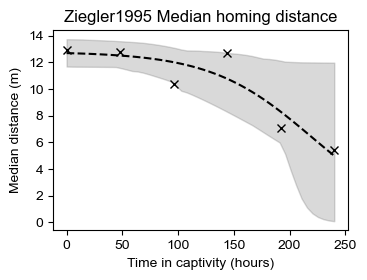

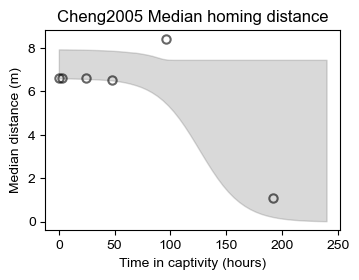

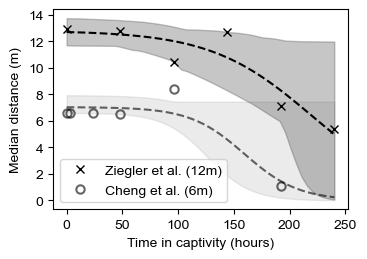

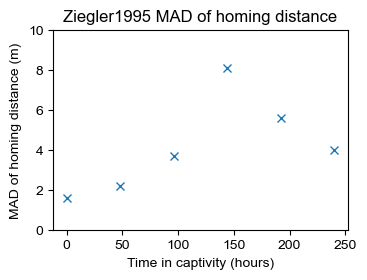

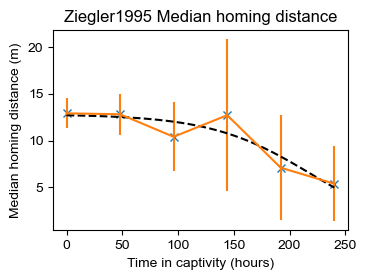

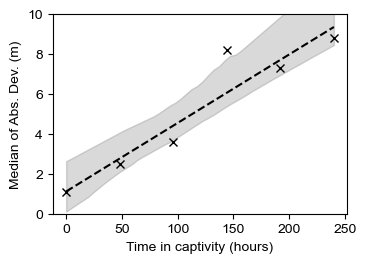

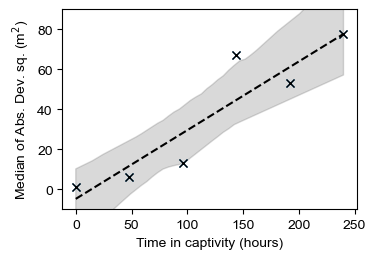

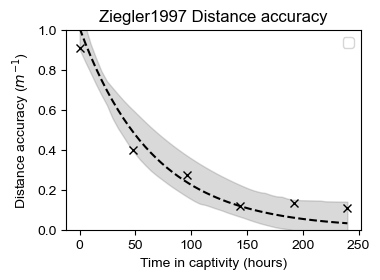

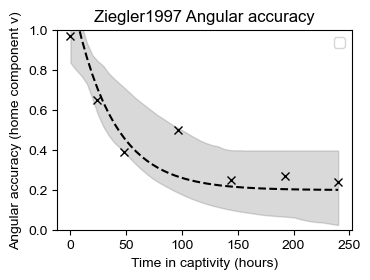

In [10]:
# Display ant data

# Quick run or long for paper
if DRAFT:
    repetitions = 1000 # Resampling repetitions
else:
    repetitions = 1000 # Resampling repetitions

plot_style = {
    "axes.spines.top"    : True, 
    "axes.spines.right"  : True, 
}
plt.rcParams.update(plot_style) # Update the style

# Import models of ant behaviour measures
# =======================================
from ant_behaviour_measures_models import *
# Imports the variables and functions:
# Inverted sigmoid model
#  PopulationLoss_str = 'K / (1 + Nl/(K - Nl) * np.exp(-r * t))'
#  PopulationLoss(t, K, Nl, r)
# Median ant homing distance vs waiting time
#  predict_ant_homing_distance(wait_t)
#  plot_ant_homing_distance(ax, wait_t, style={'color': 'grey', 'linestyle': '--'})
# Ant homing distance error dispersion vs waiting time
#  plot_ant_homing_distance_error_MAD(ax, wait_t, style={'color': 'grey', 'linestyle': '--'})
#  predict_ant_homing_distance_error_MAD(x_1)
# Ant homing distance error dispersion squared vs waiting time
#  plot_ant_homing_distance_error_MAD_squared(ax, wait_t, style={'color': 'grey', 'linestyle': '--'})
#  predict_ant_homing_distance_error_MAD_squared(x_1)
# Ant homing distance accuracy vs waiting time
#  plot_ant_homing_distance_accuracy_1_over_MAD(ax, wait_t, style={'color': 'grey', 'linestyle': '--'})
#  predict_ant_homing_distance_accuracy_1_over_MAD(x_1)
# Ant homing direction accuracy vs waiting time
#  plot_ant_homing_angle_accuracy_1_over_sigma_squared(ax, wait_t, style={'color': 'grey', 'linestyle': '--'})
#  predict_ant_homing_angle_accuracy_1_over_sigma_squared(x_1)

# Median homing distance

# Logistic function model of the median homing distance vs waiting time
#def predict_ant_homing_distance_error_MAD(wait_t):
#    K, Nl, r = 12.79111889, 0.09954786, -0.0220668
#    y_1 = PopulationLoss(wait_t, K, Nl, r)
#    return y_1

# Plot the logistic function model median homing distance vs waiting time
#def plot_ant_homing_distance(ax, wait_t, color='black'):
#    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
#    y_1 = predict_ant_homing_distance(x_1)
#    ax.plot(x_1, y_1, '--', color=color)

# Do bootstrap on fitting the logistic function to the data points multiple times for subsamples of the data
def bootstrap_func_regression_2D(data, 
                                 regression_func, 
                                 regression_func_str='', 
                                 init_vals=None, 
                                 bounds=(-np.inf, np.inf), 
                                 repetitions = 1000, 
                                 ensemble_size = 40):
    """ Simple Bootstrap implementation for 2D data points array input (x, y). 
        Gets <repetitions> number of subsamples of size <ensemble_size> from <data> and regresses 
        the function <regression_func> with initial parameter values <init_vals> and bounds <bounds>, 
        the fitted function parameters are returned in an array with every row being a set of fitted parameters. 
        <data>                : is a 2D array with columns being the different axes of the data,
                                e.g. x,y and the number of rows being the data samples.
        <regression_func>     : the function to regress the data with. 
        <regression_func_str> : a string displaying the function. 
        <init_vals>           : initial parameter values to use when regressing.
        <bounds>              : bounds for the function parameters. 
        Returns               : an array with every row being a set of fitted parameters. 
    """
    data_entries_num = len(data) # Number of data points
    indeces = range(data_entries_num) # Create a vector with indeces to the data points
    
    data_res = [] # A list to hold the results
    for i in range(repetitions):
        subsample_idxs = np.random.choice(indeces, size=ensemble_size, replace=True) # Get a random data subsample
        # Regress the function to the subsample data points
        x = data[subsample_idxs][:,0]
        y = data[subsample_idxs][:,1]
        try:
            popt = _fit_data_points(x, y, func=regression_func, func_str=regression_func_str, init_vals=init_vals, bounds=bounds) 
            data_res.append(popt) # Append the function parameters to the list
        except:
            pass
    return np.array(data_res)

def calc_func_median_std_and_CI(regression_func, # The function to regress
                           popts_array,     # An array with each row having an alternative set of parameters for the function
                           x_data_points,   # An array of x values to give to the regressed function
                           conf_level=95):  # The confidence level eg 95 for 95%
    """ Gets a function <regression_func> and an array of function parameter 
        sets <popts_array> and returns the median and std of y for the <x_data_points> 
        regression_func : a function with arguments (x_data_points, param1, param2, ..., paramN)
        popts_array     : array of row arrays with parameter sets e.g. 
                          np.array([[param1, param2, ..., paramN],
                                    [param1, param2, ..., paramN],
                                    [param1, param2, ..., paramN]])
        x_data_points   : an array with the x values to use as inputs to the function
        conf_level      : the confidence level eg 95 for 95%
        Returns         : 
        The Confidence Intervals are calculated based on 
        https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d 
    """
    y_values = []
    # For each function parameter set get the y values corresponding to the given x values
    for param_set in popts_array:
        y_values.append(regression_func(x_data_points, *param_set))
    y_values = np.array(y_values)
    # Median and STD of numbers in each column 
    median_array = np.median(y_values, axis=0)
    std_array    = np.std(y_values, axis=0, ddof=1)
    # Calculate the confidence intervals
    # The confidence intervals at 95% level are the cl_l=2.5 percentile and the cl_h=97.5 percentile
    cl_l = (100 - conf_level) / 2
    cl_h = 100 - cl_l
    CI = np.percentile(y_values, [cl_l, cl_h], axis=0)
    CI_low  = CI[0]
    CI_high = CI[1]
    return (median_array, std_array, CI_low, CI_high)

def plot_band(ax, x, medians, std_or_CI, standard_deviations=1, band_color = '#444444', band_color_alpha = 0.2, band_median_color = '#444444', band_median_color_alpha=1.0, band_median_line_style='--'):
    """ Plot the median and +/-2*std band or CI band
        x
        medians
        std_or_CI if the array has 1 row it contains the std, if it has 2 rows the first row is the lower CI and the second the upper CI
        standard_deviations = 1 
        band_color = '#444444'
        band_color_alpha = 0.2
        band_median_color = '#444444'
        band_median_color_alpha = 1.0
        band_median_line_style = '--'
    """
    # Plot the median and +/-2*std or CI band
    if std_or_CI.ndim == 1: # If one row it is the std
        std  = std_or_CI
        low  = medians-std*standard_deviations
        high = medians+std*standard_deviations
    elif std_or_CI.ndim == 2: # If two rows it is the Confidence Intervals
        CI   = std_or_CI
        low  = CI[0] # The low  confidence intervals array: 2.5%
        high = CI[1] # The high confidence intervals array: 97.5%
    else:
        print('ERROR: The value of std_or_CI must be a 1D or 2D array.')
        return
    # Plot the band
    ax.fill_between(x, high, low, color=band_color, alpha=band_color_alpha)
    # Plot the lowest values border
    ax.plot(x, low, color=band_color, alpha=0.0)
    # Plot the median values line
    ax.plot(x, medians, color=band_median_color, alpha=band_median_color_alpha, linestyle=band_median_line_style)
    # Plot the highest values border
    ax.plot(x, high, color=band_color, alpha=0.0)

def bootstrap_func_regression(ax,                       # Figure axis to plot the data in
                              x, y,                     # Two vectors of equal length with the x and the y data values
                              x_datapoints,             # A vector of arbitrary length with x values to use for plotting, median and std
                              regression_func,          # The function to regress to the data points
                              regression_func_str,      # A string displaying of the regressed function
                              init_vals=None,           # A list or vector with initial parameter values for the regression
                              bounds=(-np.inf, np.inf), # Bounds for the parameters to use in the regression
                              repetitions=1000,         # Times to regress the function
                              ensemble_size=20,         # Number of data points subsample to use for each regression
                              plot_data_points=True,    # Plot the data points
                              plot_fitted_curves=False, # Plot all the fitted functions for all the parameter sets found
                              plot_fitted_SD_band=True, # Plot all the band indicating the SD of fitted functions for all the parameter sets found
                              plot_fitted_CI_band=True, # Plot all the band indicating the SD of fitted functions for all the parameter sets found
                              data_color = 'black', 
                              data_marker = 'x', 
                              band_color = '#444444', 
                              band_color_alpha = 0.2, 
                              band_median_color = '#444444', 
                              band_median_color_alpha=1.0):
    """ Regresses a function to the data points multiple times plots the resulting 
        curves, calculates the median and std, plots a median+/-2*std band and 
        returns the regressed function parameters, the median, and the std.
    """
    # Put the data points in an array
    data_points = np.array([x, y])
    # Regress the regression_func repetitions times and get an array with fitted function parameters
    popts_array = bootstrap_func_regression_2D(data_points.T, 
                                               regression_func     = regression_func, 
                                               regression_func_str = regression_func_str, 
                                               init_vals           = init_vals, 
                                               bounds              = bounds, 
                                               repetitions         = repetitions, 
                                               ensemble_size       = ensemble_size)
    # Check if empty
    if len(popts_array) < 1:
        print('ERROR: No curve fitting attempts succeeded')
    
    # Calculate the median and std of the regressed curves
    med_ar, std_ar, CI_low_ar, CI_high_ar = calc_func_median_std_and_CI(regression_func     = regression_func, 
                                                                        popts_array         = popts_array, 
                                                                        x_data_points       = x_datapoints)
    
    # Convert it to the population std of the mean estimate: TO DO Double check
    #std_ar = std_ar * np.sqrt(ensemble_size) # ???? Is this right to use???? 

    # Plot the curves with the resulting regression parameters
    if plot_fitted_curves:
        for params in popts_array:
            xvalues, yvalues = _plot_fitted_data_points(ax, xdata=x_datapoints, func=regression_func, params=params, style={'color':'#444444', 'alpha':0.01, 'linestyle': '-'})
    
    # Plot the median and +/-2*std band
    if plot_fitted_SD_band:
        plot_band(ax, x=x_datapoints, 
                  medians=med_ar, 
                  std_or_CI=std_ar, 
                  standard_deviations=1, 
                  band_color = band_color, 
                  band_color_alpha = band_color_alpha, 
                  band_median_color = band_median_color, 
                  band_median_color_alpha=band_median_color_alpha)

    # Plot the median and +/-CI band
    if plot_fitted_CI_band:
        plot_band(ax, x=x_datapoints, 
                  medians=med_ar, 
                  std_or_CI=np.vstack((CI_low_ar, CI_high_ar)), 
                  standard_deviations=1, 
                  band_color = band_color, 
                  band_color_alpha = band_color_alpha, 
                  band_median_color = band_median_color, 
                  band_median_color_alpha=band_median_color_alpha)
    
    # Plot the data points
    if plot_data_points:
        ax.plot(x, y, data_marker, color=data_color, alpha=1.0)
    
    return (popts_array, med_ar, std_ar, CI_low_ar, CI_high_ar)

np.set_printoptions(precision=4, suppress=True, floatmode='fixed')

str_Ziegler1997 = 'Ziegler et al. (12m)'
str_Cheng2005   = 'Cheng et al. (6m)'

print('')
print('Median homing distance 12m')
print('--------------------------')
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
#ax.plot(t_2, y_2, 'x')
#ax.set_ylim([0, 15])
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14]) # [0, 2, 4, 6, 8, 10, 12, 14] [0, 4, 8, 12]
ax.set_ylabel('Median distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1995 Median homing distance')
# Plot the function regressed to all 6 data points
plot_ant_homing_distance(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})

# Bootstrap fitting the logistic function to the homing distance data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=PopulationLoss, 
                                                              regression_func_str=PopulationLoss_str, 
                                                              init_vals=None, 
                                                              #bounds=([11, 0.0, -0.2], [14, 1.5, -0.004]), # Empirical bounds to avoid the occasional extreme non sense fits
                                                              bounds=([11, 0.0, -0.2], [14, np.inf, -0.0]), # Empirical bounds to avoid the occasional extreme non sense fits
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI,
                                                              band_median_color_alpha=0.0)
med_array_homing_dist = med_array
std_array_homing_dist = std_array
CI_array_homing_dist  = np.vstack((CI_low_array, CI_high_array))
x_array_homing_dist   = x_datapoints

# Print some descriptive statistics about the bottstrapped fitting
print(PopulationLoss_str)
if popts_array.shape[1] == 3:
    print('popt:  {:^7} {:^7} {:^7}'.format('K', 'Nl', 'r'))
if popts_array.shape[1] == 4:
    print('popt:  {:^7} {:^7} {:^7} {:^7}'.format('K', 'Nl', 'r', 'intrcpt'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))


# RESULTS:
#        Median homing distance
#        ----------------------
#        Regressing the logistic function to the homing distance over waiting time data
#        multiple times (bootstrapping) we get regressed curves with parameters in this
#        range (bounds set to bounds=([11, 0.0, -0.2], [14, 1.5, -0.004])):
#        -------------------------------------
#        for 1000 iterations _5_ subsamples without replacement (so no bootstrap, just leave one data point out in each iteration):
#        -------------------------------------
#        K / (1 + Nl/(K - Nl) * np.exp(-r * t))
#        popt:     K      Nl       r   
#        min = [12.3680  0.0000 -0.1095]
#        max = [14.0000  1.0927 -0.0125]
#        med = [12.5997  0.0741 -0.0232]
#        std = [0.5842   0.4012  0.0354]
#        -------------------------------------
#        for 10000 iterations _6_ subsamples with replacement (bootstrap):
#        -------------------------------------
#        K / (1 + Nl/(K - Nl) * np.exp(-r * t))
#        popt:     K      Nl       r   
#        min = [11.0953  0.0000 -0.1115]
#        max = [14.0000  1.5000 -0.0040]
#        med = [13.1406  0.0948 -0.0223]
#        std = [0.7727   0.5360  0.0355]
#        -------------------------------------
#        for 10000 iterations _20_ subsamples with replacement (bootstrap):
#        -------------------------------------
#        K / (1 + Nl/(K - Nl) * np.exp(-r * t))
#        popt:     K      Nl       r   
#        min = [11.3068  0.0000 -0.1116]
#        max = [14.0000  1.5000 -0.0068]
#        med = [12.8938  0.0880 -0.0226]
#        std = [0.4517   0.2752  0.0139]
#         
#        So exploring in the simulations the range Nl=[0.0,1.3] and r=[-0.008,-0.1] is adequate.


print('')
print('Median homing distance 6m')
print('-------------------------')
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 3, 24, 48, 96, 192])
y_2 = np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
ax.plot(t_2, y_2, 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005)
#ax.set_ylim([0, 15])
ax.set_ylabel('Median distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Cheng2005 Median homing distance')
#plot_ant_homing_distance(ax, t_2)
# The same function plotted for longer time
#plot_ant_homing_distance(ax, np.linspace(0, 240))

# Bootstrap fitting the logistic function to the homing distance data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=PopulationLoss, 
                                                              regression_func_str=PopulationLoss_str, 
                                                              #init_vals=None, 
                                                              init_vals=[7, 0.03, -0.033],  # Initial guess of parameter values to optimize [a, r, k]
                                                              bounds=([6, 0.01, -0.1], [8, 0.05, -0.0]), # Empirical bounds to avoid the occasional extreme non sense fits
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI,
                                                              band_median_color_alpha=0.0, 
                                                              plot_data_points=False)
med_array_homing_dist_C6m = med_array
std_array_homing_dist_C6m = std_array
CI_array_homing_dist_C6m  = np.vstack((CI_low_array, CI_high_array))
x_array_homing_dist_C6m   = x_datapoints

# Print some descriptive statistics about the bottstrapped fitting
print(PopulationLoss_str)
if popts_array.shape[1] == 3:
    print('popt:  {:^7} {:^7} {:^7}'.format('K', 'Nl', 'r'))
if popts_array.shape[1] == 4:
    print('popt:  {:^7} {:^7} {:^7} {:^7}'.format('K', 'Nl', 'r', 'intrcpt'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))


print('')
print('Median homing distance 12 m and 6m')
print('----------------------------------')

fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
ax.plot(t_2, y_2, 'x', color='black', alpha=1.00, label=str_Ziegler1997)
plot_band(ax, x=x_array_homing_dist, medians=med_array_homing_dist, std_or_CI=CI_array_homing_dist, standard_deviations=1, band_color = '#444444', band_color_alpha = 0.3, band_median_color = 'black', band_median_color_alpha=0.0)
# Plot the function regressed to all 6 data points
plot_ant_homing_distance(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})

t_2 = np.array([0, 3, 24, 48, 96, 192])
y_2 = np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
ax.plot(t_2, y_2, 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005)
plot_band(ax, x=x_array_homing_dist_C6m, medians=med_array_homing_dist_C6m, std_or_CI=CI_array_homing_dist_C6m, standard_deviations=1, band_color = '#444444', band_color_alpha = 0.1, band_median_color = 'black', band_median_color_alpha=0.0)
# Plot the function regressed to all 6 data points
ax.plot(x_array_homing_dist_C6m, PopulationLoss(x_array_homing_dist_C6m, 7.03278735, 0.01, -0.04114223), '--', color='black', alpha=0.60)
#ax.set_ylim([0, 15])
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14]) # [0, 2, 4, 6, 8, 10, 12, 14] [0, 4, 8, 12]
ax.set_ylabel('Median distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.legend()

if not SAVE_PLOT:
    ax.set_title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(images_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + 'PopulationLoss' + save_figures_as_filetype), bbox_inches='tight', dpi=300, transparent=True)


print()
print('MAD of homing distance')
print('----------------------')
# MAD of homing distance
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
ax.plot(t_2, y_2, 'x')
ax.set_ylim([0, 10])
ax.set_ylabel('MAD of homing distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1995 MAD of homing distance')





print('')
print('Median homing distance +/- MAD')
print('------------------------------')
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
y_2_MAD = np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
ax.plot(t_2, y_2, 'x')
ax.errorbar(t_2, y_2, yerr=y_2_MAD)
#ax.set_ylim([0, 15])
ax.set_ylabel('Median homing distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1995 Median homing distance')
#plot_ant_homing_distance(ax, t_2)
# Plot the function regressed to the data points
plot_ant_homing_distance(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})


print()
print('Median of Absolute Deviations from nest')
print('---------------------------------------')
# Median of Absolute Deviations from nest
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])
#ax.plot(t_2, y_2, 'x')
ax.set_ylim([0, 10])
ax.set_ylabel('Median of Abs. Dev. (m)')
ax.set_xlabel('Time in captivity (hours)')
# Plot the function regressed to all 6 data points
plot_ant_homing_distance_error_MAD(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})

# Regress a line 
# Bootstrap fitting the logistic function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=func_line, 
                                                              regression_func_str=func_line_str, 
                                                              init_vals=None, 
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI,
                                                              band_median_color_alpha=0.0)
# Print some descriptive statistics about the bottstrapped fitting
print(func_line_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))
x_array_MAD   = x_datapoints
med_array_MAD = med_array
std_array_MAD = std_array
CI_array_MAD  = np.vstack((CI_low_array, CI_high_array))

if not SAVE_PLOT:
    ax.set_title('Ziegler1997 C. fortis MoAD from nest')
    #ax.set_title('Ziegler1997 C. fortis Diffusion rate at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(images_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviations' + save_figures_as_filetype), bbox_inches='tight', dpi=300, transparent=True)


# Regress the sqrt
if DRAFT:
    func_sqrt_str = 'a*np.sqrt(b*x) + c'
    def func_sqrt(x, a, b, c):
        return a*np.sqrt(b*x) + c
    # Regress the function to the data many times and plot the result
    popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                                  t_2, y_2, 
                                                                  x_datapoints, 
                                                                  regression_func=func_sqrt, 
                                                                  regression_func_str=func_sqrt_str, 
                                                                  init_vals=None, 
                                                                  bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf]), 
                                                                  repetitions=repetitions, 
                                                                  ensemble_size=6,
                                                                  plot_fitted_SD_band=plot_show_SD, 
                                                                  plot_fitted_CI_band=plot_show_CI,
                                                                  band_color='orange',
                                                                  band_median_color='orange',
                                                                  band_median_color_alpha=0.0)
    # Print some descriptive statistics about the bottstrapped fitting
    print(func_sqrt_str)
    print('popt:  {:^7} {:^7} {:^7}'.format('a', 'b', 'c'))
    print('min =', np.min(popts_array,    axis=0))
    print('max =', np.max(popts_array,    axis=0))
    print('med =', np.median(popts_array, axis=0))
    print('std =', np.std(popts_array,    axis=0))


print()
print('Median of Absolute Deviations from nest squared')
print('-----------------------------------------------')
# Median of Absolute Deviations from nest
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])
y_2_squared = y_2**2
ax.plot(t_2, y_2_squared, 'x')
ax.set_ylim([-10, 90])
ax.set_ylabel('Median of Abs. Dev. sq. (m$^2$)')
ax.set_xlabel('Time in captivity (hours)')
# Plot the function regressed to all 6 data points
plot_ant_homing_distance_error_MAD_squared(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})

# Bootstrap fitting the logistic function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2_squared, 
                                                              x_datapoints, 
                                                              regression_func=func_line, 
                                                              regression_func_str=func_line_str, 
                                                              init_vals=None, 
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI,
                                                              band_median_color_alpha=0.0)
x_array_MAD2   = x_datapoints
med_array_MAD2 = med_array
std_array_MAD2 = std_array
CI_array_MAD2  = np.vstack((CI_low_array, CI_high_array))


# Print some descriptive statistics about the bottstrapped fitting
print(func_line_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))

if not SAVE_PLOT:
    ax.set_title('Ziegler1997 C. fortis MoAD^2 from nest')
if SAVE_PLOT:
    fig.savefig(os.path.join(images_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviationsSquared' + save_figures_as_filetype), bbox_inches='tight', dpi=300, transparent=True)


print()
print('Distance accuracy')
print('-----------------')
# Distance accuracy
# Regress an exponential function with an intercept to see if we can get a better fit than 
# the no intercept exponential fit by Ziegler1995. Regardless of the initial parameter values
# the best fit has a small intercept 0.009 and exponent slope rate -0.366
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240]) # / 24
y_2 = np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])
#ax.plot(t_2, 1/y_2, 'x')
if DRAFT:
    fit_data_points(ax, t_2, 1/y_2, func_exp1, func_str=func_exp1_str, init_vals=[-0.01], style={'color': 'orange'}, label='My: exp(-0.015t)')                     # exp(b*x) are: -0.014642073404910706 R^2 = 0.9333851761623976
#fit_data_points(ax, t_2, 1/y_2, func_exp2, func_str=func_exp2_str, init_vals=[-0.015, 0.1], style={'color': 'black', 'linestyle':'--','alpha':1.0}, label='My: exp(-0.015*x)+0.009')           # exp(b*x) + c are: -0.015247651588355771 0.009420153878402254 R^2 = 0.933544212040003
if DRAFT:
    fit_data_points(ax, t_2, 1/y_2, func_exp3, func_str=func_exp3_str, init_vals=[1.0, -0.01, 0.1], style={'color': 'red'}, label='My: 0.797*exp(-0.02*x)+0.11') # a * exp(b*x) + c are: 0.7973826032614079 -0.019424366808324416 0.10822423002334482 R^2 = 0.9916380812139618
ax.set_ylim([0, 1])
ax.set_ylabel('Distance accuracy ($m^{-1}$)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1997 Distance accuracy')
ax.legend()
# Plot the function regressed to all 6 data points
plot_ant_homing_distance_accuracy_1_over_MAD(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})
# Using the bootstrap_func_regression() somehow does not give any good fits
# Bootstrap fitting the exponential function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting

# Regress the function to the data many times and plot the result
if DRAFT:
    popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                                  t_2, 1/y_2, 
                                                                  x_datapoints, 
                                                                  regression_func=func_exp1, 
                                                                  regression_func_str=func_exp1_str, 
                                                                  init_vals=None, 
                                                                  bounds=(-np.inf, np.inf), 
                                                                  repetitions=repetitions, 
                                                                  ensemble_size=6,
                                                                  plot_fitted_SD_band=plot_show_SD, 
                                                                  plot_fitted_CI_band=plot_show_CI,
                                                                  band_color='orange',
                                                                  band_median_color='orange',
                                                                  band_median_color_alpha=0.0)
    x_array_dist_accuracy1   = x_datapoints
    med_array_dist_accuracy1 = med_array
    std_array_dist_accuracy1 = std_array
    CI_array_dist_accuracy1  = np.vstack((CI_low_array, CI_high_array))

popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, 1/y_2, 
                                                              x_datapoints, 
                                                              regression_func=func_exp2, 
                                                              regression_func_str=func_exp2_str, 
                                                              init_vals=[-0.015, 0.1], 
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI,
                                                              band_color='#444444',
                                                              band_median_color='#444444',
                                                              band_median_color_alpha=0.0)
x_array_dist_accuracy2   = x_datapoints
med_array_dist_accuracy2 = med_array
std_array_dist_accuracy2 = std_array
CI_array_dist_accuracy2  = np.vstack((CI_low_array, CI_high_array))

# Print some descriptive statistics about the bottstrapped fitting
print(func_exp2_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))

if DRAFT:
    popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                                  t_2, 1/y_2, 
                                                                  x_datapoints, 
                                                                  regression_func=func_exp3, 
                                                                  regression_func_str=func_exp3_str, 
                                                                  init_vals=[1.0, -0.01, 0.1], 
                                                                  #bounds=(-np.inf, np.inf), 
                                                                  bounds=([0.7, -np.inf, 0], [2, 0, 0.5]), 
                                                                  repetitions=repetitions, 
                                                                  ensemble_size=6,
                                                                  plot_fitted_SD_band=plot_show_SD, 
                                                                  plot_fitted_CI_band=plot_show_CI,
                                                                  band_color='red',
                                                                  band_median_color='red',
                                                                  band_median_color_alpha=0.0)
    x_array_dist_accuracy3   = x_datapoints
    med_array_dist_accuracy3 = med_array
    std_array_dist_accuracy3 = std_array
    CI_array_dist_accuracy3  = np.vstack((CI_low_array, CI_high_array))


print()
print('Angular accuracy')
print('----------------')
# Angular accuracy
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 24, 48, 96, 144, 192, 240]) #/ 24
y_2 = np.array([0.97, 0.65, 0.39, 0.50, 0.25, 0.27, 0.24])
#ax.plot(t_2, y_2, 'x')
#if DRAFT:
#    ax.plot(t_2, func_exp2(t_2, -0.23, 0), '--', color='grey', label='Ziegler1997 exp(-0.23t)')
if DRAFT:
    fit_data_points(ax, t_2, y_2, func_exp1, func_str=func_exp1_str, init_vals=[-0.01], style={'color': 'orange'}, label='My: exp(-0.009t)')                                               # exp(b*x) are: -0.00946379302436708 R^2 = 0.7165837920509617
#fit_data_points(ax, t_2, y_2, func_exp2, func_str=func_exp2_str, init_vals=[-0.01, 0.3], bounds=([-np.inf, 0], [0, np.inf]), style={'color': 'black', 'linestyle':'--','alpha':1.0}, label='My: exp(-0.03*x)+0.2') # exp(b*x) + c are: -0.0279738468097591 0.20085827280761143 R^2 = 0.7163794667057858
if DRAFT:
    fit_data_points(ax, t_2, y_2, func_exp3, func_str=func_exp3_str, init_vals=[0.7, -0.01, 0.3], style={'color': 'red'}, label='My: 0.68*exp(-0.025*x)+0.28')                           # a * exp(b*x) + c are: 0.683292934034979  -0.02558181367635523 0.276354395318332 R^2 = 0.9111461097421923

ax.set_ylim([0, 1])
ax.set_ylabel('Angular accuracy (home component v)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1997 Angular accuracy')
ax.legend()
# Plot the function regressed to all 6 data points
plot_ant_homing_angle_accuracy_1_over_sigma_squared(ax, np.linspace(0, 240), style={'color': 'black', 'linestyle':'--','alpha':1.0})
# Using the bootstrap_func_regression() generates too wide band of curves depending on the points that are picked.
# Bootstrap fitting the exponential function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting

# Regress the function to the data many times and plot the result
if DRAFT:
    popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                                  t_2, y_2, 
                                                                  x_datapoints, 
                                                                  regression_func=func_exp1, 
                                                                  regression_func_str=func_exp1_str, 
                                                                  init_vals=None, 
                                                                  bounds=(-np.inf, np.inf), 
                                                                  repetitions=repetitions, 
                                                                  ensemble_size=6,
                                                                  plot_fitted_SD_band=plot_show_SD, 
                                                                  plot_fitted_CI_band=plot_show_CI,
                                                                  band_color='orange',
                                                                  band_median_color='orange',
                                                                  band_median_color_alpha=0.0)
    x_array_dir_accuracy1   = x_datapoints
    med_array_dir_accuracy1 = med_array
    std_array_dir_accuracy1 = std_array
    CI_array_dir_accuracy1  = np.vstack((CI_low_array, CI_high_array))

popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=func_exp2, # func_exp1, #
                                                              regression_func_str=func_exp2_str, 
                                                              #init_vals=[-0.6, 0.3], # None, #
                                                              init_vals=[-0.03, 0.2], # None, #
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI,
                                                              band_color='#444444',
                                                              band_median_color='#444444',
                                                              band_median_color_alpha=0.0)
x_array_dir_accuracy2   = x_datapoints
med_array_dir_accuracy2 = med_array
std_array_dir_accuracy2 = std_array
CI_array_dir_accuracy2  = np.vstack((CI_low_array, CI_high_array))

# Print some descriptive statistics about the bottstrapped fitting
print(func_exp2_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))

if DRAFT:
    popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                                  t_2, y_2, 
                                                                  x_datapoints, 
                                                                  regression_func=func_exp3, # func_exp1, #
                                                                  regression_func_str=func_exp3_str, 
                                                                  init_vals=[0.7, -0.6, 0.3], # None, #
                                                                  bounds=(-np.inf, np.inf), 
                                                                  repetitions=repetitions, 
                                                                  ensemble_size=6,
                                                                  plot_fitted_SD_band=plot_show_SD, 
                                                                  plot_fitted_CI_band=plot_show_CI,
                                                                  band_color='red',
                                                                  band_median_color='red',
                                                                  band_median_color_alpha=0.0)
    x_array_dir_accuracy3   = x_datapoints
    med_array_dir_accuracy3 = med_array
    std_array_dir_accuracy3 = std_array
    CI_array_dir_accuracy3  = np.vstack((CI_low_array, CI_high_array))




MAD of homing distance
----------------------
The fitted curve parameters a*x + b are: 0.01583333333118664 2.3000000000028518
R^2 = 0.35818568391211913
a*x + b
popt:     a       b   
min = [-0.0521 -5.1000]
max = [ 0.0917 15.6000]
med = [0.0149 2.0699]
std = [0.0141 1.8787]

STD of homing distance
----------------------
The fitted curve parameters a*x + b are: 0.019844140537900148 2.8826225155460414
R^2 = 0.35818568391211913
a*x + b
popt:     a       b   
min = [ -0.0653 -41.6667]
max = [ 0.9255 19.5517]
med = [0.0187 2.5954]
std = [0.0345 3.0400]

VAR of homing distance
----------------------
The fitted curve parameters a*x + b are: 0.18576536341620564 12.804982555684688
R^2 = 0.2038597266534159
a*x + b
popt:     a       b   
min = [  -1.1208 -141.6073]
max = [  1.6991 264.4593]
med = [0.1784 8.3534]
std = [ 0.2580 36.7576]


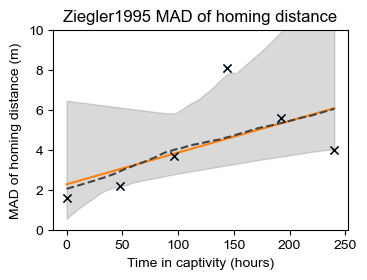

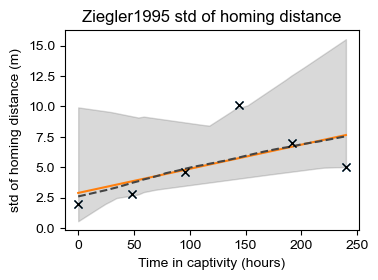

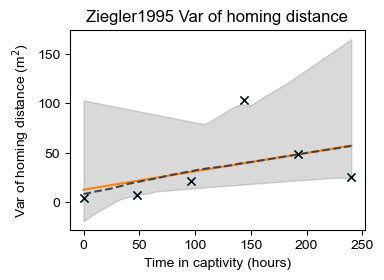

In [11]:
def MAD2variance(MAD):
    """ Assumes data come from Gaussian distribution """
    variance = MAD**2 / (2 / np.pi)
    return variance

def variance2MAD(variance):
    """ Assumes data come from Gaussian distribution """
    MAD = np.sqrt(variance * (2 / np.pi))
    return MAD

print()
print('MAD of homing distance')
print('----------------------')
# MAD of homing distance
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
ax.plot(t_2, y_2, 'x')
ax.set_ylim([0, 10])
ax.set_ylabel('MAD of homing distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1995 MAD of homing distance')

fit_data_points(ax, t_2, y_2, func_line, func_line_str, init_vals=None, bounds=(-np.inf, np.inf), label=None)


# Regress a line 
# Bootstrap fitting the logistic function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=func_line, 
                                                              regression_func_str=func_line_str, 
                                                              init_vals=None, 
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI)
# Print some descriptive statistics about the bottstrapped fitting
print(func_line_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))
x_array_homing_distance_MAD   = x_datapoints
med_array_homing_distance_MAD = med_array
std_array_homing_distance_MAD = std_array
CI_array_homing_distance_MAD  = np.vstack((CI_low_array, CI_high_array))




print()
print('STD of homing distance')
print('----------------------')
# MAD of homing distance
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
y_2 = MAD2variance(y_2)
y_2 = np.sqrt(y_2)
ax.plot(t_2, y_2, 'x')
#ax.set_ylim([0, 10])
ax.set_ylabel('std of homing distance (m)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1995 std of homing distance')

fit_data_points(ax, t_2, y_2, func_line, func_line_str, init_vals=None, bounds=(-np.inf, np.inf), label=None)


# Regress a line 
# Bootstrap fitting the logistic function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=func_line, 
                                                              regression_func_str=func_line_str, 
                                                              init_vals=None, 
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI)
# Print some descriptive statistics about the bottstrapped fitting
print(func_line_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))
x_array_homing_distance_STD   = x_datapoints
med_array_homing_distance_STD = med_array
std_array_homing_distance_STD = std_array
CI_array_homing_distance_STD  = np.vstack((CI_low_array, CI_high_array))




print()
print('VAR of homing distance')
print('----------------------')
# MAD of homing distance
fig, ax = plt.subplots(1, 1, figsize=figsize)
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
y_2 = MAD2variance(y_2)
ax.plot(t_2, y_2, 'x')
#ax.set_ylim([0, 10])
ax.set_ylabel('Var of homing distance (m$^2$)')
ax.set_xlabel('Time in captivity (hours)')
ax.set_title('Ziegler1995 Var of homing distance')

fit_data_points(ax, t_2, y_2, func_line, func_line_str, init_vals=None, bounds=(-np.inf, np.inf), label=None)


# Regress a line 
# Bootstrap fitting the logistic function to the data multiple times
x_datapoints = np.linspace(0, 240) # Create a range of x values for plotting
# Regress the function to the data many times and plot the result
popts_array, med_array, std_array, CI_low_array, CI_high_array = bootstrap_func_regression(ax, 
                                                              t_2, y_2, 
                                                              x_datapoints, 
                                                              regression_func=func_line, 
                                                              regression_func_str=func_line_str, 
                                                              init_vals=None, 
                                                              bounds=(-np.inf, np.inf), 
                                                              repetitions=repetitions, 
                                                              ensemble_size=6,
                                                              plot_fitted_SD_band=plot_show_SD, 
                                                              plot_fitted_CI_band=plot_show_CI)
# Print some descriptive statistics about the bottstrapped fitting
print(func_line_str)
print('popt:  {:^7} {:^7}'.format('a', 'b'))
print('min =', np.min(popts_array,    axis=0))
print('max =', np.max(popts_array,    axis=0))
print('med =', np.median(popts_array, axis=0))
print('std =', np.std(popts_array,    axis=0))
x_array_homing_distance_VAR   = x_datapoints
med_array_homing_distance_VAR = med_array
std_array_homing_distance_VAR = std_array
CI_array_homing_distance_VAR  = np.vstack((CI_low_array, CI_high_array))


[0.026287772827404958, 12.691571030000002]
[0.02628777282740482, 12.691571029999999]
[0.02628777282740482, 12.691571029999999]


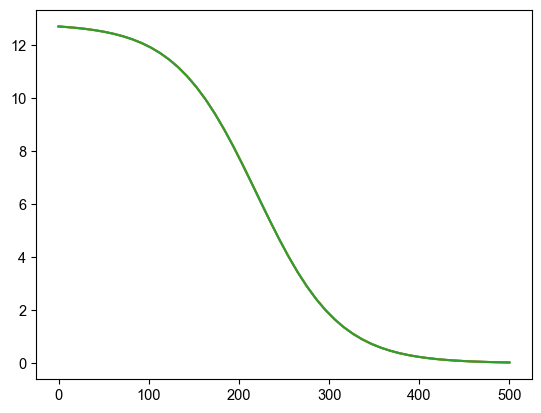

In [13]:
# How to convert parameters between my form and original form
# -----------------------------------------------------------
xx_1 = np.linspace(0, 500)
K = 12.79111889
r =  0.0220668

# My form
# -------------------------
N0 = 0.09954786
yy_2 = K / (1 + N0/(K - N0) * np.exp(r * xx_1)) # My form
plt.plot(xx_1, yy_2)

# Original form: We get the same y values as my form when N0 = K-N0_my_form
# -------------------------
N0 = K-0.09954786 # K-0.09954786=12.69157103
yy_1 = K / (1 + (K - N0)/N0 * np.exp(r * xx_1)) # Original form
plt.plot(xx_1, yy_1)

# The standard logistic form: approximate match
# -------------------------
alpha = 0.007843619971451242 # N0/(K - N0)=
yy_3 = K / (1 + alpha * np.exp(r * xx_1)) # Original form
plt.plot(xx_1, yy_3)

print('[{}, {}]'.format(np.min(yy_1), np.max(yy_1)))
print('[{}, {}]'.format(np.min(yy_2), np.max(yy_2)))
print('[{}, {}]'.format(np.min(yy_3), np.max(yy_3)))



Median homing distance
----------------------


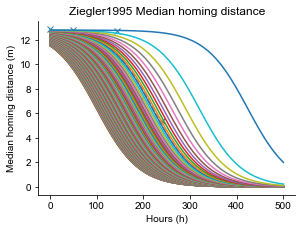

In [165]:
# Original form of logistic
# -------------------------
print('')
print('Median homing distance')
print('----------------------')
fig, ax = plt.subplots(1, 1, figsize=(figsize[0]*2, figsize[1]*2))
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
ax.plot(t_2, y_2, 'x')
#ax.set_ylim([0, 15])
ax.set_ylabel('Median homing distance (m)')
ax.set_xlabel('Hours (h)')
ax.set_title('Ziegler1995 Median homing distance')
plot_ant_homing_distance(ax, t_2)
# The same function plotted for longer time
plot_ant_homing_distance(ax, np.linspace(0, 500))

xx_1 = np.linspace(0, 500)
for N0 in np.arange(11.5, K, 0.01):
    #print('{:} '.format(N0), end='')
    plt.plot(xx_1, K / (1 + (K - N0)/N0 * np.exp(r * xx_1))) # Original form



Median homing distance
----------------------


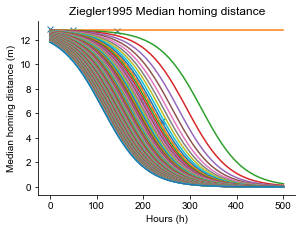

In [137]:
# My form of logistic
# -------------------------
print('')
print('Median homing distance')
print('----------------------')
fig, ax = plt.subplots(1, 1, figsize=(figsize[0]*2, figsize[1]*2))
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
ax.plot(t_2, y_2, 'x')
#ax.set_ylim([0, 15])
ax.set_ylabel('Median homing distance (m)')
ax.set_xlabel('Hours (h)')
ax.set_title('Ziegler1995 Median homing distance')
plot_ant_homing_distance(ax, t_2)
# The same function plotted for longer time
plot_ant_homing_distance(ax, np.linspace(0, 500))

K = 12.79111889
N0 = 0.09954786
r =  0.0220668
xx_1 = np.linspace(0, 500)
for N0 in np.arange(0, 0.999, 0.01):
    #print('{:} '.format(N0), end='')
    plt.plot(xx_1, K / (1 + N0/(K - N0) * np.exp(r * xx_1))) # My form



Median homing distance
----------------------


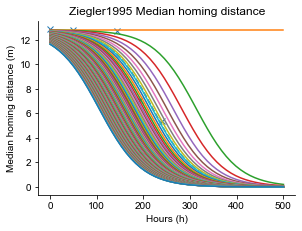

In [210]:
# Standard form of logistic
# -------------------------
print('')
print('Median homing distance')
print('----------------------')
fig, ax = plt.subplots(1, 1, figsize=(figsize[0]*2, figsize[1]*2))
t_2 = np.array([0, 48, 96, 144, 192, 240 ])
y_2 = np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
ax.plot(t_2, y_2, 'x')
#ax.set_ylim([0, 15])
ax.set_ylabel('Median homing distance (m)')
ax.set_xlabel('Hours (h)')
ax.set_title('Ziegler1995 Median homing distance')
plot_ant_homing_distance(ax, t_2)
# The same function plotted for longer time
plot_ant_homing_distance(ax, np.linspace(0, 500))

K = 12.79111889
r =  0.0220668
xx_1 = np.linspace(0, 500)
for alpha in np.arange(0, 0.1, 0.001):
    #print('{:} '.format(N0), end='')
    plt.plot(xx_1, K / (1 + alpha * np.exp(r * xx_1))) # Standard form


Noise=['0.008'] Nl=['0.0'] r=['-0.008']
Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Noise=['0.0'] Nl=['0.02'] r=['-0.018']
Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069
Noise=['0.0065'] Nl=['0.021'] r=['-0.021']
Outbound distance is 13.785538511658402
Outbound angle is 90.92611938128069


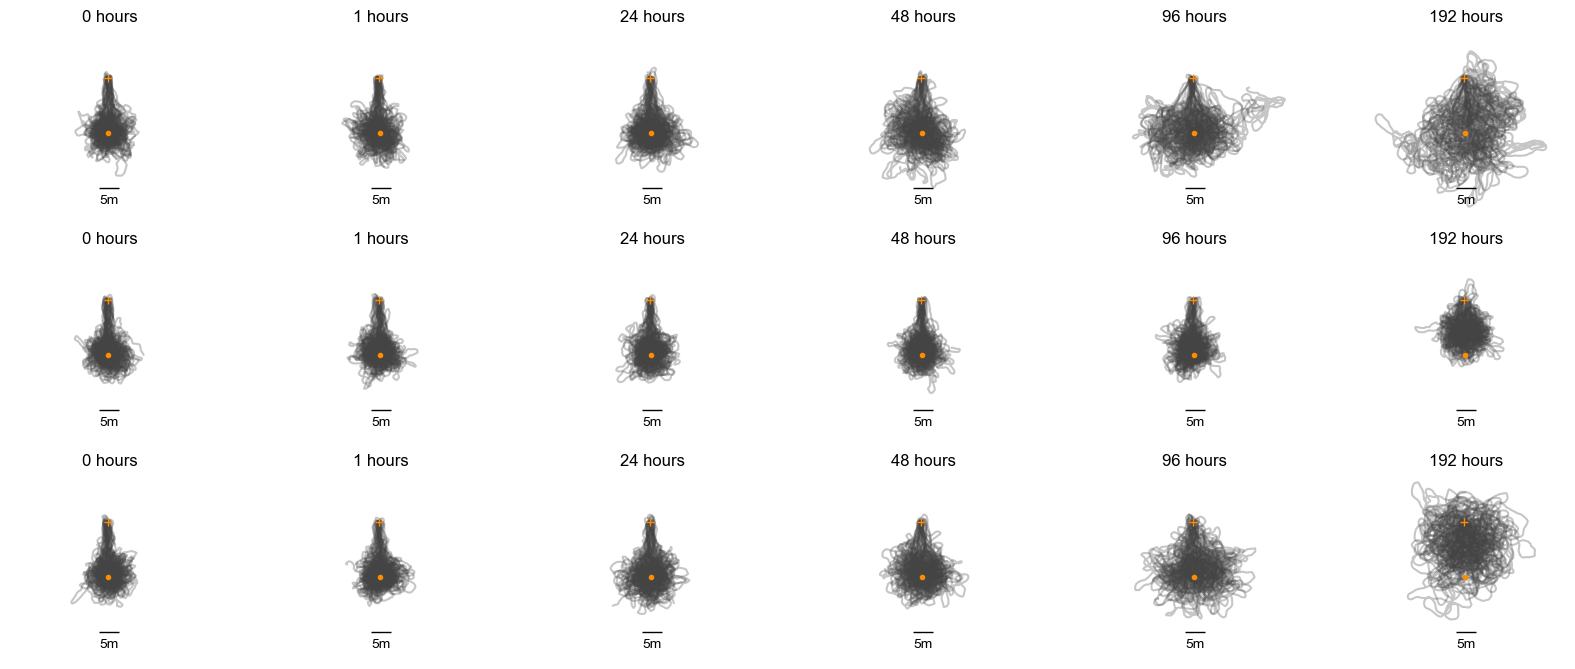

In [45]:
# Plots the full trajectories of simulated agents for all conditions

plot_style = {
    "axes.spines.top"    : False, 
    "axes.spines.right"  : False, 
}
plt.rcParams.update(plot_style) # Update the style

def generate_conditions_list(wait_hours, wait_noise_sd_values, mem_Nl_values, mem_r_values):
    """ Generates a list with strings in the format used as substrings 
        to select from the files with the simulated paths. The strings
        have the format FVWait<dd.d>hNoise<d.ddd>Nl<d.ddd>r<-d.ddd>"""
    # Create conditions list
    conditions = []
    for wait_time in wait_hours:
        for wait_noise_sd in wait_noise_sd_values:
            for mem_Nl_value in mem_Nl_values:
                for mem_r_value in mem_r_values:
                    conditions.append('FVWait' + str(float(wait_time)) + 'h' + 'Noise' + str(wait_noise_sd) + 'Nl' + str(mem_Nl_value) + 'r' + str(mem_r_value))
    return conditions

def plot_trajectories(
    fig=None, 
    axs=None,                     # Plot axis or numpy array of axes to plot in
    path=None,                    # Path where the input files are located
    outbound_path_filename=None,  # Path to the file that was used in the simulations as the outbound path
    first_file_num_id=1001,       # ID number in the filename of the first path file
    num_of_files=100,             # Number of path files/paths. The file name IDs are first_file_num_id+i in {0, num_of_files}
    show_labels = True,           # Show labels on plots
    show_axis = False,            # Show axes on plots
    distance_scaling_factor = 3,  # Path coordinates must be scaled by this factor to be in meters
    max_steps = None,             # If a number plot only the first max_steps coordinate values of the path 
    conditions = [],              # Experimental conditions list of strings
    conditions_labels = [],       # Labels to be used to refer to the experimental conditions
    save_figures=False,           # Save figure in file
    filename_extra=None):         # String to append to the saved plot filename

    if axs is None:
        fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full/4*len(conditions), column_full/5))
        #fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full/8*len(conditions), column_full/5))
    elif fig is None:
        print('ERROR: If argument \'axs\' is given \'fig\' is also required.')
        return None        

    if path is None:
        print('ERROR: Argument \'path\' specifying the path where the input files are located is required.')
        return None

    if outbound_path_filename is None:
        print('ERROR: Argument \'outbound_path_filename\' specifying the path to the file that was used in the simulations as the outbound path is required.')
        return None
    
    # Get the outbound path beginning and end points
    path_start, path_end = get_start_end_of_path(outbound_path_filename)
    outbound_distance = np.hypot(path_end[0]-path_start[0], path_end[1]-path_start[1])*distance_scaling_factor
    print('Outbound distance is {:}'.format(outbound_distance))
    
    # The outbound direction calculated end-to-end
    outbound_traj_vector = pd.DataFrame({'x': [0, path_end[0]-path_start[0]], 'y': [0, path_end[1]-path_start[1]]})
    outbound_angle = calc_angle(outbound_traj_vector, ref_dir=0)
    # The corresponding inbound direction (release point to fictive nest) is outbound_traj_vector+180deg
    homing_ref_vector = (outbound_angle + np.pi) % (2*np.pi)
    print('Outbound angle is {:}'.format(np.degrees(outbound_angle[0])))
    
    # Plot the trajectories of simulated agents
    # -----------------------------------------
    for idx_i,condition in enumerate(conditions):
        if isinstance(axs, np.ndarray):
            ax = axs[idx_i]
        else:
            ax = axs
        axs_row = axs
        
        start = first_file_num_id
        num = num_of_files
        noise_syn=0.1
        noise_rot = 2.0
        noiseSlope = 9.0
        sampling_rate = 25
        plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
        condition_sim = condition
        if condition_sim == 'FVNoIce':
            condition_sim = 'FV'
        if condition_sim == 'ZVNoIce':
            condition_sim = 'FVIce=0.5'
            condition_sim = 'ZV'
        if condition_sim == 'FVIce':
            condition_sim = 'FVIcex0.85'
        
        # For storing the center of each search
        path_ends_list = {}
        path_ends_list['x'] = []
        path_ends_list['y'] = []
        center_of_search = {}
        center_of_search['x'] = []
        center_of_search['y'] = []
        mean_vector_v = {}
        mean_vector_v['length'] = []
        mean_vector_v['theta'] = []
        mean_vector_v['length_exit'] = []
        mean_vector_v['theta_exit'] = []
    
        for i in range(start, start+num):
            filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'
        
            # If we use the already processed files (data/Converted_to_CSV/)
            if plot_npz_or_csv == 'csv':
                filename_csv = filename.replace('.npz', '.csv')            
                pd_i = pd.read_csv(filename_csv)

            # Get the path coordinates and make the end of the outbound trip the origin
            x = pd_i["x"] + path_end[0]
            y = pd_i["y"] + path_end[1]
            x = x * distance_scaling_factor
            y = y * distance_scaling_factor
            
            if max_steps is not None and max_steps < len(x):
                ax.plot(x[:max_steps], y[:max_steps], color='#444444', alpha=0.3)
            else:
                ax.plot(x, y, color='#444444', alpha=0.3)
        
        ax.axis('scaled')
        draw_sizebar(ax, size=5.0, label='5m', location='lower center')
        
        # Plot the nest location
        nest_x, nest_y = path_start[0]*distance_scaling_factor, path_start[1]*distance_scaling_factor
        ax.plot(nest_x, nest_y, '.', color='darkorange')
        # Plot the release location
        ax.plot(path_end[0]*distance_scaling_factor, path_end[1]*distance_scaling_factor, '+', color='darkorange')

        # Beautify the axes
        if show_axis:
            adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
        else:
            ax.set_axis_off()

        if show_labels:
            ax.set_xlabel("x (m)")
            if idx_i == 0:
                ax.set_ylabel("y (m)")

        if show_labels:
            ax.set_title(str(conditions_labels[idx_i])+' hours')

        ax.set_aspect('equal')
        ax.grid(color="0.9", linestyle='-', linewidth=1)
    
    if filename_extra is not None:
        filename_extra = '_' + filename_extra
    else:
        filename_extra = ''

    if save_figures:
        fig.savefig(images_path + 'simulated_fullRelease_' + 'routes_vs_waiting_time' + filename_extra + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    
    return (outbound_distance, fig, axs)


path = 'path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'
path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/Path_Integration_Simulations/path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot2.0_noiseSlope9.0_route_Generate_outbound_route_001/T_inbound3000steps/3_params_scanning_correct_Nl_range/Converted_to_CSV/Conditions/Memory/'
outbound_path_filename = 'path-integration-forget/data/outbound_route_only_S_to_N_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_001.npz'
#outbound_path_filename = 'path-integration-forget/data/outbound_route_only_NE_to_SW_1500steps_noiseSyn0.1_noiseRot7.0_noiseSlope9.0_route_Generate_outbound_route_003.npz'

show_labels = True
show_axis = False

wait_hours = [0, 1, 24, 48, 96, 192] # Wait hours
conditions_labels = wait_hours # Wait hours

# Create the figure with the subplot areas 
rows = 3 # We have three types of memory decay we plot
cols = len(conditions_labels) # For each memory decay type we plot for different waiting durations
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(column_full/4*1.4*cols, column_full/5*1.4*rows))

# Show paths with only random noise (diffusion dynamics)
# =================================================
wait_noise_sd_values = ['0.0055']
wait_noise_sd_values = ['0.008']
mem_Nl_values = ['0.0']
mem_r_values = ['-0.008']

print('Noise={} Nl={} r={}'.format(wait_noise_sd_values, mem_Nl_values, mem_r_values))

conditions = generate_conditions_list(wait_hours, wait_noise_sd_values, mem_Nl_values, mem_r_values)

outbound_distance, fig, axs = plot_trajectories(
    fig=fig, 
    axs = axes[0,:],
    path=path,                     # Path where the input files are located
    outbound_path_filename=outbound_path_filename, # Path to the file that was used in the simulations as the outbound path
    first_file_num_id=1001,       # ID number in the filename of the first path file
    num_of_files=40,              # Number of path files/paths. The file name IDs are first_file_num_id+i in {0, num_of_files}
    show_labels = True,           # Show labels on plots
    show_axis = False,            # Show axes on plots
    distance_scaling_factor = distance_scaling_factor, # Path coordinates must be scaled by this factor to be in meters
    conditions = conditions,               # Experimental conditions list of strings
    conditions_labels = conditions_labels, # Labels to be used to refer to the experimental conditions
    filename_extra=None)


# Show plots Only logistic decay (no noise)
# =========================================
# Load the data points
# For noise=0.0 the minimum homing distance MSE for the simulation data is for Nl=0.02, r=-0.018, MSE=0.091 and Nl=0.022, r=-0.017, MSE=0.096
wait_noise_sd_values = ['0.0']
mem_Nl_values = ['0.02']
mem_r_values = ['-0.018']

print('Noise={} Nl={} r={}'.format(wait_noise_sd_values, mem_Nl_values, mem_r_values))

conditions = generate_conditions_list(wait_hours, wait_noise_sd_values, mem_Nl_values, mem_r_values)

outbound_distance, fig, axs = plot_trajectories(
    fig=fig, 
    axs = axes[1,:],
    path=path,                    # Path where the input files are located
    outbound_path_filename=outbound_path_filename, # Path to the file that was used in the simulations as the outbound path
    first_file_num_id=1001,       # ID number in the filename of the first path file
    num_of_files=40,              # Number of path files/paths. The file name IDs are first_file_num_id+i in {0, num_of_files}
    show_labels = True,           # Show labels on plots
    show_axis = False,            # Show axes on plots
    distance_scaling_factor = distance_scaling_factor, # Path coordinates must be scaled by this factor to be in meters
    conditions = conditions,               # Experimental conditions list of strings
    conditions_labels = conditions_labels, # Labels to be used to refer to the experimental conditions
    filename_extra=None)




# Show plots Logistic decay and noise (decay and diffusion)
# =========================================================
# Load the data points
wait_noise_sd_values = ['0.0065']
mem_Nl_values = ['0.021']
mem_r_values = ['-0.021']

conditions = generate_conditions_list(wait_hours, wait_noise_sd_values, mem_Nl_values, mem_r_values)

print('Noise={} Nl={} r={}'.format(wait_noise_sd_values, mem_Nl_values, mem_r_values))

outbound_distance, fig, axs = plot_trajectories(
    fig=fig, 
    axs = axes[2,:],
    path=path,                    # Path where the input files are located
    outbound_path_filename=outbound_path_filename, # Path to the file that was used in the simulations as the outbound path
    first_file_num_id=1001,       # ID number in the filename of the first path file
    num_of_files=40,              # Number of path files/paths. The file name IDs are first_file_num_id+i in {0, num_of_files}
    show_labels = True,           # Show labels on plots
    show_axis = False,             # Show axes on plots
    distance_scaling_factor = distance_scaling_factor, # Path coordinates must be scaled by this factor to be in meters
    conditions = conditions,               # Experimental conditions list of strings
    conditions_labels = conditions_labels, # Labels to be used to refer to the experimental conditions
    filename_extra=None)


if save_figures:
    fig.savefig(images_path + 'simulated_fullRelease_' + 'routes_vs_waiting_time' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0


In [12]:
def make_plot(ax, x, y, x_label='', y_label='', xticks=None, title=None, filename_extra_str='', func=func_exp3, func_str=func_exp3_str, init_vals=None):
    """
        ax                 : A figure axis object to plot in
        x, y               : The x and y values are lists or arrays
        x_label,           
        y_label            : The x and y axis labels
        xticks             : The tick values to show on the x axis
        filename_extra_str : Extra string to add to the filename when saving the figure
        func               : Function to regress to the data points
        func_str           : The funciton as a string for displaying
        init_vals          : None or a list with the initial regression function parameters
    """
    ax.plot(x, y, 'x', color='#444444') # Plot the data points
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if isinstance(xticks, list):
        ax.set_xticks(xticks) # eg [0, 24, 48, 96, 144, 192, 240]
    if title:
        ax.set_title(title)

    # Regress the function func to the data points
    fit_data_points(ax, x, y, func, func_str, init_vals=init_vals, style={'color': '#444444'})


def plot_data_analysis_1parameter(measure,                                                   # Dict key of measure data points to use 
                                  wait_noise_sd_values,                                      # 
                                  slice_t_max,                                               # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                                  squared               = False,                             # Raise the y values to the power or 2
                                  inverse               = False,                             # Plot the 1 / y of the data
                                  normalise             = False,                             # Normalise data by plotting the y/max(y)
                                  y_label               = '',                                # 
                                  y_lim                 = [None, None],                      # Do not limit the y axis range
                                  regression_func_list  = None,                              # list of dicts specifying the regression function to use for make_plot functions
                                  common_figure         = None,                              # Plot each plot in a separate figure
                                  file_spec_str         = 'homing_distance_vs_waiting_time', # Filename substring to use in the saved figures
                                  func_predict          = None,                              # Function for producing target y values
                                  func_plot_predictions = None                               # Function to plot the target y values
                                 ):
    
    MSE_homing_dist = [] # To store the MSE values

    if common_figure:
        cols = common_figure.get('cols', 3) # Use the provided number of columns or 3 as default value
        rows = int(np.ceil((len(wait_noise_sd_values)+1) / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(figsize[0]*cols, figsize[1]*rows)) # , figsize=figsize

    # Plot the Gaussian diffusion effect
    print('Noise(t)')
    if common_figure:
        ax = axs[0, 0] # Get the first subplot
    else:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Get the data and plot  
    wait_t = search_dispersion_list['FVIcen']["Wait"][0:slice_t_max]
    y = search_dispersion_list['FVIcen'][measure][0:slice_t_max]
    if squared:
        y = np.array(y)**2
    if inverse:
        y = 1 / np.array(y)
    if normalise:
        y = y / np.max(y)
    
    try:
        make_plot(ax, wait_t, y, x_label='Waiting time (h)', y_label=y_label, title='Diffusion', func=regression_func_list[0].get('func', None), func_str=regression_func_list[0].get('func_str', None), init_vals=regression_func_list[0].get('init_vals', None))
        ax.set_ylim(y_lim)
        if func_predict:
            func_plot_predictions(ax, wait_t)
            y_pred = func_predict(np.array(wait_t))
            MSE = mean_squared_error(y, y_pred)
            print('MSE =', MSE)
            MSE_homing_dist.append(MSE)
    except:
        ax.set_title('Diffusion')
        ax.set_ylim(y_lim)
        print('Exception: Issue plotting for Diffusion')
    if not common_figure and save_figures:
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_withDiffusion' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0

    # Plot the logistic loss and noise effect
    for i,v in enumerate(wait_noise_sd_values):
        j = i+1 # Consider the preceding plots
        print()
        print('LogisticLoss(t) + Noise = ', v)
        if common_figure:
            ax = axs[int(j/cols), j%cols]
        else:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
    
        wait_t = search_dispersion_list['FVWaitNoise' + str(v) + 'b']["Wait"][0:slice_t_max]
        y = search_dispersion_list['FVWaitNoise' + str(v) + 'b'][measure][0:slice_t_max]
        if squared:
            y = np.array(y)**2
        if inverse:
            y = 1 / np.array(y)
        if normalise:
            y = y / np.max(y)
        
        try:
            make_plot(ax, wait_t, y, x_label='Waiting time (h)', y_label=y_label, title='LogisticLoss + Noise ' + str(v), func=regression_func_list[j].get('func', None), func_str=regression_func_list[j].get('func_str', None), init_vals=regression_func_list[j].get('init_vals', None))
            ax.set_ylim(y_lim)
            if func_predict:
                func_plot_predictions(ax, wait_t)
                y_pred = func_predict(np.array(wait_t))
                MSE = mean_squared_error(y, y_pred)
                print('MSE =', MSE)
                MSE_homing_dist.append(MSE)
        except:
            ax.set_title('LogisticLoss(t) + Noise ' + str(v))
            ax.set_ylim(y_lim)
            print('Exception: Issue plotting for noise =', v)

        if not common_figure and save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_withLogisticLoss_And_Noise' + str(v) + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0

    # Plot the MSE of the fits
    if func_predict:
        fig2 = plt.figure()
        plt.plot(['Diff']+wait_noise_sd_values, MSE_homing_dist)
        plt.ylabel('MSE')
        plt.xlabel('Condition')

    if common_figure:
        plt.tight_layout()
        if save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
            if func_predict:
                fig2.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_MSE_' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0


def plot_data_analysis_3parameters(measure,                                                   # Dict key of measure data points to use 
                                   wait_noise_sd_values,                                      # 
                                   mem_Nl_values,                                             # 
                                   mem_r_values,                                              # 
                                   slice_t_max,                                               # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                                   squared               = False,                             # Raise the y values to the power or 2
                                   inverse               = False,                             # Plot the 1 / y of the data
                                   normalise             = False,                             # Normalise data by plotting the y/max(y)
                                   y_label               = '',                                # 
                                   y_lim                 = [None, None],                      # Do not limit the y axis range
                                   regression_func_list  = None,                              # list of dicts specifying the regression function to use for make_plot functions
                                   axis                  = None,                              # A plot axis to plot in. If this is given common_figure must be None.
                                   common_figure         = None,                              # Create a figure with subplots to plot each plot. If this is given axis must be None.
                                   file_spec_str         = 'homing_distance_vs_waiting_time', # Filename substring to use in the saved figures
                                   func_predict          = None,                              # Function for producing target y values
                                   func_plot_predictions = None,                              # Function to plot the target y values
                                   func_plot_style       = {'color': 'grey'},                 # Colour for plotting the target function
                                   show_title            = True,                              # Show titles in the plots
                                   save_figures          = False
                                  ):
    
    MSE_homing_dist = [] # To store the MSE values

    if common_figure:
        cols = common_figure.get('cols', 3) # Use the provided number of columns or 3 as default value
        #rows = int(np.ceil((len(wait_noise_sd_values)*len(mem_Nl_values)*len(mem_r_values)+1) / cols))
        rows = int(np.ceil((len(wait_noise_sd_values)*len(mem_Nl_values)*len(mem_r_values)) / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(figsize[0]*cols, figsize[1]*rows)) # , figsize=figsize
    elif axis:
        cols = 1
        rows = 1
        axs  = axis
        fig = axs.get_figure()
    else:
        cols = 1
        rows = 1
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
    
    # Get the data and plot
    j = 0 # Subplot index
    # Plot the logistic loss and noise effect
    for noise_num in wait_noise_sd_values: # Iterate over noise (diffusion coefficients)
        for Nl_num in mem_Nl_values:       # 
            for r_num in mem_r_values:     # 
                noise = str(noise_num)
                Nl    = str(Nl_num)
                r     = str(r_num)
                print()
                print('Logist(t, Nl={}, r={}) + N={}'.format(Nl, r, noise))
                if common_figure:
                    if isinstance(axs, np.ndarray):
                        if axs.ndim == 2:
                            ax = axs[int(j/cols), j%cols]
                        else:
                            ax = axs[j]
                    else:
                        ax = axs
                elif axis:
                    ax = axs
                else:
                    ax = axs
                
                wait_t = search_dispersion_list[noise][Nl][r]["Wait"][0:slice_t_max]
                y = search_dispersion_list[noise][Nl][r][measure][0:slice_t_max]
                if squared:
                    y = np.array(y)**2
                if inverse:
                    y = 1 / np.array(y)
                if normalise:
                    y = y / np.max(y)

                if func_predict:
                    y_pred = func_predict(np.array(wait_t))
                    MSE = mean_squared_error(y, y_pred)
                    print('MSE =', MSE)
                    MSE_homing_dist.append(MSE)
                if show_title:
                    title='Nl={}, r={}, N={}'.format(Nl, r, noise)
                else:
                    title = None
                try:
                    make_plot(ax, wait_t, y, x_label='Time in captivity (hours)', y_label=y_label, title=title, func=regression_func_list[j].get('func', None), func_str=regression_func_list[j].get('func_str', None), init_vals=regression_func_list[j].get('init_vals', None))
                    ax.set_ylim(y_lim)
                    if func_predict:
                        func_plot_predictions(ax, wait_t, style=func_plot_style)
                except:
                    if show_title:
                        ax.set_title(title)
                    ax.set_ylim(y_lim)
                    print('Exception: Issue plotting for ' + 'Logist(t, Nl={}, r={}) + N={}'.format(Nl, r, noise))

                if not common_figure and not axis and save_figures:
                    fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_withLogistic_Nl{}r{}_And_Noise{}'.format(Nl, r, noise) + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0

                j = j + 1

    if common_figure:
        plt.tight_layout()
        if save_figures:
            fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
            # Plot the MSE of the fits
            if func_predict and (rows*cols > 1):
                fig2 = plt.figure()
                plt.plot(wait_noise_sd_values, MSE_homing_dist)
                plt.ylabel('MSE')
                plt.xlabel('Condition')
                fig2.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_MSE_' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
        return (fig, axs, cols, rows)
    else:
        return None



In [13]:
wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02] # The added diffusion coefficient noise
mem_Nl_values        = [0.0, 0.001, 0.01, 0.016, 0.018, 0.019, 0.02, 0.021, 0.022, 0.025, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.3, 0.5, 0.999, 1.3] # 25
mem_r_values         = [-0.008, -0.01, -0.012, -0.014, -0.015, -0.016, -0.017, -0.018, -0.019, -0.02, -0.021, -0.022, -0.023, -0.024, -0.025, -0.026, -0.027, -0.028, -0.029, -0.03, -0.031, -0.032, -0.035, -0.04, -0.045, -0.05, -0.1] # 27

# A good choice with the first parameter range from 19 November 2022
#mem_Nl_values        = [0.019]
#mem_r_values         = [-0.018]

# To do:
#       ** Try turn point distance measure **
#              No good matches for the previous parameters range
#                              for the new parameters range?
#       ** Best option: 0.022, -0.019 with noise 0.006--0.007
#       ** Try collecting new noise values: 0.0055 and 0.0065 **
#       ** Tried collecting combinations: Nl=0.023, r=-0.019 and Nl=0.024, r=-0.019 (but matching was worse) (./spawn_data_collection_qjobs_short3a.sh ./spawn_data_collection_qjobs_short3b.sh);  
#                                       and latest Nl range with r=-0.04, -0.041, -0.042 (./spawn_data_collection_qjobs_short4.sh) **
#       ** Try collecting new noise values: 0.0055 for previous ranges, 0.0065 for latest ranges **

# Best choice 8 December 2022 (in 3_parameters_results_correct_Nl_range_combined_01Ded2022/)
mem_Nl_values        = [0.018]
mem_r_values         = [-0.021] # Now the noise 0.0065 which was the best is not good for dir accuracy, it seems some of the data points changed value

# Best choice 14 December 2022 (in 3_parameters_results_correct_Nl_range_combined_01Ded2022/)
mem_Nl_values        = [0.021]
mem_r_values         = [-0.021]

# These are using the 2 parameters exponential model as the target for the distance and direction accuracy
# Best choices exploration 14 December 2022 (in 3_parameters_results_correct_Nl_range_combined_01Ded2022/)
#  0.0065, 0.021, -0.021 Very Good noise 0.0065 appears 2 times in the top matches
#  0.007,  0.02,  -0.019 Good noise 0.007       appears 2 times in the top matches
#  0.0065, 0.025, -0.02  Good 0.006--0.0065     appears 2 times in the top matches
#  0.006,  0.018, -0.019 OK noise 0.006         appears 1 time  in the top matches

# The below were using the 3 parameters exponential model as the target for the distance and direction accuracy
# Best choices exploration 8 December 2022 (in 3_parameters_results_correct_Nl_range_combined_01Ded2022/)
#  0.022, -0.018 appears 3 times in the top 15 matches (ranked by Combination_x11111)
#  0.02,  -0.018 appears 2 times in the top 15 matches (ranked by Combination_x11111)
#* 0.004, 0.022, -0.018  Good overlap of ranges
#               hom dist noise<=0.0065                  MAD noise=0.005--0.008 MAD2 noise= Dist acc noise=0.004--0.005,0.0065,0.008--0.01  Dir acc noise=0.003--0.007
#               best for noise 0.005 and 0.0065 the background homing distance is ~6m and ~7m
#  0.0065, 0.021, -0.019 Good overlap of ranges
#               hom dist noise<=0.0065                  MAD noise<=0.008 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.005
#               best for noise 0.0065 the background homing distance is ~7.5m
# 0.005, 0.019, -0.018 Not good: Dist accuracy is the problem is a bit off for noise 0.005,0.006
#               hom dist noise<=0.0065                  MAD noise=0.004--0.008 MAD2 noise= Dist acc noise=0.005,0.006,0.007--0.01  Dir acc noise=0.003--0.007
#               best for noise 0.005,0.006?
# 0.0055, 0.022, -0.02  Not good: Dist accuracy is the problem is a bit off
#               hom dist noise=0.005--0.007             MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.0055--0.01  Dir acc noise=0.003--0.008
#               best for noise 0.005--0.007
# 0.0065, 0.016, -0.018 Good overlap
#               hom dist noise<=0.0065                  MAD noise=0.0055--0.009 MAD2 noise= Dist acc noise=0.006--0.01  Dir acc noise=0.003--0.008
#               best for noise 0.006--0.0065
# 0.0065, 0.021, -0.021 Good overlap
#               hom dist noise=0.005--0.0065            MAD noise=0.005--0.0065 MAD2 noise= Dist acc noise=0.006--0.01  Dir acc noise=0.002--0.007
#               best for noise 0.0065
#7 0.005, 0.018, -0.02  Good overlap 
#               hom dist noise=0.002-0.006              MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.005--0.007
#               best for noise 0.0065--0.007
#* 0.007, 0.02,  -0.018  Good, marginal overlap
#               hom dist noise<=0.005,0.007             MAD noise=0.005--0.009 MAD2 noise= Dist acc noise=0.006--0.015 Dir acc noise=0.003--0.007
#               best for noise 0.006--0.007
# 0.0065, 0.022, -0.019 Good overlap of ranges
#               hom dist noise<=0.006                   MAD noise<=0.006 MAD2 noise= Dist acc noise=0.007--0.009 Dir acc noise=0.002--0.006
#               Using the turning point measures: for this parameters set worsens the matches
#               best for noise ~0.0065
# 0.0065, 0.025, -0.021  Good overlap
#               best for noise 0.0065
# 0.006, 0.018, -0.019  Marginal overlap OK match
#               hom dist noise=0.001-0.006              MAD noise=0.006--0.007 MAD2 noise= Dist acc noise=0.006--0.009,0.01  Dir acc noise=0.003--0.007
#               best for noise 0.006 but not all measures match closely
# 0.005, 0.02, -0.019  Marginal overlap OK match
#               hom dist noise<=0.004                   MAD noise<=0.006 MAD2 noise= Dist acc noise=0.006--0.01 Dir acc noise=0.004--0.005(or 0.007)
#               best for noise 0.006


# 0.005, 0.019, -0.02    No good overlap
#               best for noise 0.006--0.0065
# 0.025, -0.019 No good overlap
# 0.023, -0.019 No good slope: slope not as steep as in the ants
#               hom dist noise=0.005                    MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.004--0.007
#               best for noise 0.005 but the slope of the homing distance is not as steep as in the ants
# 0.02, -0.02   No good overlap of ranges: the slope is right for noise<0.005 it is only Dist acc noise that does not overlap and needs to be at least 0.007 **
#               hom dist noise<=0.005(not steep enough) MAD noise<=0.006 MAD2 noise= Dist acc noise=0.008--0.015 Dir acc noise=0.004--0.005
# 0.02, -0.022  No good overlap of ranges: it is Dist acc noise and Dir acc noise that do not overlap
#               hom dist noise=0.006(not steep enough)  MAD noise<=0.007 MAD2 noise= Dist acc noise=0.005--0.01 Dir acc noise=0.003--0.004(or 0.006)
# 0.02, -0.018  No good overlap of ranges for Dist acc noise, Dist acc noise needs higher noise
#               hom dist noise<=0.003                   MAD noise<=0.008 MAD2 noise= Dist acc noise=0.006-0.015 Dir acc noise=0.003--0.006
#               best for noise 0.003 but Dist acc noise needs >=0.006
# 0.001, -0.035 Steeper homing distance than ants, but for noise 0.006--0.007 the steepness is exactly right it is the x intercept (Nl) that needs to change. Very interesting alternative range of viable solutions that allow matching the homing distance with higher noise than needed with Nl~=0.02,r~=-0.02? This might enable finding a noise level that satisfies all measures (homing distance usually requires lower noise than the other measures for Nl~=0.02, r~=-0.02)
#               hom dist noise<=0.008(need explore Nl)  MAD noise<=0.008 MAD2 noise= Dist acc noise=0.005--0.01 Dir acc noise=0.004--0.006
# 0.0055, 0.016, -0.019  No overlap
# 0.0055, 0.025, -0.02   No overlap
# 0.0055, 0.04, -0.015   No overlap

#1 0.005, 0.06,  -0.014  Not good match
#2 0.006, 0.025, -0.018  Marginal overlap
#               hom dist noise=0.003--0.006             MAD noise=0.004--0.007 MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.003--0.007
#3 0.005, 0.05,  -0.015  Not good match
#4 0.006, 0.04,  -0.016  Marginal overlap
#               hom dist noise=0.002-0.003,0.007        MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.007
#5 0.005, 0.025, -0.016  Marginal overlap
#               hom dist noise=0.002-0.004              MAD noise=0.005--0.008 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.007

#2 0.006, 0.025, -0.018
#3 0.005, 0.05,  -0.015  Not good match


# Exploring with the extended parameter range from 1-6 December 2022
# Extra data collection: explore additional region of the search space (in 3_parameters_results_extra_search_space_05Ded2022/)
#wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.009, 0.01, 0.015, 0.02] # The added diffusion coefficient noise
#mem_Nl_values        = [0.0, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01]
#mem_r_values         = [-0.033, -0.034, -0.035, -0.036, -0.037, -0.038, -0.039, -0.04, -0.041, -0.042]
#mem_Nl_values        = [0.001]
#mem_r_values         = [-0.033]

# Top 2 minimal combined MSE for each combination kind
#  0.0055, 0.0005, -0.034 No good matches

#1 0.005, 0.001,  -0.034  Marginal match best for noise 0.006--0.007
#                hom dist noise=0.003--0.007       MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.007--0.009 Dir acc noise=0.004--0.006
#                best for noise 0.006--0.007
#                This is the Minimum MSE combination for noise=0.005 but Dist accuracy has no good overlap, needs >=0.007.
# 0.005, 0.00075, -0.033  No good matches: It is only the Dist accuracy that is not within the band
#                hom dist noise<=0.007             MAD noise=0.005--0.008 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.004--0.007
#                 best noise=0.007 but the Dist accuracy is not within the band
#2 0.005, 0.00125, -0.033 Not good overlap: MAD and Dist accuracy not good matches for noise=0.005
#                 best noise=0.007--0.008 but the Dist and Dir accuracy are not within the band
#3 0.006, 0.0015,  -0.033 Marginal overlap: ** Try with noise=0.0065 **
#                hom dist noise=0.003--0.007       MAD noise=0.004--0.006 MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.004--0.006
#4 0.005, 0.0025,  -0.033 Not good overlap: MAD and Dist accuracy not good matches for noise=0.005
#                hom dist noise=0.004--0.008       MAD noise<=0.004       MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.007
#2 0.005, 0.00125, -0.033  
#1 0.005, 0.001,   -0.034  
#5 0.010, 0.0055,  -0.040 Not good matches: How come has so low combined MSE, it was 0.09 higher than the other cases
#                hom dist noise=not steep enough   MAD noise=no good matches MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.002--0.004
#6 0.010, 0.0025,  -0.038 Not good matches: Not sure why noise=0.01 is lower MSE while noise=0.006 gives better matches
#                hom dist noise=0.007              MAD noise=no good matches MAD2 noise= Dist acc noise=0.006--0.009 Dir acc noise=0.003--0.006
#  0.006, 0.001, -0.033   No overlapping noise values except for the Dist acc noise
#                hom dist noise<=0.007             MAD noise=0.006--0.007 MAD2 noise= Dist acc noise=0.009--0.01  Dir acc noise=0.004--0.007
#                best for noise 0.006--0.008 ** Try 0.0075? **
#  0.006, 0.0015, -0.036  Marginal overlap
#                hom dist noise=0.006--0.008      MAD noise=0.006--0.008 MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.003--0.008
#                best for noise 0.006--0.008
#  0.007, 0.0005, -0.035  Marginal overlap
#                hom dist noise=0.005--0.007      MAD noise=0.007--0.009 MAD2 noise= Dist acc noise=0.007--0.009  Dir acc noise=0.005--0.008
#                best for noise 0.007--0.008
#  0.007, 0.0005, -0.033  Marginal overlap
#                hom dist noise=0.005--0.007      MAD noise=0.007--0.01  MAD2 noise= Dist acc noise=0.007--0.01   Dir acc noise=0.003--0.007
#                best for noise 0.007
# 0.007, 0.00125, -0.036 Marginal overlap
#                hom dist noise=0.004--0.007      MAD noise=0.005--0.007  MAD2 noise= Dist acc noise=0.007--0.01   Dir acc noise=0.004--0.008
#                best for noise 0.007


# 0.00075, -0.034 Marginal overlapping: Homming distance steeper than ants
#                hom dist noise=0.005--0.007       MAD noise=0.005--0.008 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.007
#                 best noise=0.006--0.008 ** Try 0.0065 0.0075 **
# 0.001, -0.034  Very Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.003--0.007       MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.007--0.009 Dir acc noise=0.004--0.006
#                best for noise 0.006--0.007 ** Try 0.0065? **
#                This is the Minimum MSE combination for noise=0.005 but Dist accuracy has no good overlap, needs >=0.007. ** Maybe try with 0.0065 **

# 0.00125, -0.033 Not good overlap
#                hom dist noise=0.005--0.007       MAD noise=0.005--0.01  MAD2 noise= Dist acc noise=0.008--0.009 Dir acc noise=0.004--0.006
#                This is the Minimum MSE combination for noise=0.005 but Dist accuracy has no good overlap. ** Maybe try with 0.0055 **


# 0.00075, -0.039 No good match for MAD
#                hom dist noise=0.006--0.008       MAD noise=0.006--0.007(no good matches) MAD2 noise= Dist acc noise=0.006--0.01  Dir acc noise=0.003--0.006
#                 best for noise 0.006
#                 ** Try collecting r=-0.04 **
# 0.00075, -0.04  No good overlapping noise values
#                hom dist noise=0.005--0.008       MAD noise=0.001--0.004(no good matches) MAD2 noise= Dist acc noise=0.008--0.009  Dir acc noise=0.003--0.007
# 0.001, -0.04   No good overlapping noise values
#                hom dist noise=0.005--0.009       MAD noise<=0.004(no good matches)       MAD2 noise= Dist acc noise=0.008--0.01   Dir acc noise=0.004--0.008
# 0.00075, -0.041 OK overlapping but not good matches for MAD
#                hom dist noise=0.006--0.009       MAD noise=0.001--0.005(no good matches) MAD2 noise= Dist acc noise=0.007--0.01   Dir acc noise=0.004--0.008
# 0.001, -0.041  OK overlapping but not good matches for MAD
#                hom dist noise=0.006--0.01        MAD noise<=0.005(no good matches)       MAD2 noise= Dist acc noise=0.006--0.01   Dir acc noise=0.004--0.007
# 0.00075, -0.042 OK overlapping but not good matches for MAD
#                hom dist noise=0.006--0.007       MAD noise=0.001--0.004(no good matches) MAD2 noise= Dist acc noise=0.006--0.01   Dir acc noise=0.003--0.007
# 0.001, -0.042  OK overlapping but not good matches for MAD
#                hom dist noise=0.007--0.009       MAD noise=0.001--0.005(no good matches) MAD2 noise= Dist acc noise=0.006--0.01   Dir acc noise=0.003--0.007
# 0.00125, -0.034 Marginal overlapping noise values
#                hom dist noise=0.005--0.007       MAD noise=0.006--0.007 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.004--0.005
#                 Marginal overlapping noise values
# 0.001, -0.036  Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.003--0.008       MAD noise=0.005--0.009 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.007
#                Good but Marginal overlapping noise values
# 0.001, -0.035  Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.003--0.006       MAD noise=0.006--0.007 MAD2 noise= Dist acc noise=0.006--0.008 Dir acc noise=0.004--0.005
#                Good but Marginal overlapping noise values
# 0.001, -0.037  Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.004--0.01        MAD noise=0.005--0.006 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.004--0.007
#                OK but Marginal overlapping noise values
# 0.0015, -0.036 Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.006--0.008       MAD noise=0.006        MAD2 noise= Dist acc noise=0.007--0.015 Dir acc noise=0.003--0.005
#                OK but Marginal overlapping noise values
# 0.0015, -0.033 Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise<=0.006             MAD noise=0.005--0.007 MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.004--0.006
#                Marginal overlapping noise values for the Dist acc noise
# 0.0015, -0.034 Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.004--0.006       MAD noise=0.006--0.007 MAD2 noise= Dist acc noise=0.007--0.01 Dir acc noise=0.003--0.007
#                Marginal overlapping noise values
# 0.002, -0.036  Good match and coincidence of overlapping noise values that give matches in all measures
#                hom dist noise=0.005-0.007        MAD noise=no good matchMAD2 noise= Dist acc noise=0.006--0.008  Dir acc noise=0.003--0.005
#                Not good

# 0.00075, -0.036 Marginal overlapping noise values 
#                hom dist noise=0.005--0.009       MAD noise=0.007--0.009 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.05--0.007
#                 Marginal overlapping noise values
# 0.0005, -0.036 Marginal overlapping noise values
#                hom dist noise=0.006--0.007       MAD noise=0.006--0.009 MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.005--0.006
#                Marginal overlapping noise values
# 0.00075, -0.038 Marginal overlapping noise values
#                hom dist noise=0.003--0.007       MAD noise=0.006--0.007 MAD2 noise= Dist acc noise=0.008--0.009 Dir acc noise=0.004--0.007
#                 Marginal overlapping noise values
# 0.00075, -0.034 Marginal overlapping: Homming distance steeper than ants
#                hom dist noise=0.005--0.007       MAD noise=0.005--0.008 MAD2 noise= Dist acc noise=0.008--0.01  Dir acc noise=0.003--0.007
#                 best noise=0.006--0.008 ** Try 0.0065 0.0075 **
# 0.0005, -0.037 Not good overlap
#                hom dist noise=0.005              MAD noise=0.005--0.009 MAD2 noise= Dist acc noise=0.007--0.009 Dir acc noise=0.04--0.006
#                Marginal overlapping noise values
# 0.00125, -0.036 Not good
#                hom dist noise=0.004--0.007       MAD noise=no good match MAD2 noise= Dist acc noise=0.07--0.01  Dir acc noise=0.005
#                 Not good
# 0.0005, -0.035 Not good
#                hom dist noise=0.005--0.007       MAD noise=0.007--0.009  MAD2 noise= Dist acc noise=0.007--0.009 Dir acc noise=0.005,0.008 no good matches
#                Not good
# 0.0005, -0.038 Not good overlap
#                hom dist noise=0.006--0.007       MAD noise=0.006--0.008 MAD2 noise= Dist acc noise=0.009--0.01  Dir acc noise=0.004--0.005
#                Not good overlap
# 0.00125, -0.035 Not good overlap
#                hom dist noise=0.004--0.008       MAD noise=0.004--0.006 MAD2 noise= Dist acc noise=0.006--0.01  Dir acc noise=0.004--0.005
#                 Not good overlap
# 0.00075, -0.038 No overlap
#                hom dist noise=0.004--0.008       MAD noise=0.007        MAD2 noise= Dist acc noise=0.008--0.009 Dir acc noise=0.005--0.006
#                 No overlap
# 0.00125, -0.037 Not good
#                hom dist noise=0.006--0.008       MAD noise=no good match MAD2 noise= Dist acc noise=0.007--0.01  Dir acc noise=0.003--0.006
#                 Not good

slice_t_max = 8



Logist(t, Nl=0.021, r=-0.021) + N=0.0
MSE = 1.757449892257213
The fitted curve parameters K / (1 + Nl/(K - Nl) * np.exp(-r * t)) are: 13.159289762261318 0.21013506197126794 -0.022664269407874676
R^2 = 0.9977115920824011

Logist(t, Nl=0.021, r=-0.021) + N=0.001
MSE = 1.4941762784287747
The fitted curve parameters K / (1 + Nl/(K - Nl) * np.exp(-r * t)) are: 13.130217086604988 0.2333303944768785 -0.021776633597027747
R^2 = 0.997931670043372

Logist(t, Nl=0.021, r=-0.021) + N=0.002
MSE = 1.1342288659293613
The fitted curve parameters K / (1 + Nl/(K - Nl) * np.exp(-r * t)) are: 13.722434952956647 0.739527784211527 -0.01544652871871376
R^2 = 0.9934450085490624

Logist(t, Nl=0.021, r=-0.021) + N=0.003
MSE = 0.9604318544547827
The fitted curve parameters K / (1 + Nl/(K - Nl) * np.exp(-r * t)) are: 13.541581105984932 0.4301404614535872 -0.018184109144535998
R^2 = 0.9972353542912954

Logist(t, Nl=0.021, r=-0.021) + N=0.004
MSE = 0.5706670319400335
The fitted curve parameters K / (1 + Nl/(K - Nl

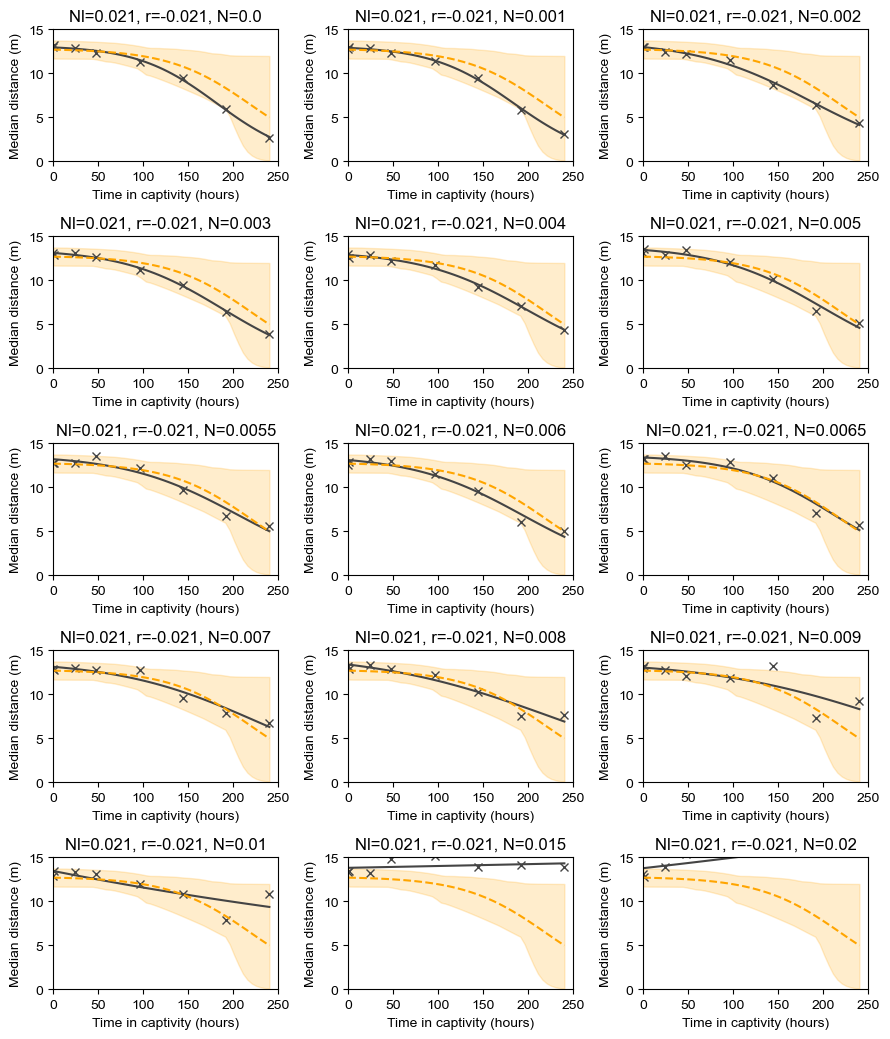

In [14]:
# Plot the median homing distance vs waiting time

plot_show_SD = False
plot_show_CI = True

figsize = (3.8, 2.6)
figsize = (2.3, 1.6)
figsize = (3.0, 2.1)
#figsize = (2.65, 1.85)

#def predict_ant_homing_distance(wait_t):
#    K, Nl, r = 12.79111889, 0.09954786, -0.0220668
#    y_1 = PopulationLoss(wait_t, K, Nl, r)
#    return y_1

#def plot_ant_homing_distance(ax, wait_t):
#    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
#    y_1 = predict_ant_homing_distance(x_1)
#    ax.plot(x_1, y_1, '--', color='grey')

# Create list of dicts specifying the regression function to use for make_plot functions
#regression_func_list = [{'func': func_sigmoid_logistic_modified_2, 'func_str': func_sigmoid_logistic_modified_2_str, 'init_vals': [12.0, 0.0220667871, 0.00784362457]} for i in range(len(wait_noise_sd_values)+1)]
regression_func_list = [{'func': PopulationLoss, 'func_str': PopulationLoss_str, 'init_vals': [12.79111889, 0.09954786, -0.0220668]} for i in range(len(wait_noise_sd_values)+1)]

#"Distance_Median_tocntr" / "Distance_Median_toturn"
ret = plot_data_analysis_3parameters(measure         = "Distance_Median_tocntr",          # Dict key of measure data points to use 
                               wait_noise_sd_values  = wait_noise_sd_values,              # 
                               mem_Nl_values         = mem_Nl_values,                     # 
                               mem_r_values          = mem_r_values,                      # 
                               slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                               squared               = False,                             # Raise the y values to the power or 2
                               inverse               = False,                             # Plot the 1 / y of the data
                               normalise             = False,                             # Normalise data by plotting the y/max(y)
                               y_label               = 'Median distance (m)', 
                               # y_lim               = [None, None],                      # Do not limit the y axis range
                               y_lim                 = [0, 15],                           # Limit the y axis to this range
                               regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                               # common_figure       = None,                              # Plot each plot in a separate figure
                               common_figure         = {'cols': 3},                       # Plot all plots in one figure
                               file_spec_str         = 'homing_distance_vs_waiting_time', # Filename substring to use in the saved figures
                               func_predict          = predict_ant_homing_distance,       # Function for producing target y values
                               func_plot_predictions = plot_ant_homing_distance,          # Function to plot the target y values
                               func_plot_style       = {'color': 'orange','linestyle':'--'} # Colour for plotting the target function
)

if len(ret) == 4:
    fig, axs, cols, rows = ret
    for row in range(rows):
        for col in range(cols): 
            if plot_show_SD: plot_band(axs[row][col], x=x_array_homing_dist, medians=med_array_homing_dist, std_or_CI=std_array_homing_dist, standard_deviations=2, band_color = '#444444', band_color_alpha = 0.2, band_median_color = 'grey', band_median_color_alpha=1.0)
            ##plot_band(axs[row][col], x=x_array_homing_distb, medians=med_array_homing_distb, std_or_CI=std_array_homing_distb, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=1.0)
            if plot_show_CI: plot_band(axs[row][col], x=x_array_homing_dist, medians=med_array_homing_dist, std_or_CI=CI_array_homing_dist, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=0.0)
            ##plot_band(axs[row][col], x=x_array_homing_distb, medians=med_array_homing_distb, std_or_CI=CI_array_homing_distb, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=1.0)
            axs[row][col].set_xlim([0, 250])
    
    fig.tight_layout()
    if save_figures:
        file_spec_str         = 'homing_distance_vs_waiting_time'
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_all_noise_levels' + '_CI' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0


# # Plot the best noise value
# wait_noise_sd_value = 0.0065
# ret = plot_data_analysis_3parameters(measure         = "Distance_Median_tocntr",          # Dict key of measure data points to use 
#                                wait_noise_sd_values  = [wait_noise_sd_value],             # 
#                                mem_Nl_values         = mem_Nl_values,                     # 
#                                mem_r_values          = mem_r_values,                      # 
#                                slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
#                                squared               = False,                             # Raise the y values to the power or 2
#                                inverse               = False,                             # Plot the 1 / y of the data
#                                normalise             = False,                             # Normalise data by plotting the y/max(y)
#                                y_label               = 'Median distance (m)', 
#                                # y_lim               = [None, None],                      # Do not limit the y axis range
#                                y_lim                 = [0, 15],                           # Limit the y axis to this range
#                                regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
#                                # common_figure       = None,                              # Plot each plot in a separate figure
#                                common_figure         = {'cols': 1},                       # Plot all plots in one figure
#                                file_spec_str         = 'homing_distance_vs_waiting_time', # Filename substring to use in the saved figures
#                                func_predict          = predict_ant_homing_distance,       # Function for producing target y values
#                                func_plot_predictions = plot_ant_homing_distance,          # Function to plot the target y values
#                                func_plot_style       = {'color': 'orange'},                 # Colour for plotting the target function
#                                show_title            = False
# )
# 
# if len(ret) == 4:
#     fig, axs, cols, rows = ret
#     plot_band(axs, x=x_array_homing_dist, medians=med_array_homing_dist, std_or_CI=std_array_homing_dist, standard_deviations=2, band_color = '#444444', band_color_alpha = 0.2, band_median_color = 'grey', band_median_color_alpha=1.0)
#     ##plot_band(axs, x=x_array_homing_distb, medians=med_array_homing_distb, std_or_CI=std_array_homing_distb, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=1.0)
#     plot_band(axs, x=x_array_homing_dist, medians=med_array_homing_dist, std_or_CI=CI_array_homing_dist, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=1.0)
#     ##plot_band(axs, x=x_array_homing_distb, medians=med_array_homing_distb, std_or_CI=CI_array_homing_distb, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=1.0)
#     axs.set_xlim([0, 250])
#     
#     fig.tight_layout()
#     if save_figures:
#         file_spec_str         = 'homing_distance_vs_waiting_time'
#         fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_Nl' + str(mem_Nl_values[0]) + '_r' + str(mem_r_values[0]) + '_noise' + str(wait_noise_sd_value) + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0



Logist(t, Nl=0.021, r=-0.021) + N=0.0
MSE = 1.6804071830767346
The fitted curve parameters a*x + b are: 0.04025813997102767 0.4448849443882521
R^2 = 0.8935116421980747

Logist(t, Nl=0.021, r=-0.021) + N=0.001
MSE = 1.4470247913698056
The fitted curve parameters a*x + b are: 0.03794376804639832 0.6868087221445354
R^2 = 0.8864720381106214

Logist(t, Nl=0.021, r=-0.021) + N=0.002
MSE = 0.7316651210968261
The fitted curve parameters a*x + b are: 0.0381032476088482 0.5849730180974497
R^2 = 0.9473566938366907

Logist(t, Nl=0.021, r=-0.021) + N=0.003
MSE = 1.2188884983862436
The fitted curve parameters a*x + b are: 0.04003549426098896 0.44701576558666867
R^2 = 0.924286333330576

Logist(t, Nl=0.021, r=-0.021) + N=0.004
MSE = 1.2659391333865249
The fitted curve parameters a*x + b are: 0.04228858174772254 0.6681608359222728
R^2 = 0.9473820088423971

Logist(t, Nl=0.021, r=-0.021) + N=0.005
MSE = 0.998314725276126
The fitted curve parameters a*x + b are: 0.03989280480731272 0.7811687231248717
R^2

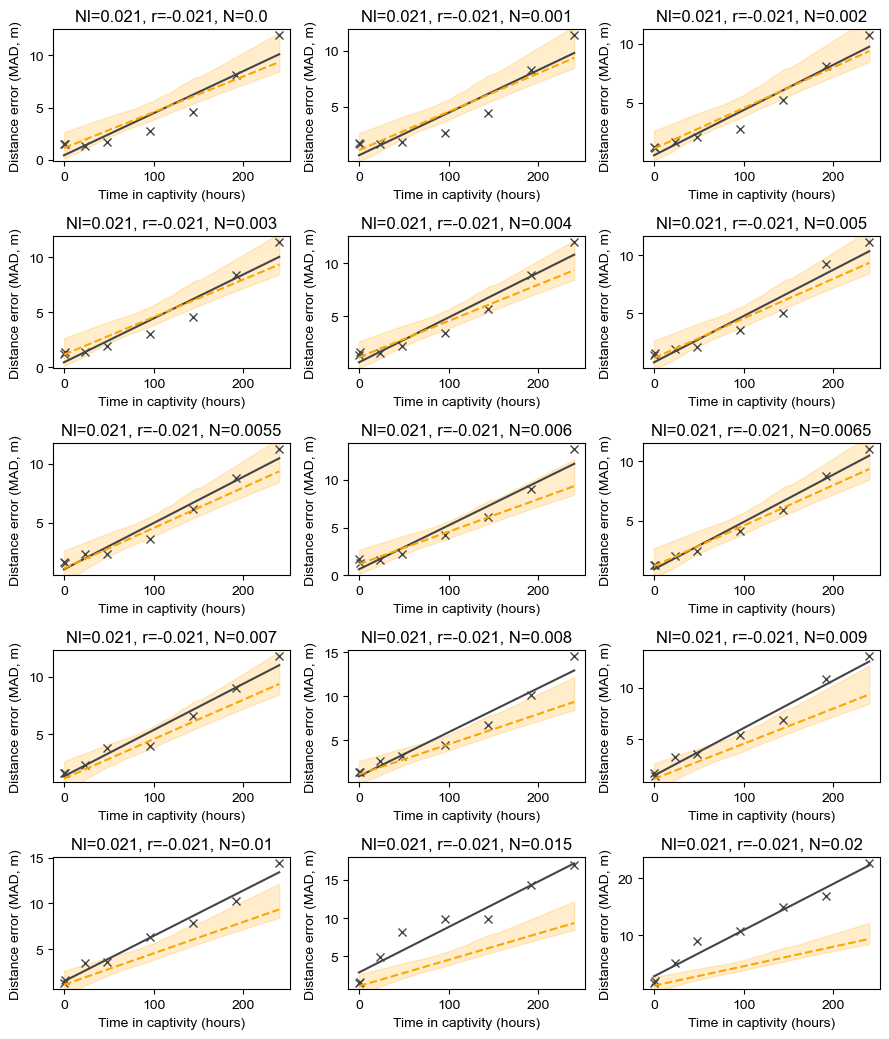

In [15]:
# Plot the homing distance error spread vs waiting time

# Plot the ant data slope
#def plot_ant_homing_distance_error_MAD(ax, wait_t):
#    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
#    y_1 = predict_ant_homing_distance_error_MAD(x_1)
#    ax.plot(x_1, y_1, '--', color='grey')

#def predict_ant_homing_distance_error_MAD(x_1):
#    y_1 = 0.03422619*x_1 + 1.14285714
#    return y_1

# Create list of dicts specifying the regression function to use for make_plot functions
regression_func_list = [{'func': func_line, 'func_str': func_line_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]

# "Distance_to_Nest_Dispersion_tocntr" / "Distance_to_Nest_Dispersion_toturn"
ret = plot_data_analysis_3parameters(measure         = "Distance_to_Nest_Dispersion_tocntr", # Dict key of measure data points to use 
                               wait_noise_sd_values  = wait_noise_sd_values,              # 
                               mem_Nl_values         = mem_Nl_values,                     # 
                               mem_r_values          = mem_r_values,                      # 
                               slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                               squared               = False,                             # Raise the y values to the power or 2
                               inverse               = False,                             # Plot the 1 / y of the data
                               normalise             = False,                             # Normalise data by plotting the y/max(y)
                               y_label               = 'Distance error (MAD, m)', 
                               y_lim                 = [None, None],                      # Do not limit the y axis range
                               #y_lim                 = [0, 15],                          # Limit the y axis to this range
                               regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                               # common_figure       = None,                              # Plot each plot in a separate figure
                               common_figure         = {'cols': 3},                       # Plot all plots in one figure
                               file_spec_str         = 'homing_distance_error_MAD_vs_waiting_time', # Filename substring to use in the saved figures
                               func_predict          = predict_ant_homing_distance_error_MAD,       # Function for producing target y values
                               func_plot_predictions = plot_ant_homing_distance_error_MAD,          # Function to plot the target y values
                               func_plot_style       = {'color': 'orange','linestyle':'--'} # Colour for plotting the target function
)

if len(ret) == 4:
    fig, axs, cols, rows = ret
    for row in range(rows):
        for col in range(cols): 
            if plot_show_SD: plot_band(axs[row][col], x=x_array_MAD, medians=med_array_MAD, std_or_CI=std_array_MAD, standard_deviations=2, band_color = '#444444', band_color_alpha = 0.2, band_median_color = 'grey', band_median_color_alpha=1.0)
            if plot_show_CI: plot_band(axs[row][col], x=x_array_MAD, medians=med_array_MAD, std_or_CI=CI_array_MAD, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=0.0)
    
    fig.tight_layout()
    if save_figures:
        file_spec_str         = 'homing_distance_error_MAD_vs_waiting_time'
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_all_noise_levels' + '_CI' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0




Logist(t, Nl=0.021, r=-0.021) + N=0.0
MSE = 665.169554758247
The fitted curve parameters a*x + b are: 0.4783531627518637 -13.82544274411696
R^2 = 0.760987669655455

Logist(t, Nl=0.021, r=-0.021) + N=0.001
MSE = 492.4153193625954
The fitted curve parameters a*x + b are: 0.445746237883831 -11.940659844465843
R^2 = 0.7779747203105314

Logist(t, Nl=0.021, r=-0.021) + N=0.002
MSE = 274.7372713930438
The fitted curve parameters a*x + b are: 0.4144782944692646 -10.41846921475811
R^2 = 0.8399862550310393

Logist(t, Nl=0.021, r=-0.021) + N=0.003
MSE = 479.9865987948342
The fitted curve parameters a*x + b are: 0.4574533140455306 -12.612111896676609
R^2 = 0.8005154127908202

Logist(t, Nl=0.021, r=-0.021) + N=0.004
MSE = 653.6292436805406
The fitted curve parameters a*x + b are: 0.5138376735890651 -12.96696268055108
R^2 = 0.8329512600206255

Logist(t, Nl=0.021, r=-0.021) + N=0.005
MSE = 433.63027635393166
The fitted curve parameters a*x + b are: 0.46756317951921234 -11.066081022941866
R^2 = 0.843

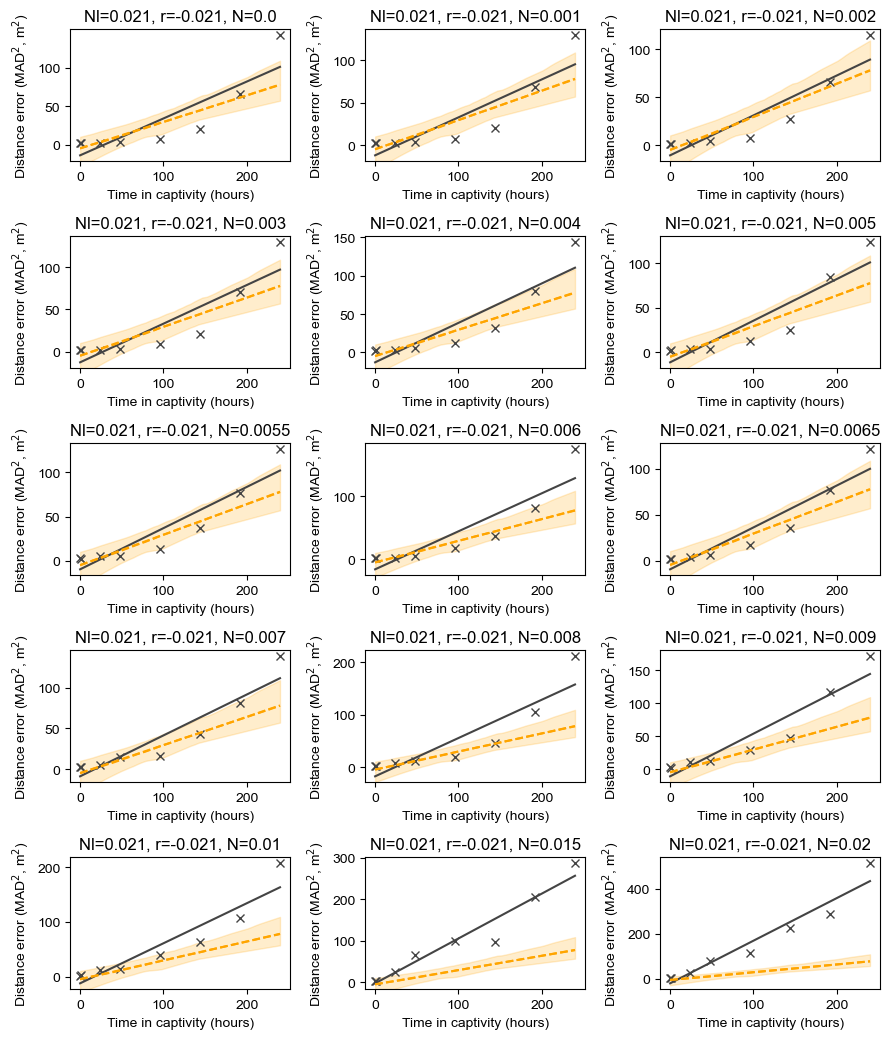

In [16]:
# Plot the homing distance error spread vs waiting time

# Plot the ant data slope
#def plot_ant_homing_distance_error_MAD_squared(ax, wait_t):
#    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
#    y_1 = predict_ant_homing_distance_error_MAD_squared(x_1)
#    ax.plot(x_1, y_1, '--', color='grey')

#def predict_ant_homing_distance_error_MAD_squared(x_1):
#    y_1 = 0.34318452*x_1 - 4.78380962
#    return y_1

# Create list of dicts specifying the regression function to use for make_plot functions
regression_func_list = [{'func': func_line, 'func_str': func_line_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]

# "Distance_to_Nest_Dispersion_tocntr" / "Distance_to_Nest_Dispersion_toturn"
ret = plot_data_analysis_3parameters(measure               = "Distance_to_Nest_Dispersion_tocntr",     # Dict key of measure data points to use 
                               wait_noise_sd_values  = wait_noise_sd_values,              # 
                               mem_Nl_values         = mem_Nl_values,                     # 
                               mem_r_values          = mem_r_values,                      # 
                               slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                               squared               = True,                              # Raise the y values to the power or 2
                               inverse               = False,                             # Plot the 1 / y of the data
                               normalise             = False,                             # Normalise data by plotting the y/max(y)
                               y_label               = 'Distance error (MAD$^2$, m$^2$)', 
                               y_lim                 = [None, None],                      # Do not limit the y axis range
                               #y_lim                 = [0, 15],                          # Limit the y axis to this range
                               regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                               # common_figure       = None,                              # Plot each plot in a separate figure
                               common_figure         = {'cols': 3},                       # Plot all plots in one figure
                               file_spec_str         = 'homing_distance_error_MAD2_vs_waiting_time',  # Filename substring to use in the saved figures
                               func_predict          = predict_ant_homing_distance_error_MAD_squared, # Function for producing target y values
                               func_plot_predictions = plot_ant_homing_distance_error_MAD_squared,    # Function to plot the target y values
                               func_plot_style       = {'color': 'orange','linestyle':'--'} # Colour for plotting the target function
)

if len(ret) == 4:
    fig, axs, cols, rows = ret
    for row in range(rows):
        for col in range(cols): 
            if plot_show_SD: plot_band(axs[row][col], x=x_array_MAD2, medians=med_array_MAD2, std_or_CI=std_array_MAD2, standard_deviations=2, band_color = '#444444', band_color_alpha = 0.2, band_median_color = 'grey', band_median_color_alpha=1.0)
            if plot_show_CI: plot_band(axs[row][col], x=x_array_MAD2, medians=med_array_MAD2, std_or_CI=CI_array_MAD2, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=1.0)

    fig.tight_layout()
    if save_figures:
        file_spec_str         = 'homing_distance_error_MAD2_vs_waiting_time'
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_all_noise_levels' + '_CI' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0




Logist(t, Nl=0.021, r=-0.021) + N=0.0
MSE = 0.03892985777180839
The fitted curve parameters exp(b*x) + c are: -0.006607303978576919 -0.05158758280239515
R^2 = 0.9200225984613313

Logist(t, Nl=0.021, r=-0.021) + N=0.001
MSE = 0.0642546488502313
The fitted curve parameters exp(b*x) + c are: -0.006811070027595827 0.03721159966020663
R^2 = 0.9291326132313836

Logist(t, Nl=0.021, r=-0.021) + N=0.002
MSE = 0.00833802672209548
The fitted curve parameters exp(b*x) + c are: -0.008631111211261566 -0.058660491148788095
R^2 = 0.9795449039324531

Logist(t, Nl=0.021, r=-0.021) + N=0.003
MSE = 0.01644699328945727
The fitted curve parameters exp(b*x) + c are: -0.00825785442932666 -0.03226223629463432
R^2 = 0.9784515635078267

Logist(t, Nl=0.021, r=-0.021) + N=0.004
MSE = 0.01516697066291971
The fitted curve parameters exp(b*x) + c are: -0.007712159035503829 -0.07374206055155486
R^2 = 0.9599661154283388

Logist(t, Nl=0.021, r=-0.021) + N=0.005
MSE = 0.014198475621923464
The fitted curve parameters exp

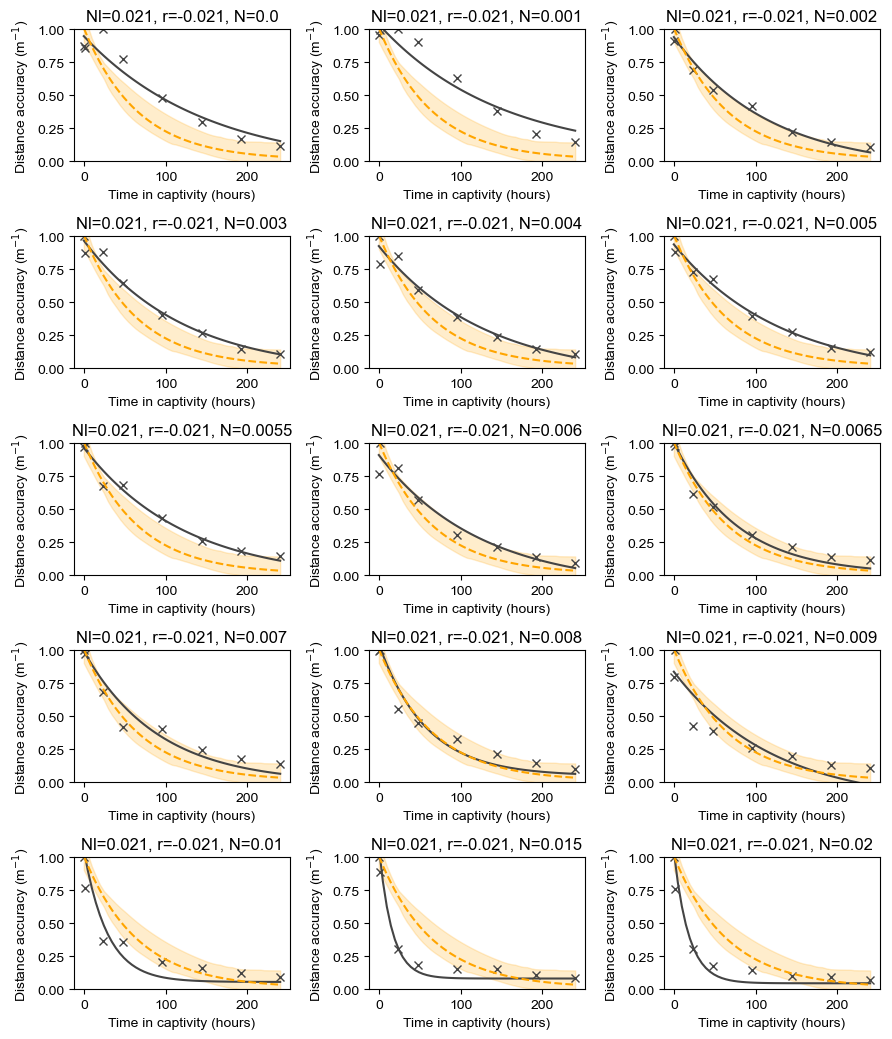

In [17]:
# Plot the homing distance error spread vs waiting time

# Plot the ant data slope
#def plot_ant_homing_distance_accuracy_1_over_MAD(ax, wait_t):
#    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
#    y_1 = predict_ant_homing_distance_accuracy_1_over_MAD(x_1)
#    ax.plot(x_1, y_1, '--', color='grey')

# The model from Ziegler1995
#def predict_ant_homing_distance_accuracy_1_over_MAD(x_1):
#    y_1 = np.exp(-0.41/24*x_1)
#    return y_1

# My better model of the data
#def predict_ant_homing_distance_accuracy_1_over_MAD(x_1):
#    # This is what Ziegler1995 claims
#    y_1 = np.exp(-0.41*x_1/24)
#
#    # 1 parameter model
#    b = -0.35141012542366507
#    y_1 = func_exp1(x_1/24, b)
#
#    # 2 parameters model
#    b, c = [-0.3659817337644034, 0.009440745668943097] # Optimiser found parameters
#    b, c = [-0.46618463692052803, 0.10822417806285799] # Manually set parameters to the b, c of the 3 parameter model
#    y_1 = func_exp2(x_1/24, b, c)
#    
#    # 3 parameters model This is my better regression model, see: analyse_trajectories_step_2_3params.ipynb
#    #a, b, c = [0.7973826267733032, -0.46618463692052803, 0.10822417806285799]
#    #y_1 = func_exp3(x_1/24, a, b, c)
#    
#    return y_1

# Create list of dicts specifying the regression function to use for make_plot functions
#regression_func_list = [{'func': func_exp1, 'func_str': func_exp1_str, 'init_vals': [-0.015]} for i in range(len(wait_noise_sd_values)+1)]
regression_func_list = [{'func': func_exp2, 'func_str': func_exp2_str, 'init_vals': [-0.015, 0.1]} for i in range(len(wait_noise_sd_values)+1)]
#regression_func_list = [{'func': func_exp3, 'func_str': func_exp3_str, 'init_vals': [0.797, -0.02, 0.1]} for i in range(len(wait_noise_sd_values)+1)]

# "Distance_to_Nest_Dispersion_tocntr" / "Distance_to_Nest_Dispersion_toturn"
ret = plot_data_analysis_3parameters(measure         = "Distance_to_Nest_Dispersion_tocntr", # Dict key of measure data points to use 
                               wait_noise_sd_values  = wait_noise_sd_values,              # 
                               mem_Nl_values         = mem_Nl_values,                     # 
                               mem_r_values          = mem_r_values,                      # 
                               slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                               squared               = False,                             # Raise the y values to the power or 2
                               inverse               = True,                              # Plot the 1 / y of the data
                               normalise             = True,                              # Normalise data by plotting the y/max(y)
                               y_label               = 'Distance accuracy (m$^{-1}$)', 
                               #y_lim                 = [None, None],                     # Do not limit the y axis range
                               y_lim                 = [0, 1],                            # Limit the y axis to this range
                               regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                               # common_figure       = None,                              # Plot each plot in a separate figure
                               common_figure         = {'cols': 3},                       # Plot all plots in one figure
                               file_spec_str         = 'homing_distance_accuracy_MAD-1_vs_waiting_time',        # Filename substring to use in the saved figures
                               func_predict          = predict_ant_homing_distance_accuracy_1_over_MAD, # Function for producing target y values
                               func_plot_predictions = plot_ant_homing_distance_accuracy_1_over_MAD,    # Function to plot the target y values
                               func_plot_style       = {'color': 'orange','linestyle':'--'} # Colour for plotting the target function
)

if len(ret) == 4:
    if DRAFT:
        x_array_dist_accuracy, med_array_dist_accuracy, std_array_dist_accuracy, CI_array_dist_accuracy = x_array_dist_accuracy1, med_array_dist_accuracy1, std_array_dist_accuracy1, CI_array_dist_accuracy1
    x_array_dist_accuracy, med_array_dist_accuracy, std_array_dist_accuracy, CI_array_dist_accuracy = x_array_dist_accuracy2, med_array_dist_accuracy2, std_array_dist_accuracy2, CI_array_dist_accuracy2
    #x_array_dist_accuracy, med_array_dist_accuracy, std_array_dist_accuracy = x_array_dist_accuracy3, med_array_dist_accuracy3, std_array_dist_accuracy3
    fig, axs, cols, rows = ret
    for row in range(rows):
        for col in range(cols): 
            if plot_show_SD: plot_band(axs[row][col], x=x_array_dist_accuracy, medians=med_array_dist_accuracy, std_or_CI=std_array_dist_accuracy, standard_deviations=2, band_color = '#444444', band_color_alpha = 0.2, band_median_color = 'grey', band_median_color_alpha=1.0)
            if plot_show_CI: plot_band(axs[row][col], x=x_array_dist_accuracy, medians=med_array_dist_accuracy, std_or_CI=CI_array_dist_accuracy, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=0.0)

    fig.tight_layout()
    if save_figures:
        file_spec_str         = 'homing_distance_accuracy_MAD-1_vs_waiting_time'
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_all_noise_levels' + '_CI' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0




Logist(t, Nl=0.021, r=-0.021) + N=0.0
MSE = 0.1292367163622462
Exception: Issue plotting for Logist(t, Nl=0.021, r=-0.021) + N=0.0

Logist(t, Nl=0.021, r=-0.021) + N=0.001
MSE = 0.13719702115928395
Exception: Issue plotting for Logist(t, Nl=0.021, r=-0.021) + N=0.001

Logist(t, Nl=0.021, r=-0.021) + N=0.002
MSE = 0.038659312650293653
The fitted curve parameters a * exp(b*x) + c are: 1.5785151181394346 -0.00302203446143585 -0.6629519162681772
R^2 = 0.9725785137082906

Logist(t, Nl=0.021, r=-0.021) + N=0.003
MSE = 0.0299872521681386
The fitted curve parameters a * exp(b*x) + c are: 1.2519097105282149 -0.004602964876660207 -0.3247236146054895
R^2 = 0.9669564987381222

Logist(t, Nl=0.021, r=-0.021) + N=0.004
MSE = 0.032723622096078445
The fitted curve parameters a * exp(b*x) + c are: 1.3909683621356754 -0.00458244647695717 -0.42030603892318136
R^2 = 0.9877240018757923

Logist(t, Nl=0.021, r=-0.021) + N=0.005
MSE = 0.0174842119446744
The fitted curve parameters a * exp(b*x) + c are: 0.9290

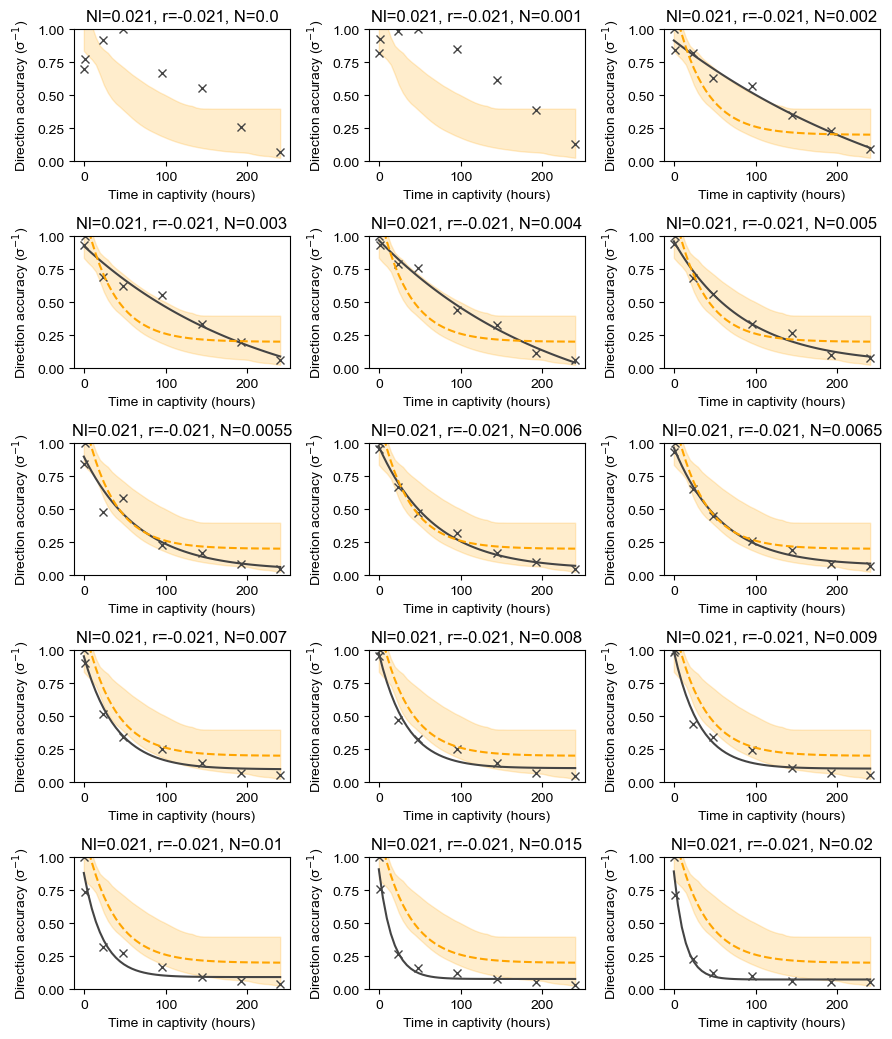

In [18]:
# Plot homing direction dispersion vs waiting time

# Plot the ant data slope
#def plot_ant_homing_angle_accuracy_1_over_sigma_squared(ax, wait_t):
#    x_1 = np.linspace(np.min(wait_t), np.max(wait_t))
#    y_1 = predict_ant_homing_angle_accuracy_1_over_sigma_squared(x_1)
#    ax.plot(x_1, y_1, '--', color='grey')

# Model of the data
#def predict_ant_homing_angle_accuracy_1_over_sigma_squared(x_1):
#    # This is what Ziegler1995 claims
#    y_1 = np.exp(-0.23/24*x_1)
#    
#    # 1 parameter model
#    b = -0.22712638972154658 # R^2 = 0.7165837920105825
#    y_1 = func_exp1(x_1/24, b)
#    
#    # 2 parameters model
#    b, c = [-0.6713943442561833, 0.2008628721736255] # R^2 = 0.7163794674438515
#    y_1 = func_exp2(x_1/24, b, c)
#    
#    # 3 parameters model
#    #a, b, c = [0.6832929060666405, -0.6139620623345058, 0.2763541594080284] # R^2 = 0.9111461097341679
#    #y_1 = func_exp3(x_1/24, a, b, c)
#    
#    return y_1

# Create list of dicts specifying the regression function to use for make_plot functions
regression_func_list = [{'func': func_exp1, 'func_str': func_exp1_str, 'init_vals': [-0.01]} for i in range(len(wait_noise_sd_values)+1)]
regression_func_list = [{'func': func_exp2, 'func_str': func_exp2_str, 'init_vals': [-0.03, 0.20]} for i in range(len(wait_noise_sd_values)+1)] # Bad matches to the data points
regression_func_list = [{'func': func_exp3, 'func_str': func_exp3_str, 'init_vals': [0.68, -0.02, 0.28]} for i in range(len(wait_noise_sd_values)+1)]

# Model Option 2:
# My better model of the data
#def predict_ant_homing_angle_accuracy_1_over_sigma_squared(x_1):
#    # This is what Ziegler1995 claims
#    y_1 = np.exp(-0.23*x_1/24)
#    # This is my better regression model, see: analyse_trajectories_step_2_3params.ipynb
#    a, b, c = [0.6832929060666405, -0.6139620623345058, 0.2763541594080284]
#    y_1 = func_exp3(x_1/24, a, b, c)
#    return y_1
## Create list of dicts specifying the regression function to use for make_plot functions
#regression_func_list = [{'func': func_exp3, 'func_str': func_exp3_str, 'init_vals': [0.9534428534724233, -0.008174683584213709, -0.01770231017532992]} for i in range(len(wait_noise_sd_values)+1)]

# "Angle_Dispersion_tocntr" / "Angle_Dispersion_toturn"
ret = plot_data_analysis_3parameters(measure         = "Angle_Dispersion_tocntr",         # Dict key of measure data points to use 
                               wait_noise_sd_values  = wait_noise_sd_values,              # 
                               mem_Nl_values         = mem_Nl_values,                     # 
                               mem_r_values          = mem_r_values,                      # 
                               slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                               squared               = False,                             # Raise the y values to the power or 2
                               inverse               = True,                              # Plot the 1 / y of the data
                               normalise             = True,                              # Normalise data by plotting the y/max(y)
                               y_label               = 'Direction accuracy (σ$^{-1}$)', 
                               #y_lim                 = [None, None],                      # Do not limit the y axis range
                               y_lim                 = [0, 1],                          # Limit the y axis to this range
                               regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                               # common_figure       = None,                              # Plot each plot in a separate figure
                               common_figure         = {'cols': 3},                       # Plot all plots in one figure
                               file_spec_str         = 'homing_angle_accuracy_sigma-1_vs_waiting_time',        # Filename substring to use in the saved figures
                               func_predict          = predict_ant_homing_angle_accuracy_1_over_sigma_squared, # Function for producing target y values
                               func_plot_predictions = plot_ant_homing_angle_accuracy_1_over_sigma_squared,    # Function to plot the target y values
                               func_plot_style       = {'color': 'orange','linestyle':'--'} # Colour for plotting the target function
)

if len(ret) == 4:
    if DRAFT:
        x_array_dir_accuracy, med_array_dir_accuracy, std_array_dir_accuracy, CI_array_dir_accuracy = x_array_dir_accuracy1, med_array_dir_accuracy1, std_array_dir_accuracy1, CI_array_dir_accuracy1
    x_array_dir_accuracy, med_array_dir_accuracy, std_array_dir_accuracy, CI_array_dir_accuracy = x_array_dir_accuracy2, med_array_dir_accuracy2, std_array_dir_accuracy2, CI_array_dir_accuracy2
    #x_array_dir_accuracy, med_array_dir_accuracy, std_array_dir_accuracy, CI_array_dir_accuracy = x_array_dir_accuracy3, med_array_dir_accuracy3, std_array_dir_accuracy3, CI_array_dir_accuracy3
    fig, axs, cols, rows = ret
    for row in range(rows):
        for col in range(cols): 
            if plot_show_SD: plot_band(axs[row][col], x=x_array_dir_accuracy, medians=med_array_dir_accuracy, std_or_CI=std_array_dir_accuracy, standard_deviations=2, band_color = '#444444', band_color_alpha = 0.2, band_median_color = 'grey', band_median_color_alpha=1.0)
            if plot_show_CI: plot_band(axs[row][col], x=x_array_dir_accuracy, medians=med_array_dir_accuracy, std_or_CI=CI_array_dir_accuracy, standard_deviations=1, band_color = 'orange', band_color_alpha = 0.2, band_median_color = 'orange', band_median_color_alpha=0.0)

    fig.tight_layout()
    if save_figures:
        file_spec_str         = 'homing_angle_accuracy_sigma-1_vs_waiting_time'
        fig.savefig(images_path + 'simulated_fullRelease_' + file_spec_str + '_all_noise_levels' + '_CI' + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0



The fitted curve parameters K / (1 + Nl/(K - Nl) * np.exp(-r * t)) are: 72646.83466309545 72633.75343823325 0.019915583886237688
R^2 = 0.8154578356430322
t       : [0, 1, 24, 48, 96, 144, 192, 240]
Ants MAD: [1.6, 'N/A', 2.2, 3.7, 8.1, 5.6, 4.0]
Sim  MAD: [0.8000 0.6000 0.9000 1.8000 1.6000 3.6000 4.1000 4.5000]
The fitted curve parameters a*x + b are: 0.016876313653919173 0.6651807424773043
R^2 = 0.9453220509935694
std: [1.3009 1.2939 1.5107 2.9087 2.5829 4.7774 5.0933 6.2326]
The fitted curve parameters a*x + b are: 0.0206055748109618 1.2936481255815253
R^2 = 0.9521700209777124

Logist(t, Nl=0.0, r=-0.008) + N=0.008
MSE = 0.2544933852377771
The fitted curve parameters a*x + b are: 0.030481368042678682 1.4723697277403078
R^2 = 0.9778181739950444

Logist(t, Nl=0.0, r=-0.008) + N=0.008
MSE = 37.58762063245074
The fitted curve parameters a*x + b are: 0.28751648401670193 -1.3114599435730034
R^2 = 0.9799876199746801

Logist(t, Nl=0.0, r=-0.008) + N=0.008
MSE = 0.007373807219624063
The fitt

/Users/john/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/Path_Integration_Simulations/ant_behaviour_measures_models.py:13: RuntimeWarning: overflow encountered in exp
  return K / (1 + Nl/(K - Nl) * np.exp(-r * t))
/Users/john/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/Path_Integration_Simulations/ant_behaviour_measures_models.py:13: RuntimeWarning: overflow encountered in exp
  return K / (1 + Nl/(K - Nl) * np.exp(-r * t))


The fitted curve parameters K / (1 + Nl/(K - Nl) * np.exp(-r * t)) are: 13.578270783600509 0.041313490768598866 -0.8990952225096873
R^2 = 0.9619013982355775
t       : [0, 1, 24, 48, 96, 144, 192, 240]
Ants MAD: [1.6, 'N/A', 2.2, 3.7, 8.1, 5.6, 4.0]
Sim  MAD: [1.0000 0.8000 1.1000 1.2000 1.5000 2.0000 2.3000 1.8000]
The fitted curve parameters a*x + b are: 0.005063195285888389 1.0053911992350941
R^2 = 0.7782396576100589
std: [1.2003 1.2231 1.9461 1.7755 2.8396 3.5428 3.5151 3.0940]
The fitted curve parameters a*x + b are: 0.009518255937432163 1.5056785614367678
R^2 = 0.7897824565229248

Logist(t, Nl=0.021, r=-0.021) + N=0.0065
MSE = 0.5294767347364544
The fitted curve parameters a*x + b are: 0.04005261627635548 0.8713900390227264
R^2 = 0.9822234673009386

Logist(t, Nl=0.021, r=-0.021) + N=0.0065
MSE = 315.1693857181943
The fitted curve parameters a*x + b are: 0.4573611968068154 -9.595424594186957
R^2 = 0.8901429728331354

Logist(t, Nl=0.021, r=-0.021) + N=0.0065
MSE = 0.0040851965031725

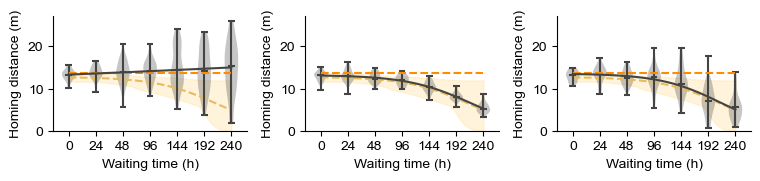

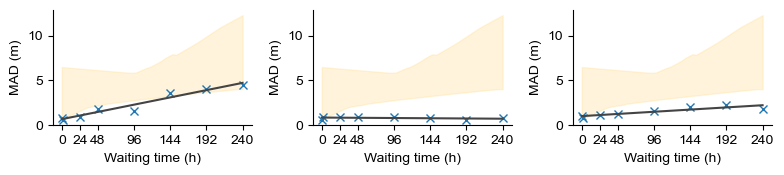

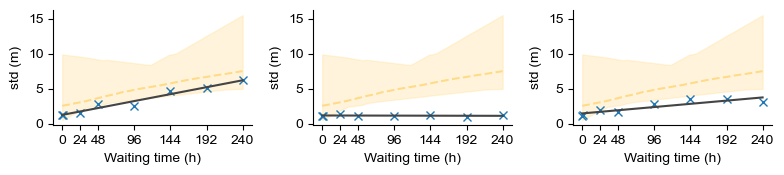

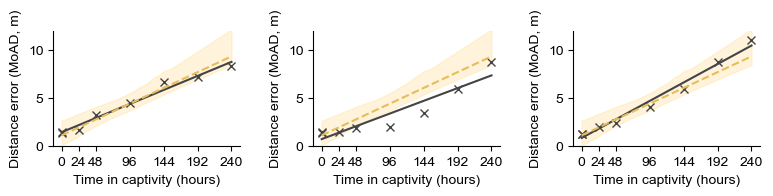

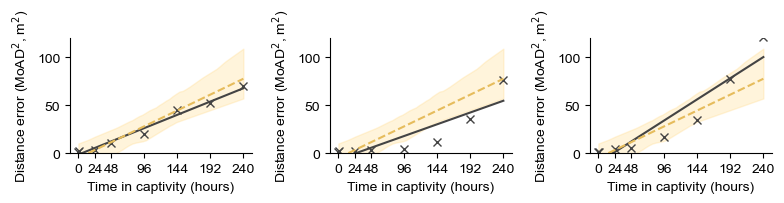

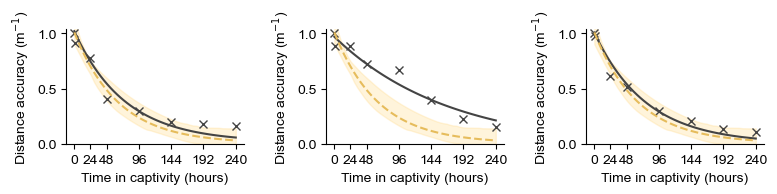

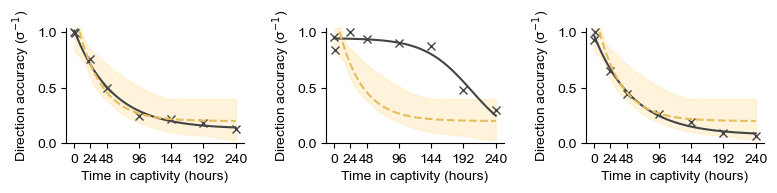

In [42]:
# Plot the homing distance data point spread vs waiting time

plot_style = {
    "axes.spines.top"    : False, 
    "axes.spines.right"  : False, 
}
plt.rcParams.update(plot_style) # Update the style

figsize = (3.8, 2.6)
figsize = (2.3, 1.6)
figsize = (3.0, 2.1)

figsize = (2.65, 1.85)


plot_show_SD = False
plot_show_CI = True
orange_2 = '#ff8c00' # The proper orange, nice for the dashed line and start and end of paths 
orange_3 = '#d6b295' # Nice light brown, nice hue for the CI bands
orange_7 = '#cc7100' # The proper orange but darker, nice hue for the CI bands
creme    = '#FFDB89' # Nice light creme, nice hue for the CI bands
darkcreme = '#E6BC5C' # Darker verion of the light creme, nice hue for the CI bands

SD_band_color = '#444444'
CI_band_color = orange_3 # orange_7
All_points_fit_color = CI_band_color
CI_band_color = creme # orange_3 # orange_7
All_points_fit_style = dict(color=darkcreme, alpha=1.0, linestyle='--')
#CI_band_color = '#444444'
band_color_alpha = 0.3

# Use only the first 8 wait_t times
slice_max = 8 # 11 to include all wait_t times (up to 400h)

def make_plot_violin(ax, wait_t, search_distance_data, filename_extra_str, color=orange_2):
    #fig, ax = plt.subplots(1, 1, figsize=figsize)
    violin_parts = ax.violinplot(search_distance_data, showmedians=True)
    
    # Make the violin body grey with a grey border:
    for vp in violin_parts['bodies']:
        vp.set_facecolor('#444444')
        #vp.set_edgecolor('#444444')
        #vp.set_linewidth(1)
        vp.set_alpha(0.3)

    # Make all the violin statistics marks grey:
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('#444444')
        #vp.set_linewidth(1)
    
    
    # Plot the nominal outbound distance
    ax.hlines(outbound_distance, 1, len(wait_t), linestyles='dashed', color=color)

    ax.set_xticks(np.arange(1, len(wait_t) + 1))
    ax.set_xticklabels(wait_t)

    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('Homing distance (m)')

    #if save_figures:
    #    fig.savefig(images_path + 'simulated_fullRelease_' + 'homing_distance_vs_waiting_time_violin' + filename_extra_str + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    return ax

def func_pow(x, a, b):
    return a*x**2 + b

figs = []
axs = []
for i in range(7):
    if i == 0:
        figsize = (2.57, 1.85)
    else:
        figsize = (2.65, 1.85)
    fig_i, axs_i = plt.subplots(1, 3, figsize=(figsize[0]*3, figsize[1]), sharey=True)
    figs.append(fig_i)
    axs.append(axs_i)


def showHomingDistanceViolinPlot(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values, file_substr = ''):
    # Get the data
    wait_t               = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Wait"][0:slice_t_max]
    search_distance_data = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Distance_hypot"][0:slice_t_max]
    
    # Remove the second element (1h)
    wait_t               = [elem for i,elem in enumerate(wait_t) if i != 1]
    search_distance_data = [elem for i,elem in enumerate(search_distance_data) if i != 1]

    # Show the STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_homing_dist*(len(wait_t)-1)/240+1, medians=med_array_homing_dist, std_or_CI=std_array_homing_dist, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=0.0)
    if plot_show_CI: plot_band(ax, x=x_array_homing_dist*(len(wait_t)-1)/240+1, medians=med_array_homing_dist, std_or_CI=CI_array_homing_dist, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)
    
    # Plot the fit to the ant data
    ax.plot(x_array_homing_dist*(len(wait_t)-1)/240+1, predict_ant_homing_distance(x_array_homing_dist), **All_points_fit_style)

    # Show Homing distance vs waiting time
    ax = make_plot_violin(ax, wait_t, search_distance_data, file_substr)
    median_distance_hypot = np.median(search_distance_data, axis=1)
    #fit_data_points(ax, range(1, len(wait_t)+1), median_distance_hypot, func_line, func_str='a*x + b', init_vals=None, style={'color': '#444444'})
    fit_data_points(ax, range(1, len(wait_t)+1), median_distance_hypot, PopulationLoss, func_str=PopulationLoss_str, init_vals=[12.79111889, 0.09954786, -0.0220668], style={'color': '#444444'})
    #plt.ylim([0, 25])
    ax.set_ylim([0, None])

def showHomingDistanceMAD(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values):
    # Show the MAD STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_homing_distance_MAD, medians=med_array_homing_distance_MAD, std_or_CI=std_array_homing_distance_MAD, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_homing_distance_MAD, medians=med_array_homing_distance_MAD, std_or_CI=CI_array_homing_distance_MAD, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)

    wait_t               = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Wait"][0:slice_t_max]
    search_distance_data = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Distance_hypot"][0:slice_t_max]
    #MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)

    MAD = []
    median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
    for i in range(len(median_search_distance_data)):
        MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
    # t_2 = np.array([0, 48, 96, 144, 192, 240 ])
    # y_2 = np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
    print('t       :', wait_t)
    print('Ants MAD:', [1.6, 'N/A', 2.2, 3.7, 8.1, 5.6, 4.0])
    print('Sim  MAD:', np.around(MAD, decimals=1))
    ax.plot(wait_t, MAD, 'x')
    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('MAD (m)')
    fit_data_points(ax, wait_t, MAD, func_line, func_str='a*x + b', init_vals=None, style={'color': '#444444'})
    #ax.set_ylim([0, 8])

    # Plot the fit to the ant data
    #plt.plot(x_array_homing_dist, predict_ant_homing_distance_error_MAD(x_array_homing_dist))

def showHomingDistanceMADsquared(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values):
    # Show the MAD2 STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_homing_distance_MAD2, medians=med_array_homing_distance_MAD2, std_or_CI=std_array_homing_distance_MAD2, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_homing_distance_MAD2, medians=med_array_homing_distance_MAD2, std_or_CI=CI_array_homing_distance_MAD2, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)

    wait_t               = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Wait"][0:slice_t_max]
    search_distance_data = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Distance_hypot"][0:slice_t_max]
    #MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)

    MAD = []
    median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
    for i in range(len(median_search_distance_data)):
        MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
    MAD2 = np.array(MAD)**2
    ax.plot(wait_t, MAD2, 'x')
    ax.set_title('Only random noise')
    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('MAD$^2$ (m$^2$)')
    fit_data_points(ax, wait_t, MAD2, func_line, func_str='a*x + b', init_vals=None, style={'color': '#444444'})
    #ax.set_ylim([0, 8])

    # Plot the fit to the ant data
    #plt.plot(x_array_homing_dist, predict_ant_homing_distance_error_MAD_squared(x_array_homing_dist)

def showHomingDistanceSTD(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values):
    # Show the VAR STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_homing_distance_STD, medians=med_array_homing_distance_STD, std_or_CI=std_array_homing_distance_STD, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_homing_distance_STD, medians=med_array_homing_distance_STD, std_or_CI=CI_array_homing_distance_STD, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=1.0)

    wait_t               = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Wait"][0:slice_t_max]
    search_distance_data = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Distance_hypot"][0:slice_t_max]
    #MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)
    #MAD = []
    #median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
    #for i in range(len(median_search_distance_data)):
    #    MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
    #var = MAD2variance(np.array(MAD))
    #std = np.sqrt(var)

    std = np.std(np.array(search_distance_data), axis=1)
    print('std:', std)
    ax.plot(wait_t, std, 'x')
    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('std (m)')
    fit_data_points(ax, wait_t, std, func_line, func_str='a*x + b', init_vals=None, style={'color': '#444444'})
    #ax.set_ylim([0, 8])

def showHomingDistanceVAR(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values):
    # Show the VAR STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_homing_distance_VAR, medians=med_array_homing_distance_VAR, std_or_CI=std_array_homing_distance_VAR, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_homing_distance_VAR, medians=med_array_homing_distance_VAR, std_or_CI=CI_array_homing_distance_VAR, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=1.0)

    wait_t               = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Wait"][0:slice_t_max]
    search_distance_data = search_dispersion_list[wait_noise_sd_value[0]][mem_Nl_values[0]][mem_r_values[0]]["Distance_hypot"][0:slice_t_max]
    #MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)
    #MAD = []
    #median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
    #for i in range(len(median_search_distance_data)):
    #    MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
    #var = MAD2variance(np.array(MAD))

    var = np.var(np.array(search_distance_data), axis=1)
    ax.plot(wait_t, var, 'x')
    ax.set_xlabel('Waiting time (h)')
    ax.set_ylabel('Var (m$^2$)')
    fit_data_points(ax, wait_t, var, func_line, func_str='a*x + b', init_vals=None, style={'color': '#444444'})
    #ax.set_ylim([0, 8])


def showMofAD(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values):
    # Show the STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_MAD, medians=med_array_MAD, std_or_CI=std_array_MAD, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_MAD, medians=med_array_MAD, std_or_CI=CI_array_MAD, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)

    # Create list of dicts specifying the regression function to use for make_plot functions
    regression_func_list = [{'func': func_line, 'func_str': func_line_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
    
    ret = plot_data_analysis_3parameters(measure         = "Distance_to_Nest_Dispersion_tocntr", # Dict key of measure data points to use 
                                   wait_noise_sd_values  = wait_noise_sd_value,             # 
                                   mem_Nl_values         = mem_Nl_values,                     # 
                                   mem_r_values          = mem_r_values,                      # 
                                   slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                                   squared               = False,                             # Raise the y values to the power or 2
                                   inverse               = False,                             # Plot the 1 / y of the data
                                   normalise             = False,                             # Normalise data by plotting the y/max(y)
                                   y_label               = 'Distance error (MoAD, m)', 
                                   #y_label               = 'Distance error, Median of Abs. Dev. (m)', 
                                   y_lim                 = [None, None],                      # Do not limit the y axis range
                                   #y_lim                 = [0, 15],                          # Limit the y axis to this range
                                   regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                                   # common_figure       = None,                              # Plot each plot in a separate figure
                                   axis                  = ax, 
                                   common_figure         = None,                              # Plot all plots in one figure
                                   file_spec_str         = 'homing_distance_error_MAD_vs_waiting_time', # Filename substring to use in the saved figures
                                   func_predict          = predict_ant_homing_distance_error_MAD,       # Function for producing target y values
                                   func_plot_predictions = plot_ant_homing_distance_error_MAD,          # Function to plot the target y values
                                   func_plot_style       = All_points_fit_style,                                   # Colour for plotting the target function
                                   show_title            = False
    )

    ax.set_ylim([0, 12])


def showMofADsquared(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values):
    # Show the STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_MAD2, medians=med_array_MAD2, std_or_CI=std_array_MAD2, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_MAD2, medians=med_array_MAD2, std_or_CI=CI_array_MAD2, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)

    # Create list of dicts specifying the regression function to use for make_plot functions
    regression_func_list = [{'func': func_line, 'func_str': func_line_str, 'init_vals': None} for i in range(len(wait_noise_sd_values)+1)]
    
    ret = plot_data_analysis_3parameters(measure               = "Distance_to_Nest_Dispersion_tocntr",     # Dict key of measure data points to use 
                                   wait_noise_sd_values  = wait_noise_sd_value,             # 
                                   mem_Nl_values         = mem_Nl_values,                     # 
                                   mem_r_values          = mem_r_values,                      # 
                                   slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                                   squared               = True,                              # Raise the y values to the power or 2
                                   inverse               = False,                             # Plot the 1 / y of the data
                                   normalise             = False,                             # Normalise data by plotting the y/max(y)
                                   y_label               = 'Distance error (MoAD$^2$, m$^2$)', 
                                   #y_label               = 'Distance error, Median of Abs. Dev. sq. (m$^2$)', 
                                   y_lim                 = [None, None],                      # Do not limit the y axis range
                                   #y_lim                 = [0, 15],                          # Limit the y axis to this range
                                   regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                                   # common_figure       = None,                              # Plot each plot in a separate figure
                                   axis                  = ax,
                                   common_figure         = None,                       # Plot all plots in one figure
                                   file_spec_str         = 'homing_distance_error_MAD2_vs_waiting_time',  # Filename substring to use in the saved figures
                                   func_predict          = predict_ant_homing_distance_error_MAD_squared, # Function for producing target y values
                                   func_plot_predictions = plot_ant_homing_distance_error_MAD_squared,    # Function to plot the target y values
                                   func_plot_style       = All_points_fit_style,                                   # Colour for plotting the target function
                                   show_title            = False
    )
    
def showDistanceAccuracy(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values, regression_func_list=None):
    # Show the STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_dist_accuracy, medians=med_array_dist_accuracy, std_or_CI=std_array_dist_accuracy, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_dist_accuracy, medians=med_array_dist_accuracy, std_or_CI=CI_array_dist_accuracy, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)

    if regression_func_list is None:
        regression_func_list = [{'func': func_exp2, 'func_str': func_exp2_str, 'init_vals': [-0.015, 0.1]} for i in range(len(wait_noise_sd_values)+1)]
    
    ret = plot_data_analysis_3parameters(measure         = "Distance_to_Nest_Dispersion_tocntr", # Dict key of measure data points to use 
                                   wait_noise_sd_values  = wait_noise_sd_value,             # 
                                   mem_Nl_values         = mem_Nl_values,                     # 
                                   mem_r_values          = mem_r_values,                      # 
                                   slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                                   squared               = False,                             # Raise the y values to the power or 2
                                   inverse               = True,                              # Plot the 1 / y of the data
                                   normalise             = True,                              # Normalise data by plotting the y/max(y)
                                   y_label               = 'Distance accuracy (m$^{-1}$)', 
                                   #y_lim                 = [None, None],                     # Do not limit the y axis range
                                   #y_lim                 = [0, 1],                            # Limit the y axis to this range
                                   #y_lim                 = [0, None],                            # Limit the y axis to this range
                                   y_lim                 = [0, 1.04],                            # Limit the y axis to this range
                                   regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                                   # common_figure       = None,                              # Plot each plot in a separate figure
                                   axis                  = ax,
                                   common_figure         = None,                       # Plot all plots in one figure
                                   file_spec_str         = 'homing_distance_accuracy_MAD-1_vs_waiting_time',        # Filename substring to use in the saved figures
                                   func_predict          = predict_ant_homing_distance_accuracy_1_over_MAD, # Function for producing target y values
                                   func_plot_predictions = plot_ant_homing_distance_accuracy_1_over_MAD,    # Function to plot the target y values
                                   func_plot_style       = All_points_fit_style,                                   # Colour for plotting the target function
                                   show_title            = False
    )


def showDirectionAccuracy(ax, wait_noise_sd_value, mem_Nl_values, mem_r_values, regression_func_list=None):
    # Show the STD and CI bands
    if plot_show_SD: plot_band(ax, x=x_array_dir_accuracy, medians=med_array_dir_accuracy, std_or_CI=std_array_dir_accuracy, standard_deviations=2, band_color = '#444444', band_color_alpha = band_color_alpha, band_median_color = 'grey', band_median_color_alpha=1.0)
    if plot_show_CI: plot_band(ax, x=x_array_dir_accuracy, medians=med_array_dir_accuracy, std_or_CI=CI_array_dir_accuracy, standard_deviations=1, band_color = CI_band_color, band_color_alpha = band_color_alpha, band_median_color = CI_band_color, band_median_color_alpha=0.0)

    # Create list of dicts specifying the regression function to use for make_plot functions
    if regression_func_list is None:
        regression_func_list = [{'func': func_exp1, 'func_str': func_exp1_str, 'init_vals': [-0.01]} for i in range(len(wait_noise_sd_values)+1)]
        regression_func_list = [{'func': func_exp2, 'func_str': func_exp2_str, 'init_vals': [-0.03, 0.20]} for i in range(len(wait_noise_sd_values)+1)] # Bad matches to the data points
        regression_func_list = [{'func': func_exp3, 'func_str': func_exp3_str, 'init_vals': [0.68, -0.02, 0.28]} for i in range(len(wait_noise_sd_values)+1)]
    
    ret = plot_data_analysis_3parameters(measure         = "Angle_Dispersion_tocntr",         # Dict key of measure data points to use 
                                   wait_noise_sd_values  = wait_noise_sd_value,             # 
                                   mem_Nl_values         = mem_Nl_values,                     # 
                                   mem_r_values          = mem_r_values,                      # 
                                   slice_t_max           = slice_t_max,                       # Use only the first 8 wait_t times, use 11 to include all wait_t times (up to 400h), 8 to include up to 240h
                                   squared               = False,                             # Raise the y values to the power or 2
                                   inverse               = True,                              # Plot the 1 / y of the data
                                   normalise             = True,                              # Normalise data by plotting the y/max(y)
                                   y_label               = 'Direction accuracy (σ$^{-1}$)', 
                                   #y_lim                 = [None, None],                      # Do not limit the y axis range
                                   #y_lim                 = [0, 1],                          # Limit the y axis to this range
                                   #y_lim                 = [0, None],                          # Limit the y axis to this range
                                   y_lim                 = [0, 1.04],                            # Limit the y axis to this range
                                   regression_func_list  = regression_func_list,              # list of dicts specifying the regression function to use for make_plot functions
                                   # common_figure       = None,                              # Plot each plot in a separate figure
                                   axis                  = ax, 
                                   common_figure         = None,                       # Plot all plots in one figure
                                   file_spec_str         = 'homing_angle_accuracy_sigma-1_vs_waiting_time',        # Filename substring to use in the saved figures
                                   func_predict          = predict_ant_homing_angle_accuracy_1_over_sigma_squared, # Function for producing target y values
                                   func_plot_predictions = plot_ant_homing_angle_accuracy_1_over_sigma_squared,    # Function to plot the target y values
                                   func_plot_style       = All_points_fit_style,                                   # Colour for plotting the target function
                                   show_title            = False
    )


filename_substr = []
# Show plots Only random noise (diffusion dynamics)
# =================================================
# Load the data points
wait_noise_sd_value = ['0.0055']
wait_noise_sd_value = ['0.008']
mem_Nl_values = ['0.0']
mem_r_values = ['-0.008']
# Show Homing distance vs waiting time
showHomingDistanceViolinPlot(axs[0][0], wait_noise_sd_value, mem_Nl_values, mem_r_values, file_substr = '_withDiffusion')
if not save_figures:
    axs[0][0].set_title('Diffusion only ' + str(wait_noise_sd_value[0]))
# Show MAD of homing distance
showHomingDistanceMAD(axs[1][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
# Show MAD2
#showHomingDistanceMADsquared(axs[2][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showHomingDistanceSTD(axs[2][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
#showHomingDistanceVAR(axs[2][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showMofAD(axs[3][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showMofADsquared(axs[4][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
axs[4][0].set_ylim([0,120])
regression_func_list_1 = [{'func': func_exp2, 'func_str': func_exp2_str, 'init_vals': [-0.02, 0.1]} for i in range(len(wait_noise_sd_values)+1)]
showDistanceAccuracy(axs[5][0], wait_noise_sd_value, mem_Nl_values, mem_r_values, regression_func_list=regression_func_list_1)
showDirectionAccuracy(axs[6][0], wait_noise_sd_value, mem_Nl_values, mem_r_values)
filename_substr = filename_substr + wait_noise_sd_value + mem_Nl_values + mem_r_values

# Show plots Only logistic decay (no noise)
# =========================================
# Load the data points
# For noise=0.0 the minimum homing distance MSE for the simulation data is for Nl=0.02, r=-0.018, MSE=0.091 and Nl=0.022, r=-0.017, MSE=0.096
wait_noise_sd_value = ['0.0']
mem_Nl_values = ['0.02']
mem_r_values = ['-0.018']
# Show Homing distance vs waiting time
showHomingDistanceViolinPlot(axs[0][1], wait_noise_sd_value, mem_Nl_values, mem_r_values, file_substr = '_withLogisticLoss')
if not save_figures:
    axs[0][1].set_title('Logistic only')
# Show MAD of homing distance
showHomingDistanceMAD(axs[1][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
# Show MAD2
#showHomingDistanceMADsquared(axs[2][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showHomingDistanceSTD(axs[2][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
#showHomingDistanceVAR(axs[2][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showMofAD(axs[3][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showMofADsquared(axs[4][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
axs[4][1].set_ylim([0,120])
showDistanceAccuracy(axs[5][1], wait_noise_sd_value, mem_Nl_values, mem_r_values)
regression_func_list_1 = [{'func': PopulationLoss, 'func_str': PopulationLoss_str, 'init_vals': [12.79111889, 0.09954786, -0.0220668]}]
showDirectionAccuracy(axs[6][1], wait_noise_sd_value, mem_Nl_values, mem_r_values, regression_func_list=regression_func_list_1)
filename_substr = filename_substr + wait_noise_sd_value + mem_Nl_values + mem_r_values

# Show plots Logistic decay and noise (decay and diffusion)
# =========================================================
# Load the data points
wait_noise_sd_value = ['0.0065']
mem_Nl_values = ['0.021']
mem_r_values = ['-0.021']
# Show Homing distance vs waiting time
showHomingDistanceViolinPlot(axs[0][2], wait_noise_sd_value, mem_Nl_values, mem_r_values, file_substr = '_withLogisticLoss')
if not save_figures:
    axs[0][2].set_title('Logistic loss + Diffusion')
# Show MAD of homing distance
showHomingDistanceMAD(axs[1][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
# Show MAD2
#showHomingDistanceMADsquared(axs[2][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showHomingDistanceSTD(axs[2][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
#showHomingDistanceVAR(axs[2][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showMofAD(axs[3][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showMofADsquared(axs[4][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
axs[4][2].set_ylim([0,120])
showDistanceAccuracy(axs[5][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
showDirectionAccuracy(axs[6][2], wait_noise_sd_value, mem_Nl_values, mem_r_values)
filename_substr = filename_substr + wait_noise_sd_value + mem_Nl_values + mem_r_values

x_ticks = [0, 24, 48, 96, 144, 192, 240]
for i in range(7):
    # Show the ticks in the shared axes
    for ax_i in axs[i].flatten():
        ax_i.xaxis.set_tick_params(labelbottom=True)
        ax_i.yaxis.set_tick_params(labelleft=True)
        if i > 0:
            ax_i.set_xticks(x_ticks)
    # Arrrange the plots
    figs[i].tight_layout()

if save_figures:
    filename_spec_substr = '_plt0Noise{}Nl{}r{}_plt1Noise{}Nl{}r{}_plt2Noise{}Nl{}r{}'.format(*filename_substr)
    file_spec_str         = 'homing_distance_vs_waiting_time'
    figs[0].savefig(images_path + 'simulated_fullRelease_' + file_spec_str + filename_spec_substr + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    file_spec_str         = 'homing_distance_error_MAD_vs_waiting_time'
    figs[3].savefig(images_path + 'simulated_fullRelease_' + file_spec_str + filename_spec_substr + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    file_spec_str         = 'homing_distance_error_MAD2_vs_waiting_time'
    figs[4].savefig(images_path + 'simulated_fullRelease_' + file_spec_str + filename_spec_substr + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    file_spec_str         = 'homing_distance_accuracy_MAD-1_vs_waiting_time'
    figs[5].savefig(images_path + 'simulated_fullRelease_' + file_spec_str + filename_spec_substr + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0
    file_spec_str         = 'homing_angle_accuracy_sigma-1_vs_waiting_time'
    figs[6].savefig(images_path + 'simulated_fullRelease_' + file_spec_str + filename_spec_substr + save_figures_as_filetype, bbox_inches='tight', dpi=300, transparent=True) # , pad_inches=0


#wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
#wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02]
#
#for v in wait_noise_sd_values:
#    wait_t = search_dispersion_list['FVWaitNoise' + str(v) + 'b']["Wait"][0:slice_max]
#    search_distance_data = search_dispersion_list['FVWaitNoise' + str(v) + 'b']["Distance_hypot"][0:slice_max]
#    fig, ax = make_plot_violin(wait_t, search_distance_data, '_withLogisticLoss_And_Noise' + str(v))
#    median_distance_hypot = np.median(search_distance_data, axis=1)
#    fit_data_points(ax, range(1, len(wait_t)+1), median_distance_hypot, func_sigmoid_logistic_modified_2, func_str='a / (1 + k * exp(r*x))', init_vals=[12.0, 0.0220667871, 0.00784362457], style={'color': '#444444'})
#    #plt.ylim([0, 25])
#    
#    fig, ax = plt.subplots(1, 1, figsize=figsize)
#    #MofAD = np.median(np.abs(np.array(search_distance_data)-outbound_distance), axis=1)
#    MAD = []
#    median_search_distance_data = np.median(np.array(search_distance_data), axis=1)
#    for i in range(len(median_search_distance_data)):
#        MAD.append(np.median(np.abs(np.array(search_distance_data)[i] - median_search_distance_data[i])))
#    ax.plot(wait_t, MAD, 'x')
#    ax.set_title('Logistic decay and random noise sqrt(t)*' + str(v))
#    ax.set_xlabel('Waiting time (h)')
#    ax.set_ylabel('MAD (m)')
#    fit_data_points(ax, wait_t, MAD, func_line, func_str='a*x + b', init_vals=None, style={'color': '#444444'})
#    #ax.set_ylim([0, 8])


Mean homing distance with full memory is 13.349528374417343
with 16200 estimates.


(array([  90.0000,  373.0000, 1392.0000, 3319.0000, 4325.0000, 3849.0000,
        1769.0000,  957.0000,   75.0000,   51.0000]),
 array([ 9.5325, 10.3442, 11.1559, 11.9676, 12.7793, 13.5910, 14.4028,
        15.2145, 16.0262, 16.8379, 17.6496]),
 <BarContainer object of 10 artists>)

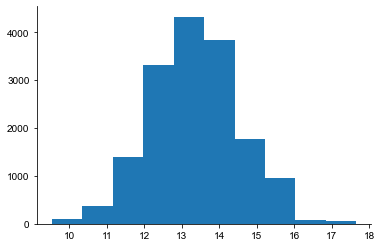

In [143]:
# What is the mean homing distance of simulated ants with full memory it should be similar to that of the ants ~12.79m
# Using this I determined that the distance_scaling_factor factor must be distance_scaling_factor = 2.87.

wait_noise_sd_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02]
mem_Nl_values = ['0.0'] # We only consider Nl=0 so that the denominator is 1, because the homing distance of full memory simulations starts decreasing with high Nl values, so we consider only no decay cases
mem_r_values = [-0.008, -0.01, -0.012, -0.014, -0.015, -0.016, -0.017, -0.018, -0.019, -0.02, -0.021, -0.022, -0.023, -0.024, -0.025, -0.026, -0.027, -0.028, -0.029, -0.03, -0.031, -0.032, -0.035, -0.04, -0.045, -0.05, -0.1] # 27

def get_mean_homing_distance_full_memory(wait_noise_sd_values, mem_Nl_values, mem_r_values):
    homing_distance_list = []

    for wait_noise_sd_value in wait_noise_sd_values:
        for mem_Nl_value in mem_Nl_values:
            for mem_r_value in mem_r_values:
                search_distance_data = search_dispersion_list[str(wait_noise_sd_value)][str(mem_Nl_value)][str(mem_r_value)]["Distance_hypot"][0]
                homing_distance_list += search_distance_data.tolist()

    return homing_distance_list

homing_distance_list = get_mean_homing_distance_full_memory(wait_noise_sd_values, mem_Nl_values, mem_r_values)
print('Mean homing distance with full memory is {}'.format(np.mean(np.array(homing_distance_list))))
print('with {:} estimates.'.format(len(homing_distance_list)))
plt.hist(homing_distance_list)